# Scanpy fastMNN DPT
##  Xiaonan Wang
## 23Jun2020

In [1]:
#%matplotlib nbagg
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import pandas as pd
import os
import smqpp
import re
import anndata
from mpl_toolkits.mplot3d import Axes3D

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()

from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred']) 

sc.settings.set_figure_params(dpi=80, color_map='viridis', vector_friendly=False,  dpi_save=300)

/home/xw251/miniconda3/envs/scanpy_py368/lib/python3.6/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.5.0 anndata==0.7.1 numpy==1.18.2 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1 leidenalg==0.7.0


In [104]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LinearSegmentedColormap
cdict = {'red': ((0.0, 0.0, 0.0),
                 (0.1, 0.5, 0.5),
                 (0.2, 0.0, 0.0),
                 (0.4, 0.2, 0.2),
                 (0.6, 0.0, 0.0),
                 (0.8, 1.0, 1.0),
                 (1.0, 1.0, 1.0)),
        'green':((0.0, 0.0, 0.0),
                 (0.1, 0.0, 0.0),
                 (0.2, 0.0, 0.0),
                 (0.4, 1.0, 1.0),
                 (0.6, 1.0, 1.0),
                 (0.8, 1.0, 1.0),
                 (1.0, 0.0, 0.0)),
        'blue': ((0.0, 0.0, 0.0),
                 (0.1, 0.5, 0.5),
                 (0.2, 1.0, 1.0),
                 (0.4, 1.0, 1.0),
                 (0.6, 0.0, 0.0),
                 (0.8, 0.0, 0.0),
                 (1.0, 0.0, 0.0))}

def plot_3d(adata_ref, obs_key, adata_new=None, obsm_key='X_diffmap', ncols=4,figsize=(6,6), alpha=0.5, azim=250,elev=30, markersize=1,components=[1,2,3], cmap=None):
    nkey = len(obs_key)
    if nkey <=4:
        ncols = nkey
    nrows = int(np.ceil((nkey)/ncols))
    fig = plt.figure(figsize=figsize)
    for nk in range(nkey):
        k = obs_key[nk]
        ax = fig.add_subplot(nrows, ncols, nk+1, projection='3d')
        ax.view_init(azim=azim, elev=elev)
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        
        if adata_new is None:
            adata = adata_ref.copy()
        else:
            adata = adata_new.copy()
            dm_ref = adata_ref.obsm[obsm_key]
            ax.plot(dm_ref[:,components[0]],dm_ref[:,components[1]],dm_ref[:,components[2]], '.', markersize=markersize, c='#d3d3d3', label = 'Ref_data', alpha =alpha)

        dm_new = adata.obsm[obsm_key]
        if k in adata.obs_keys():
            obs_term = adata.obs[k]
        elif k in adata.raw.var_names:
            obs_term = adata.raw[:, k].X.flatten()
        else:
            raise ValueError(k+'does not exist')
        if obs_term.dtype == 'float32' or obs_term.dtype == float or obs_term.dtype == int:
            if cmap is None:
                cmap = LinearSegmentedColormap('my_colormap',cdict,256) 
            #print(np.array(obs_term.values))
            conti_fig = ax.scatter(dm_new[:,components[0]],dm_new[:,components[1]],dm_new[:,components[2]], '.', s=markersize, c=np.array(obs_term), cmap=cmap, alpha =alpha)
            fig.colorbar(conti_fig, shrink=0.5)
            
        
        else:
            obs_term = obs_term.astype('category')
            cats = obs_term.cat.categories
            if k+'_colors' in adata.uns_keys():
                color_pal = adata.uns[k+'_colors']
            else:
                color_pal = sc.pl.palettes.default_20[0:len(cats)]
            for i in range(len(cats)):
                #print(cats[i])
                idx = obs_term==cats[i]
                ax.plot(dm_new[idx,components[0]],dm_new[idx,components[1]],dm_new[idx,components[2]], '.', markersize=markersize, c=color_pal[i], label = cats[i], alpha =alpha)

            plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        
        plt.tight_layout()

In [25]:
# Read in the log normalised counts
adata = sc.read('./write/CB_MPB_BM_lognorm.h5ad')

In [26]:
adata = adata[:,adata.uns['varGenes']['genes']['highVar']].copy()

In [27]:
# Scale the data for PCA
sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

computing PCA
    with n_comps=50
    finished (0:00:00)


In [28]:
adata.obs['Batch'].value_counts()

B1     493
B2     436
B4     374
0      360
S07    248
S08    216
B3     209
1      175
S09    170
Name: Batch, dtype: int64

In [30]:
adata.shape

(2681, 3479)

In [31]:
X_pca = adata.obsm['X_pca']
idx0 = adata.obs['Batch'] == '0'
print(sum(idx0))
idx1 = adata.obs['Batch'] == '1'
print(sum(idx1))
idx2 = adata.obs['Batch'] == 'B1'
print(sum(idx2))
idx3 = adata.obs['Batch'] == 'B2'
print(sum(idx3))
idx4 = adata.obs['Batch'] == 'B3'
print(sum(idx4))
idx5 = adata.obs['Batch'] == 'B4'
print(sum(idx5))
idx6 = adata.obs['Batch'] == 'S07'
print(sum(idx6))
idx7 = adata.obs['Batch'] == 'S08'
print(sum(idx7))
idx8 = adata.obs['Batch'] == 'S09'
print(sum(idx8))
pca0 = pd.DataFrame(X_pca[idx0])
print(pca0.shape)
pca1 = pd.DataFrame(X_pca[idx1])
print(pca1.shape)
pca2 = pd.DataFrame(X_pca[idx2])
print(pca2.shape)
pca3 = pd.DataFrame(X_pca[idx3])
print(pca3.shape)
pca4 = pd.DataFrame(X_pca[idx4])
print(pca4.shape)
pca5 = pd.DataFrame(X_pca[idx5])
print(pca5.shape)
pca6 = pd.DataFrame(X_pca[idx6])
print(pca6.shape)
pca7 = pd.DataFrame(X_pca[idx7])
print(pca7.shape)
pca8 = pd.DataFrame(X_pca[idx8])
print(pca8.shape)

360
175
493
436
209
374
248
216
170
(360, 50)
(175, 50)
(493, 50)
(436, 50)
(209, 50)
(374, 50)
(248, 50)
(216, 50)
(170, 50)


In [11]:
%reload_ext rpy2.ipython

In [19]:
%%R -i pca0 -i pca1 -i pca2 -i pca3 -i pca4 -i pca5 -i pca6 -i pca7 -i pca8 -o odf
suppressMessages(library("batchelor"))
odf = reducedMNN(data.matrix(pca0), data.matrix(pca1), data.matrix(pca2),data.matrix(pca3),data.matrix(pca4),data.matrix(pca5),data.matrix(pca6),data.matrix(pca7),data.matrix(pca8),
                      BPPARAM=MulticoreParam(detectCores()))
odf = data.frame(odf$corrected)

In [32]:
odf.shape

(2681, 50)

In [23]:
adata.shape

(1464, 3479)

In [33]:
CNs = np.concatenate([adata.obs_names[x] for x in [idx0, idx1, idx2, idx3, idx4, idx5, idx6, idx7, idx8]])
adata = adata[CNs,:].copy()
adata.obsm['X_pca'] = odf.values

In [34]:
sc.pp.neighbors(adata, n_neighbors=10)
sc.tl.diffmap(adata)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:02)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.99485844 0.988422   0.9809102  0.97309643 0.9602966
     0.95894265 0.9548561  0.9507737  0.94063044 0.9363357  0.9351315
     0.93200094 0.92690605 0.9246066 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


In [40]:
adata.obs_names = [x[:-2] for x in adata.obs_names]

In [35]:
wdir = '/home/xw251/rds/rds-bg200-hphi-gottgens/users/xw251/Lab_Members/Carys/'
MPB_raw = sc.read(wdir+'MPB1234/write/MPB1234_raw.h5ad')
MPB_raw.var_names_make_unique()
print('MPB shape: '+ str(MPB_raw.shape))
BM_raw = sc.read(wdir+'BM789/write/BM789_raw.h5ad')
BM_raw.var_names_make_unique()
print('BM shape: '+ str(BM_raw.shape))
CB_raw = sc.read(wdir+'MPB1234/write/CBdata_raw.h5ad')
CB_raw.var_names_make_unique()
print('CB shape: '+ str(CB_raw.shape))

MPB shape: (1512, 65988)
BM shape: (634, 65988)


Variable names are not unique. To make them unique, call `.var_names_make_unique`.


CB shape: (535, 65988)


In [78]:
CBdata = adata[adata.obs['batch'] == '0'].copy()
CBdata.obs = CB_raw[CBdata.obs_names,:].obs.copy()
MPBdata = adata[adata.obs['batch'] == '1'].copy()
MPBdata.obs = MPB_raw[MPBdata.obs_names,:].obs.copy()
BMdata = adata[adata.obs['batch'] == '2'].copy()
BMdata.obs = BM_raw[BMdata.obs_names,:].obs.copy()

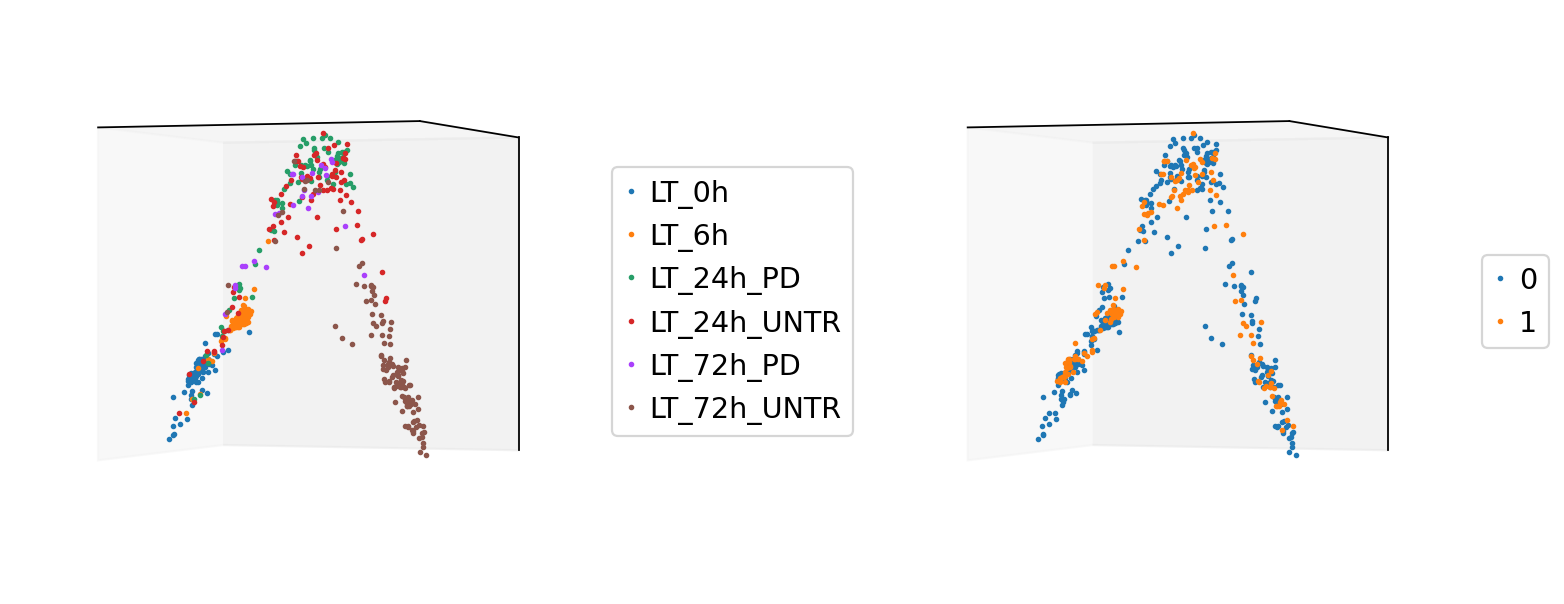

In [52]:
plot_3d(CBdata, ['Details', 'batch'], figsize=(10,4), azim= 70,elev=360, components=[1,2,3], alpha=1, markersize=3)

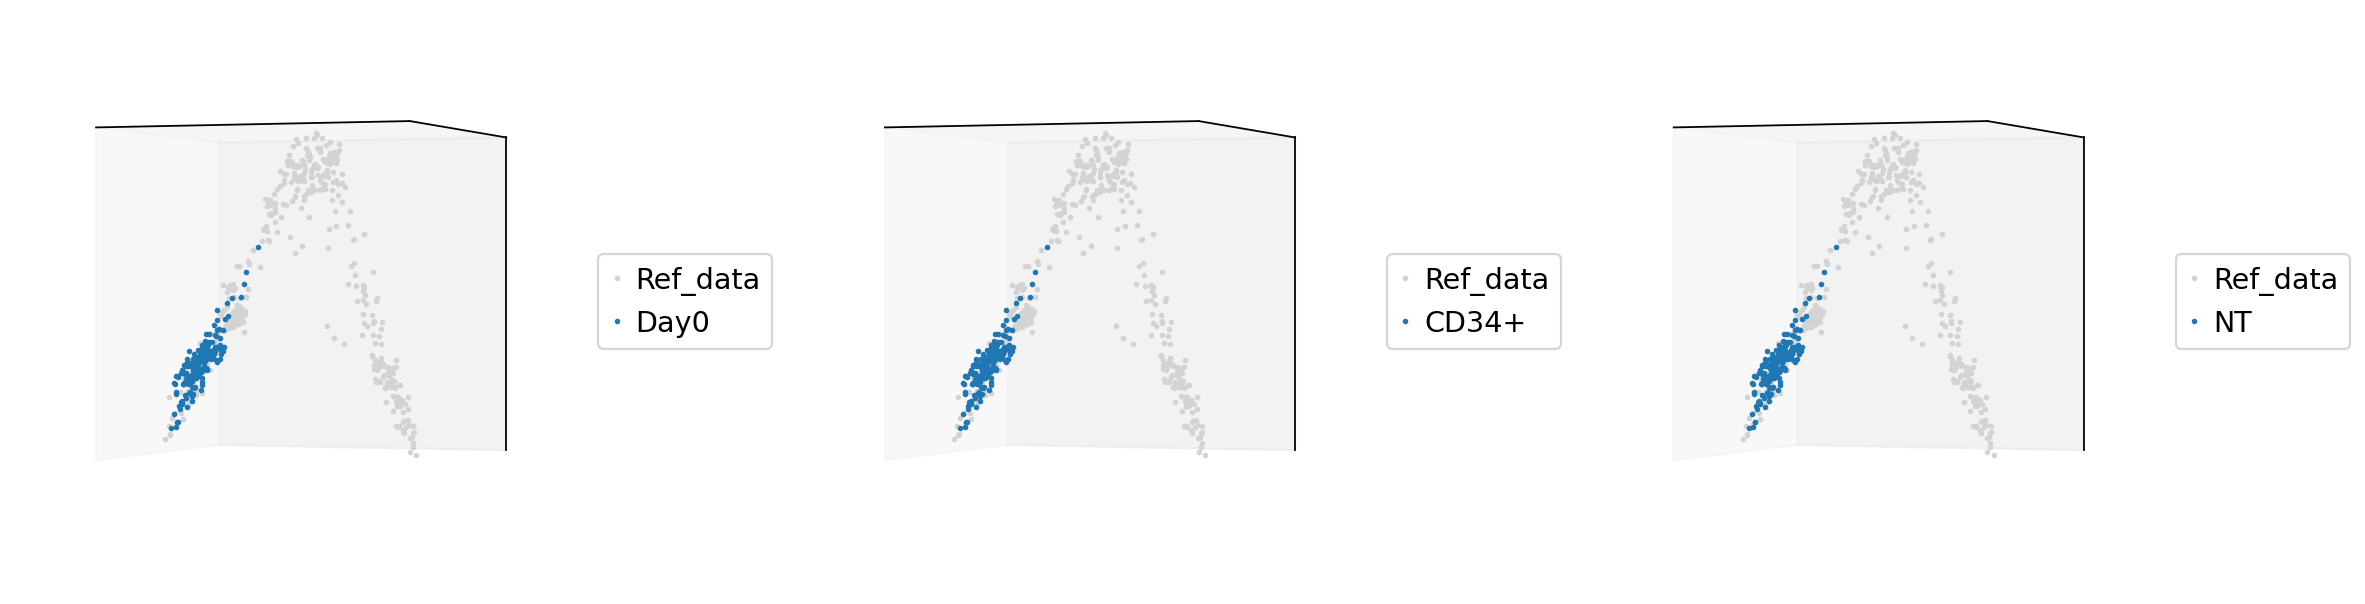

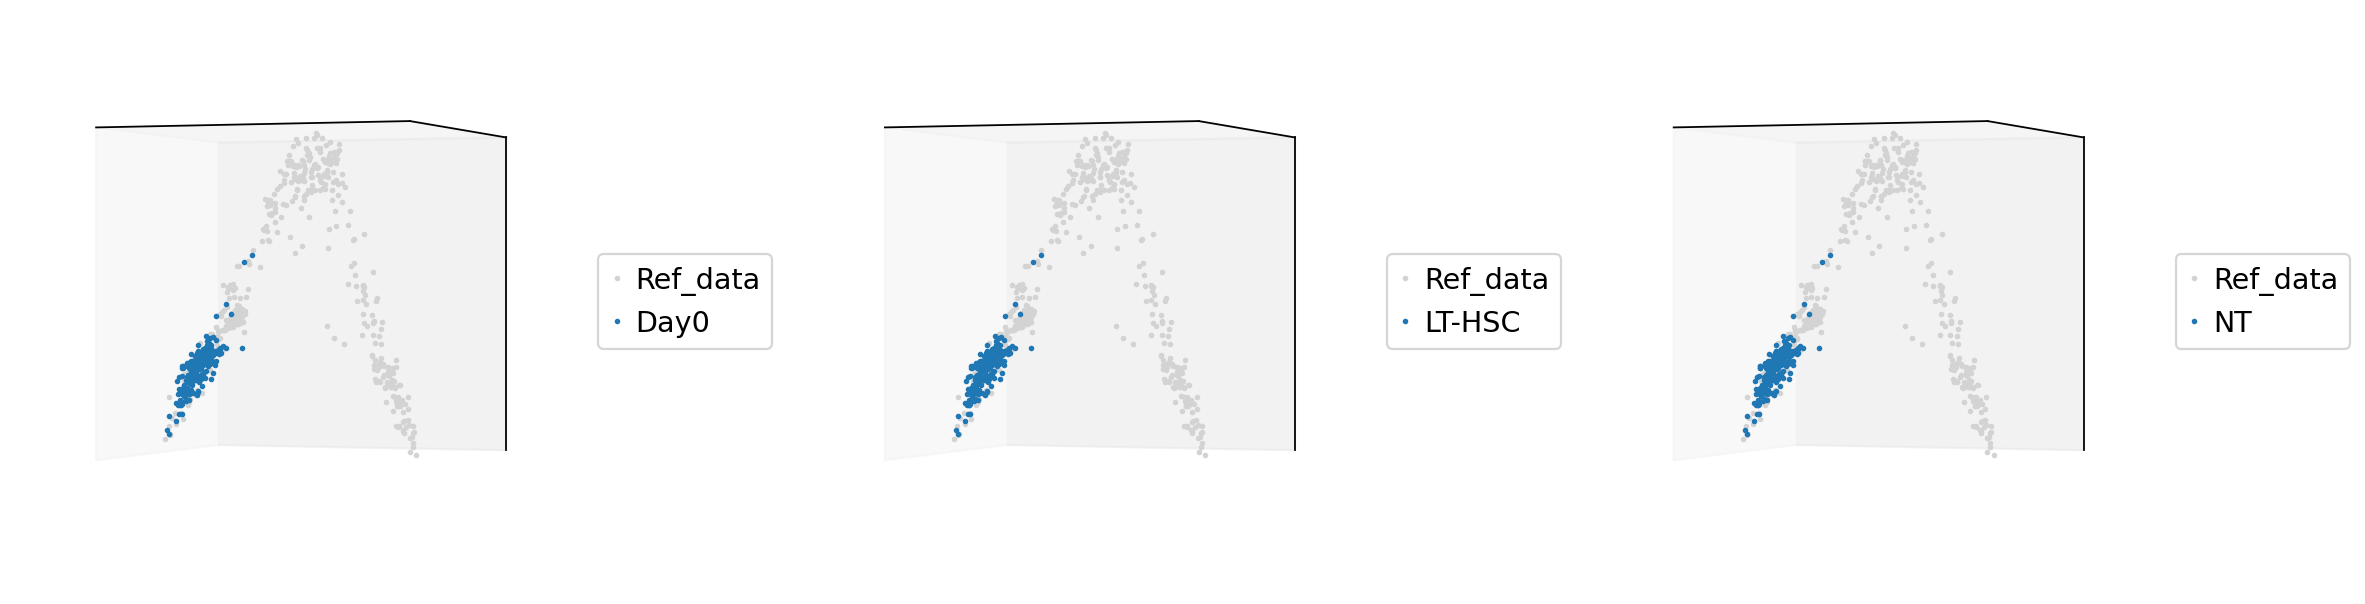

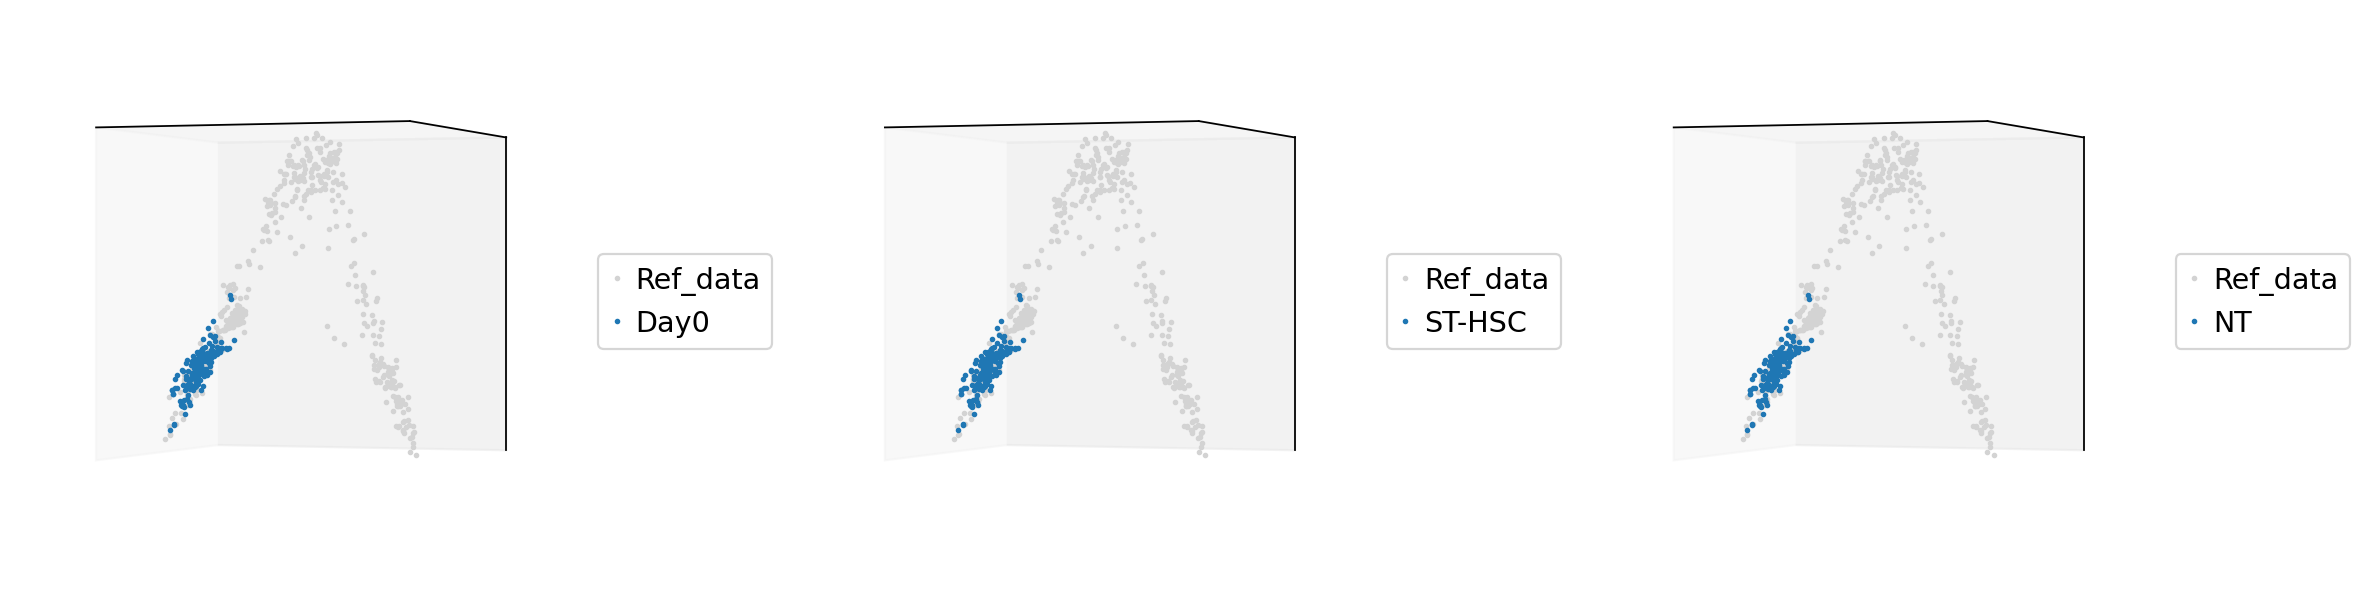

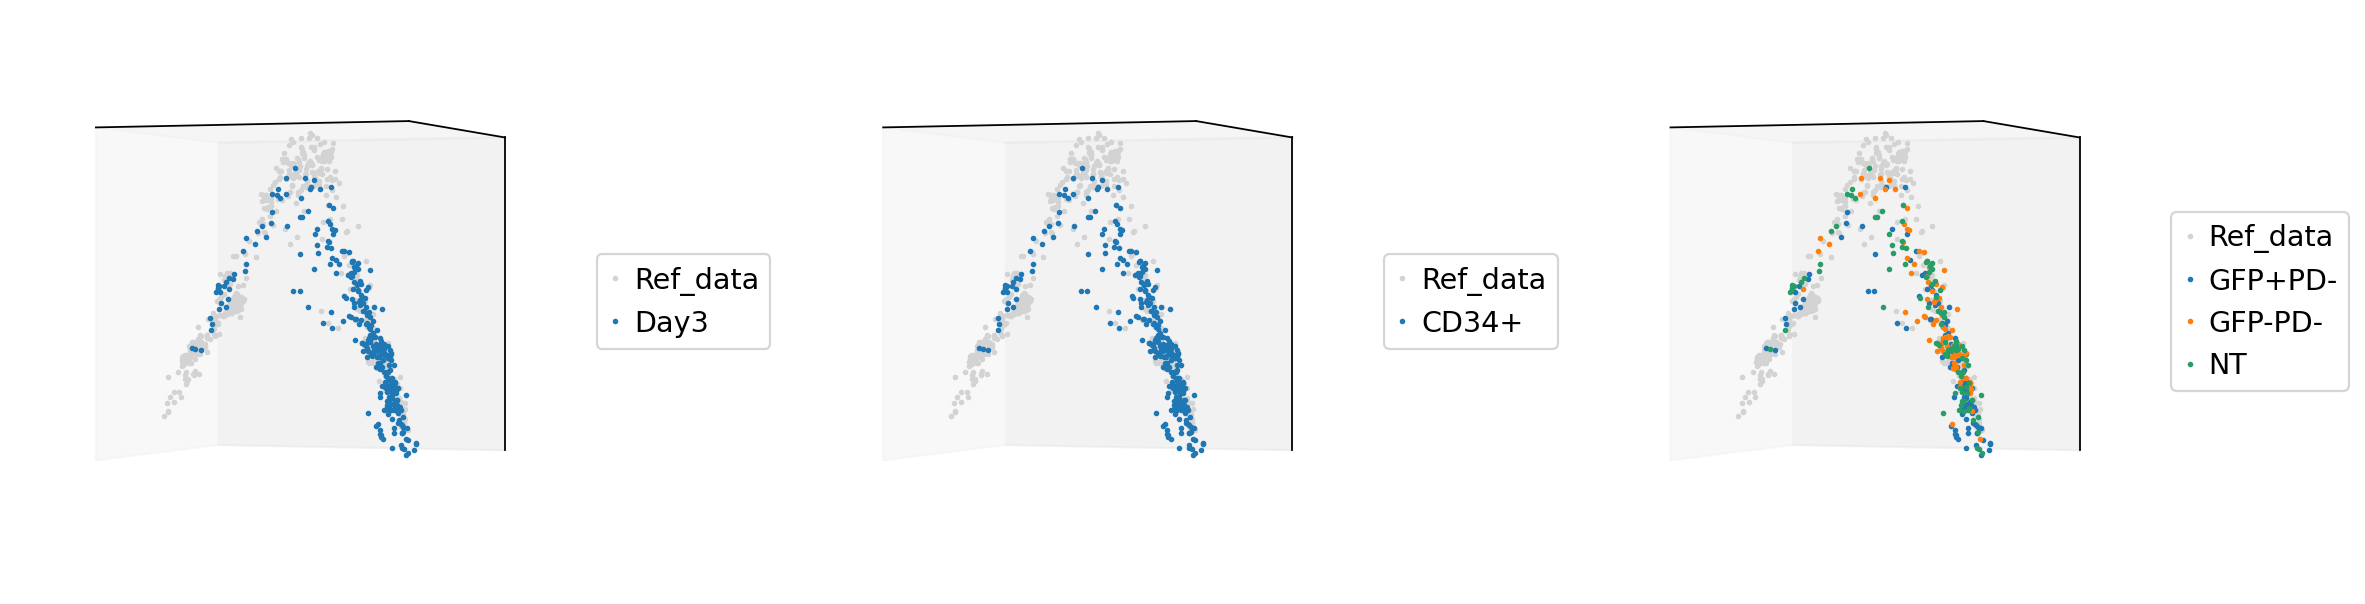

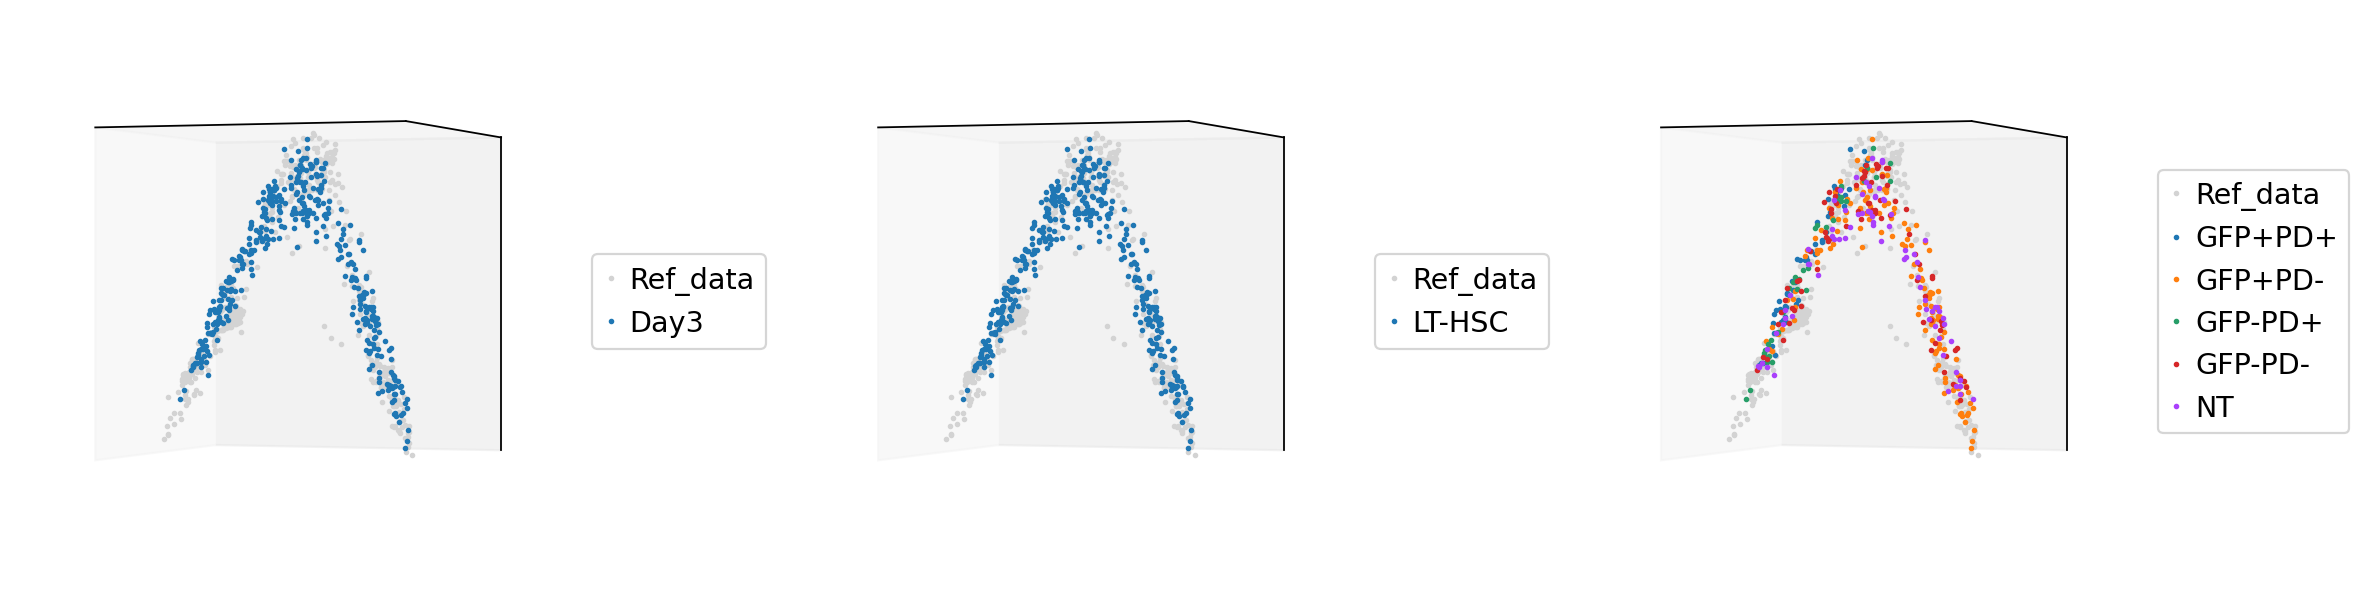

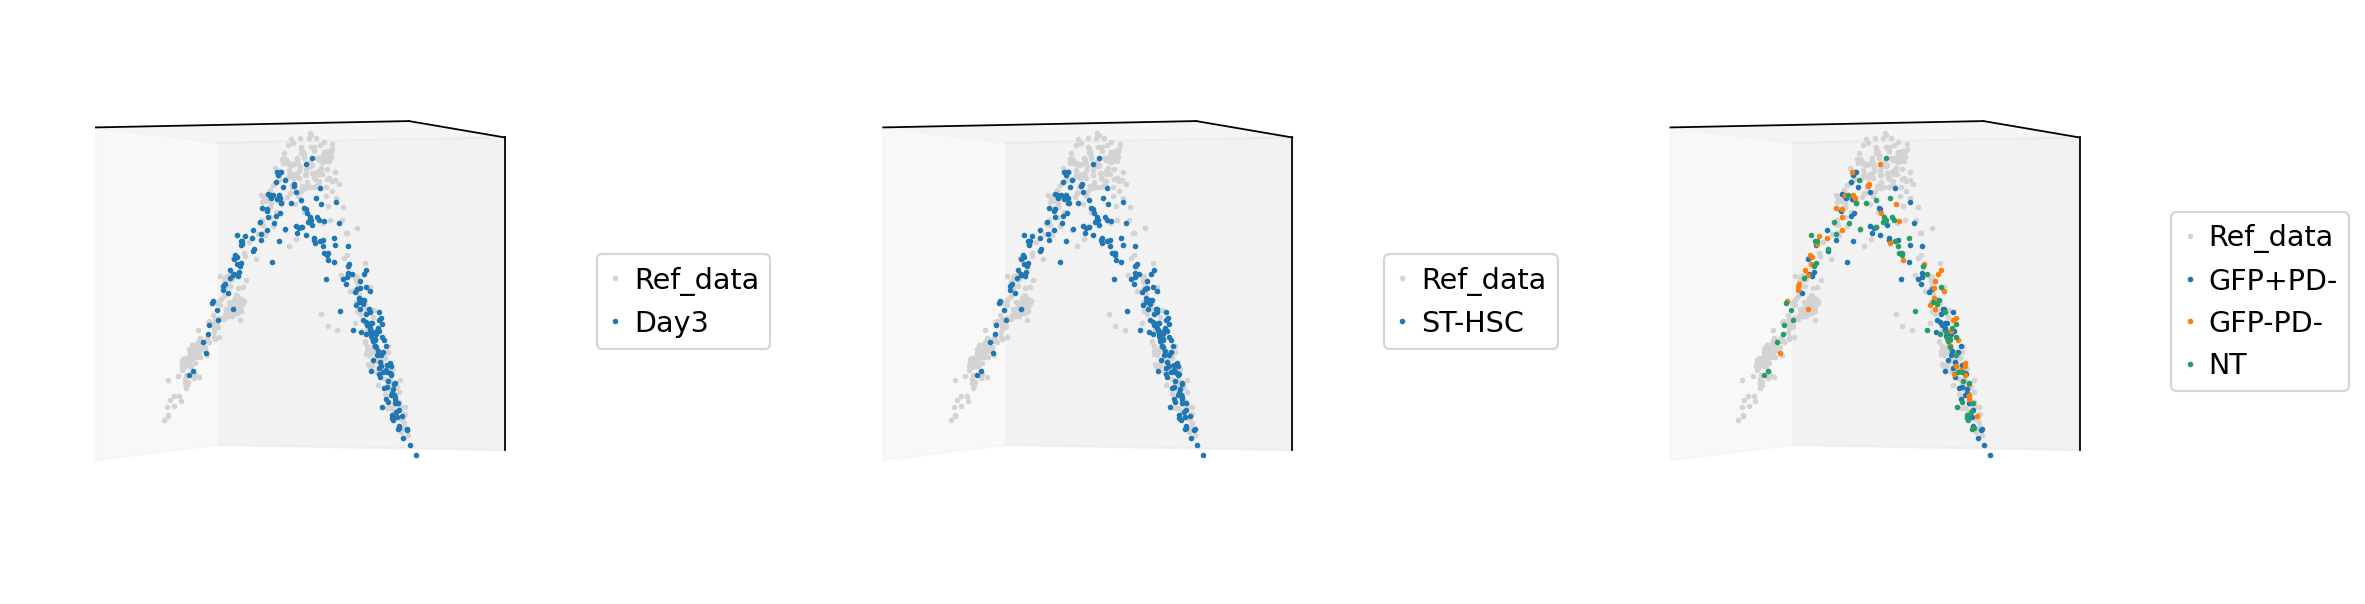

In [53]:
for i in np.unique(MPBdata.obs['Day']):
    for j in np.unique(MPBdata.obs['Cell_Type']):
        plot_3d(CBdata, ['Day', 'Cell_Type', 'Condition'], MPBdata[((MPBdata.obs['Day'] == i) & (MPBdata.obs['Cell_Type'] == j))], figsize=(15,4), azim=70,elev=360, components=[1,2,3], alpha=1, markersize=3)

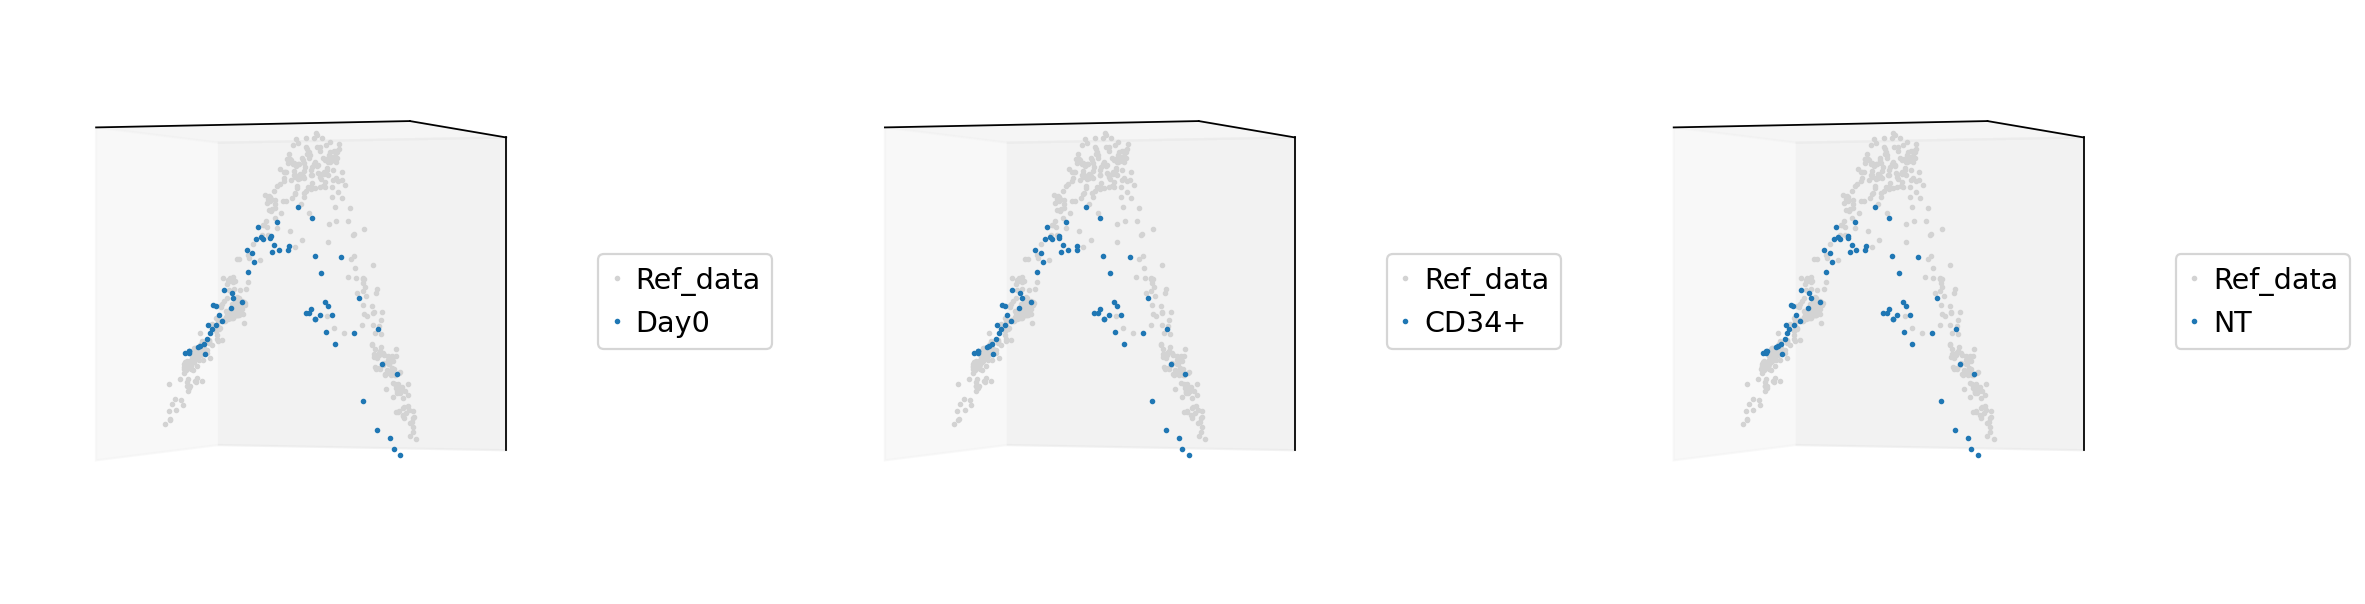

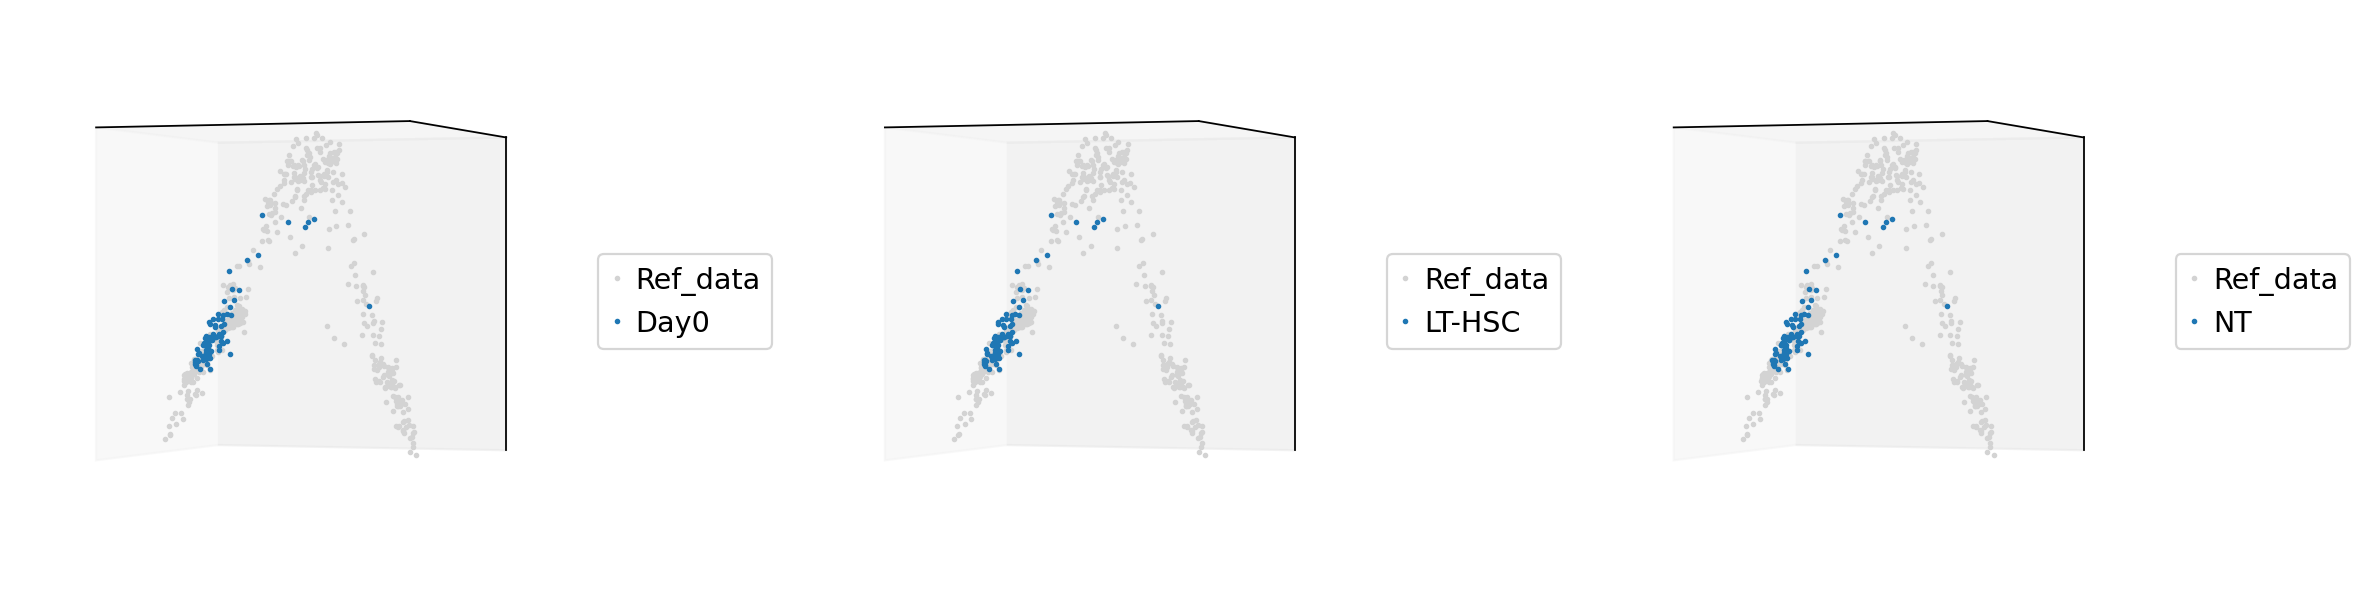

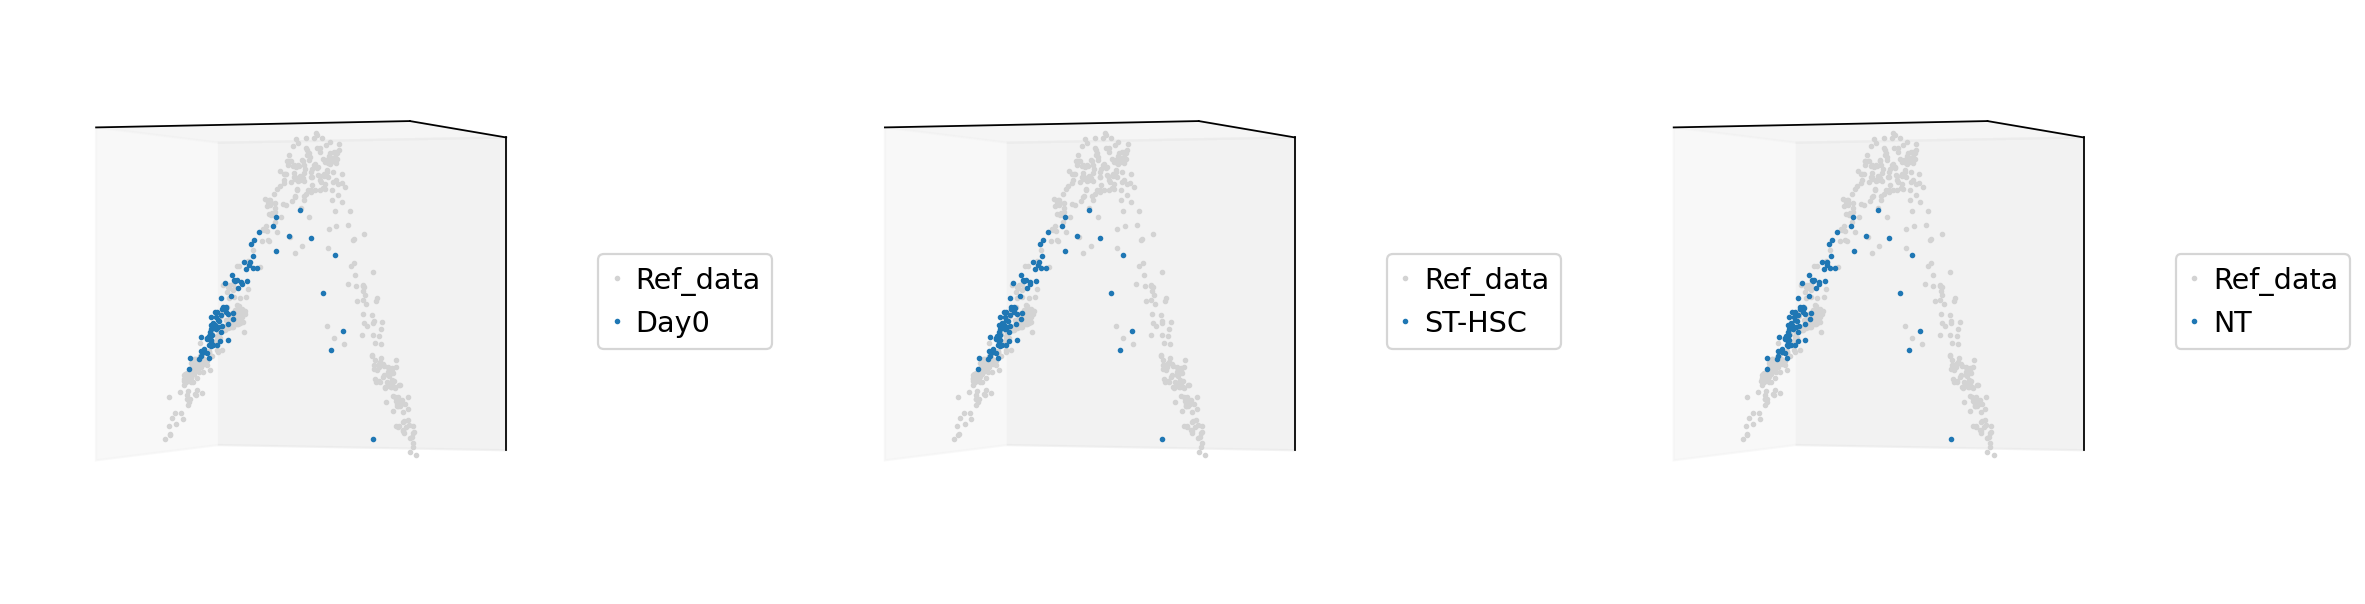

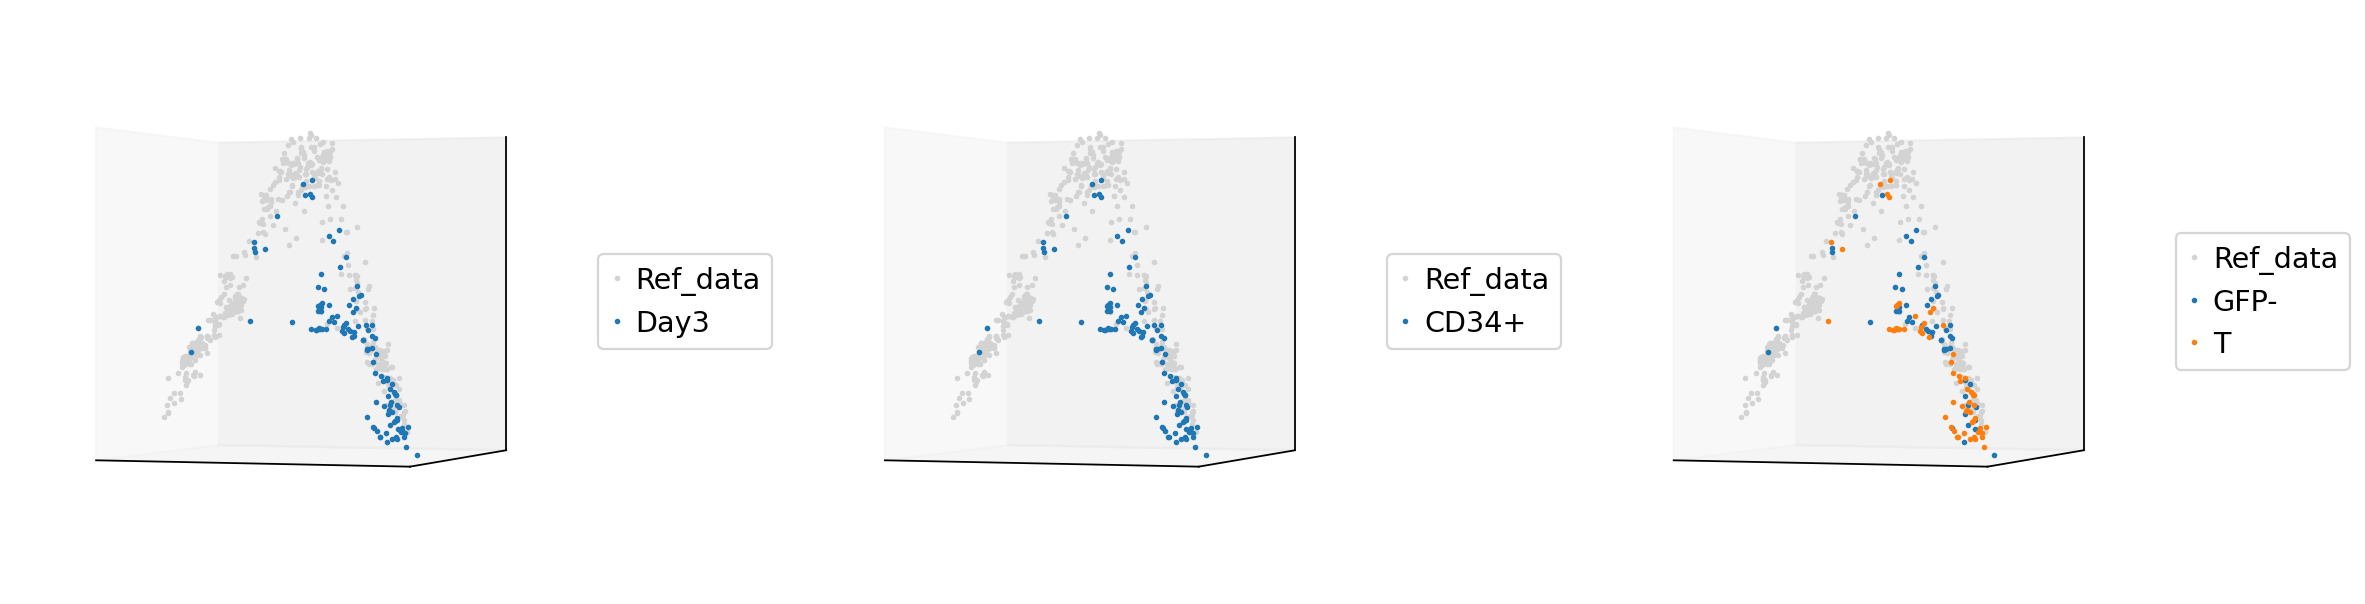

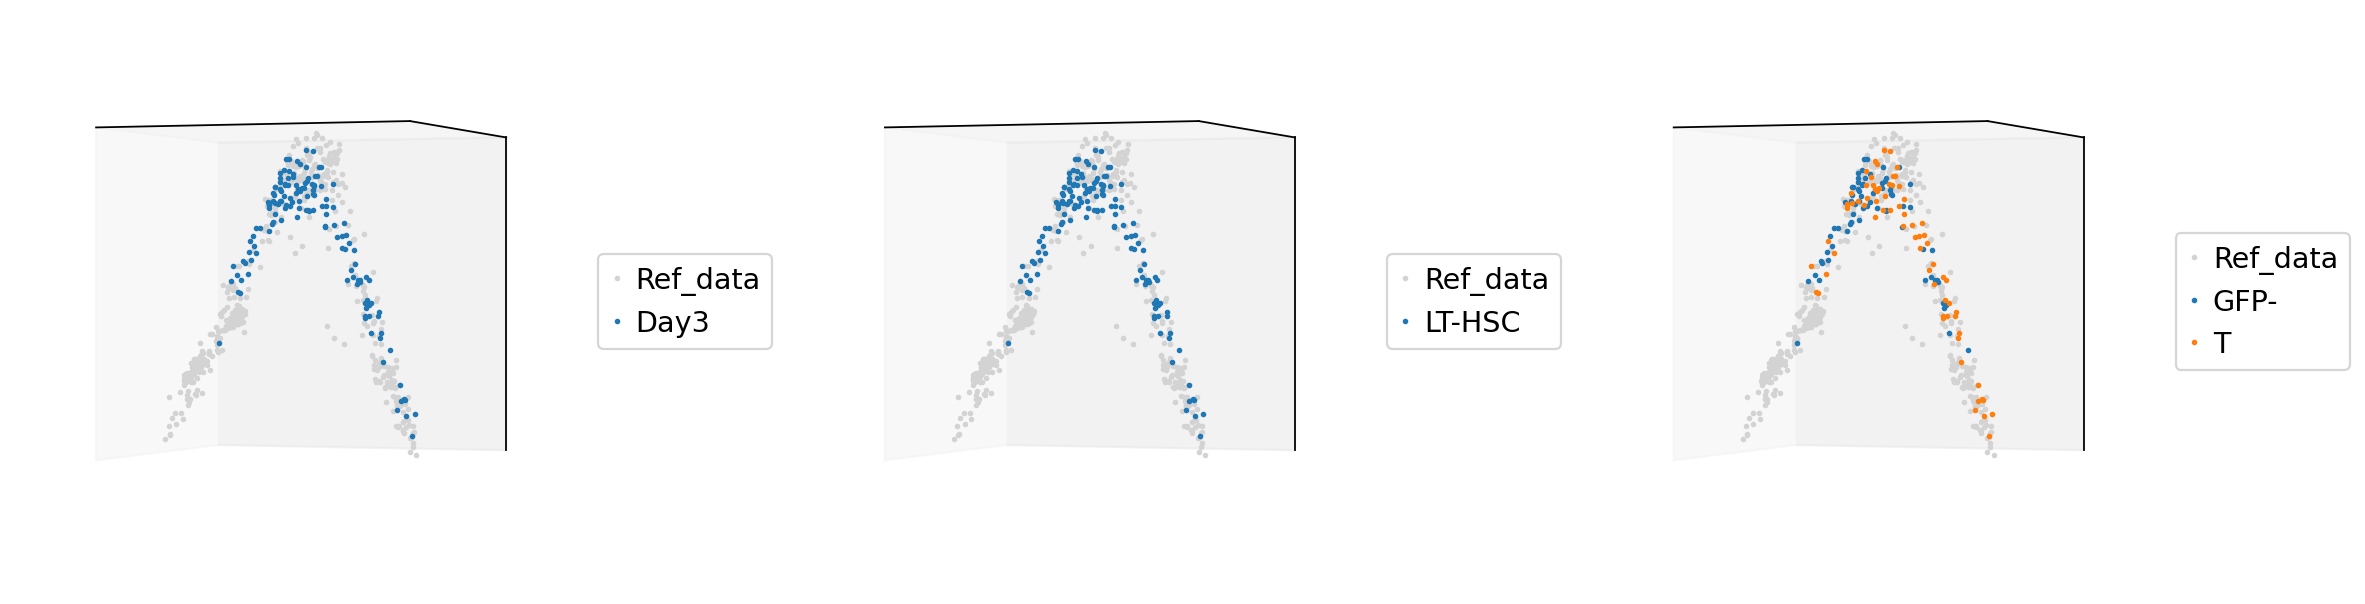

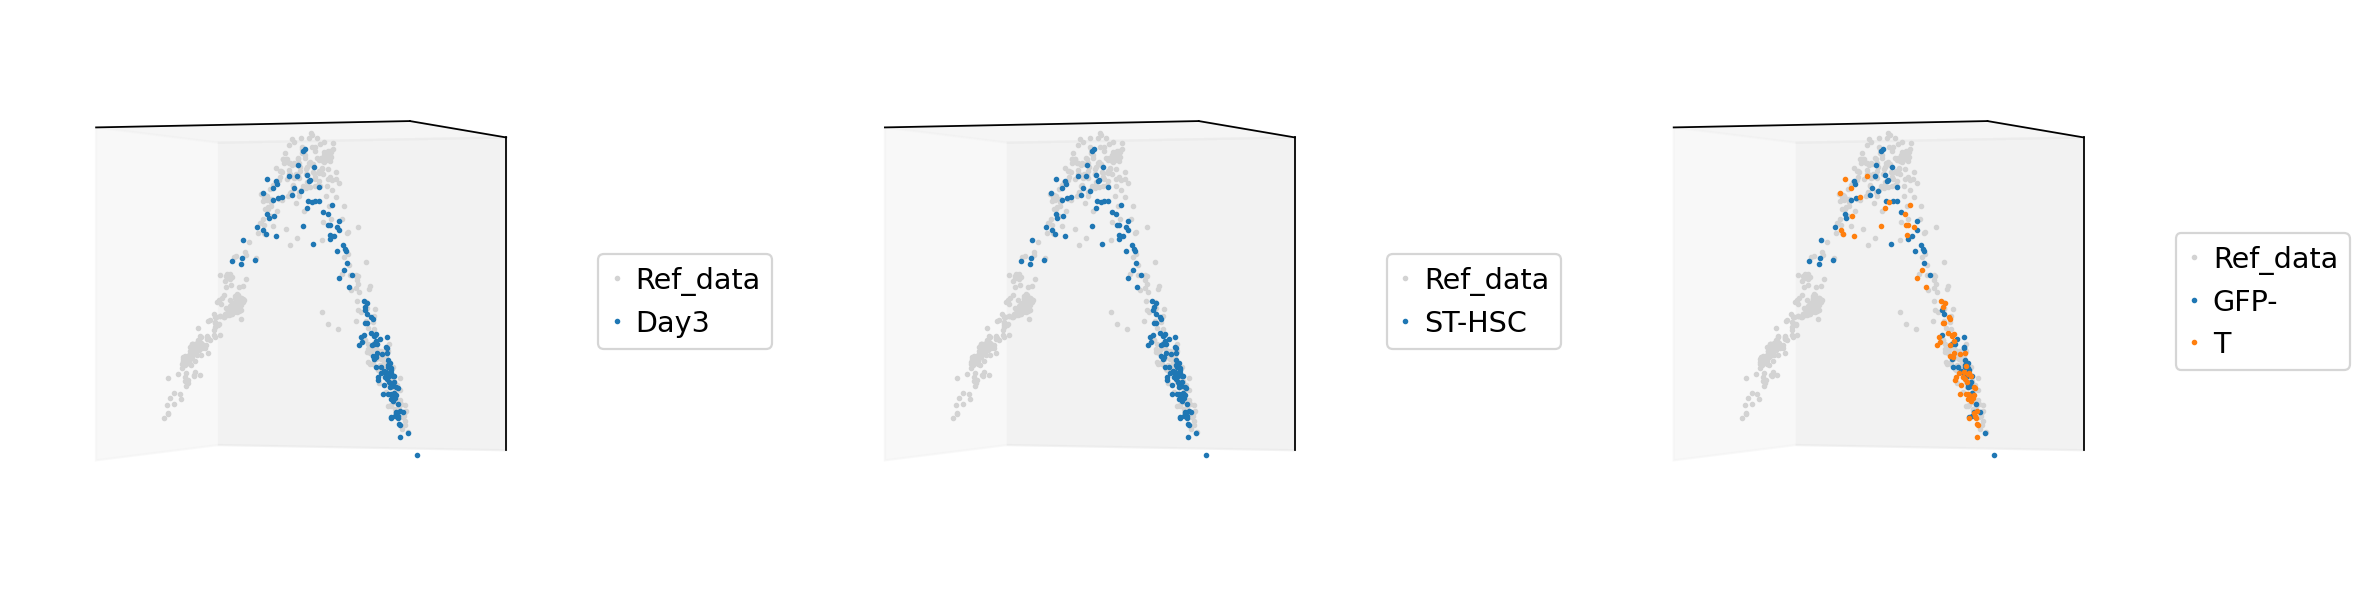

In [54]:
for i in np.unique(BMdata.obs['Day']):
    for j in np.unique(BMdata.obs['Cell_Type']):
        plot_3d(CBdata, ['Day', 'Cell_Type', 'Condition'], BMdata[((BMdata.obs['Day'] == i) & (BMdata.obs['Cell_Type'] == j))], figsize=(15,4), azim=70,elev=360, components=[1,2,3], alpha=1,markersize=3)

## PT calculation

In [55]:
np.where(np.in1d(adata.obs_names,'SLX.12561.N702_S502')==True)

(array([364]),)

In [56]:
adata.uns['iroot'] = 364
adata.obs['iroot_kenny'] = np.in1d(adata.obs_names,'SLX.12561.N702_S502')
adata.uns['iroot_kenny_colors'] = ['#d3d3d3', '#8B0000']

In [57]:
sc.tl.dpt(adata, n_branchings=0)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


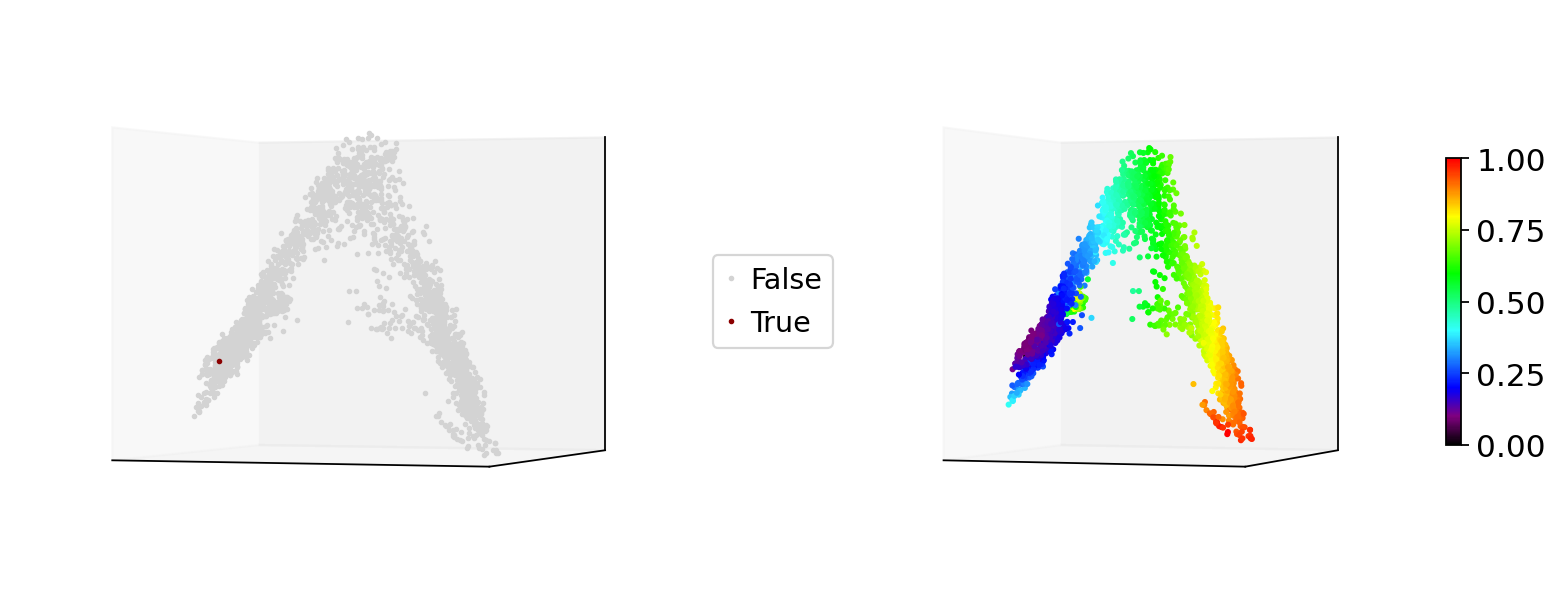

In [58]:
plot_3d(adata, ['iroot_kenny', 'dpt_pseudotime'], figsize=(10,4), azim=70,elev=360, components=[1,2,3], alpha=1, markersize=3) 

In [79]:
CBdata.obs['dpt_pseudotime'] = adata[CBdata.obs_names].obs['dpt_pseudotime']
MPBdata.obs['dpt_pseudotime'] = adata[MPBdata.obs_names].obs['dpt_pseudotime']
BMdata.obs['dpt_pseudotime'] = adata[BMdata.obs_names].obs['dpt_pseudotime']

In [80]:
CB_con = CB_raw.obs['Details']
MPB_con = MPB_raw.obs['Day'].astype(str)+'_'+MPB_raw.obs['Cell_Type'].astype(str)+'_'+MPB_raw.obs['Condition'].astype(str)
MPBdata.obs['cond_comb'] = MPB_con
BM_con = BM_raw.obs['Day'].astype(str)+'_'+BM_raw.obs['Cell_Type'].astype(str)+'_'+BM_raw.obs['Condition'].astype(str)
BMdata.obs['cond_comb'] = BM_con
cond_comb = np.concatenate([['CB_'+x for x in CB_con],['MPB_'+x for x in MPB_con], ['BM_'+x for x in BM_con]])
adata.obs['cond_comb'] = cond_comb

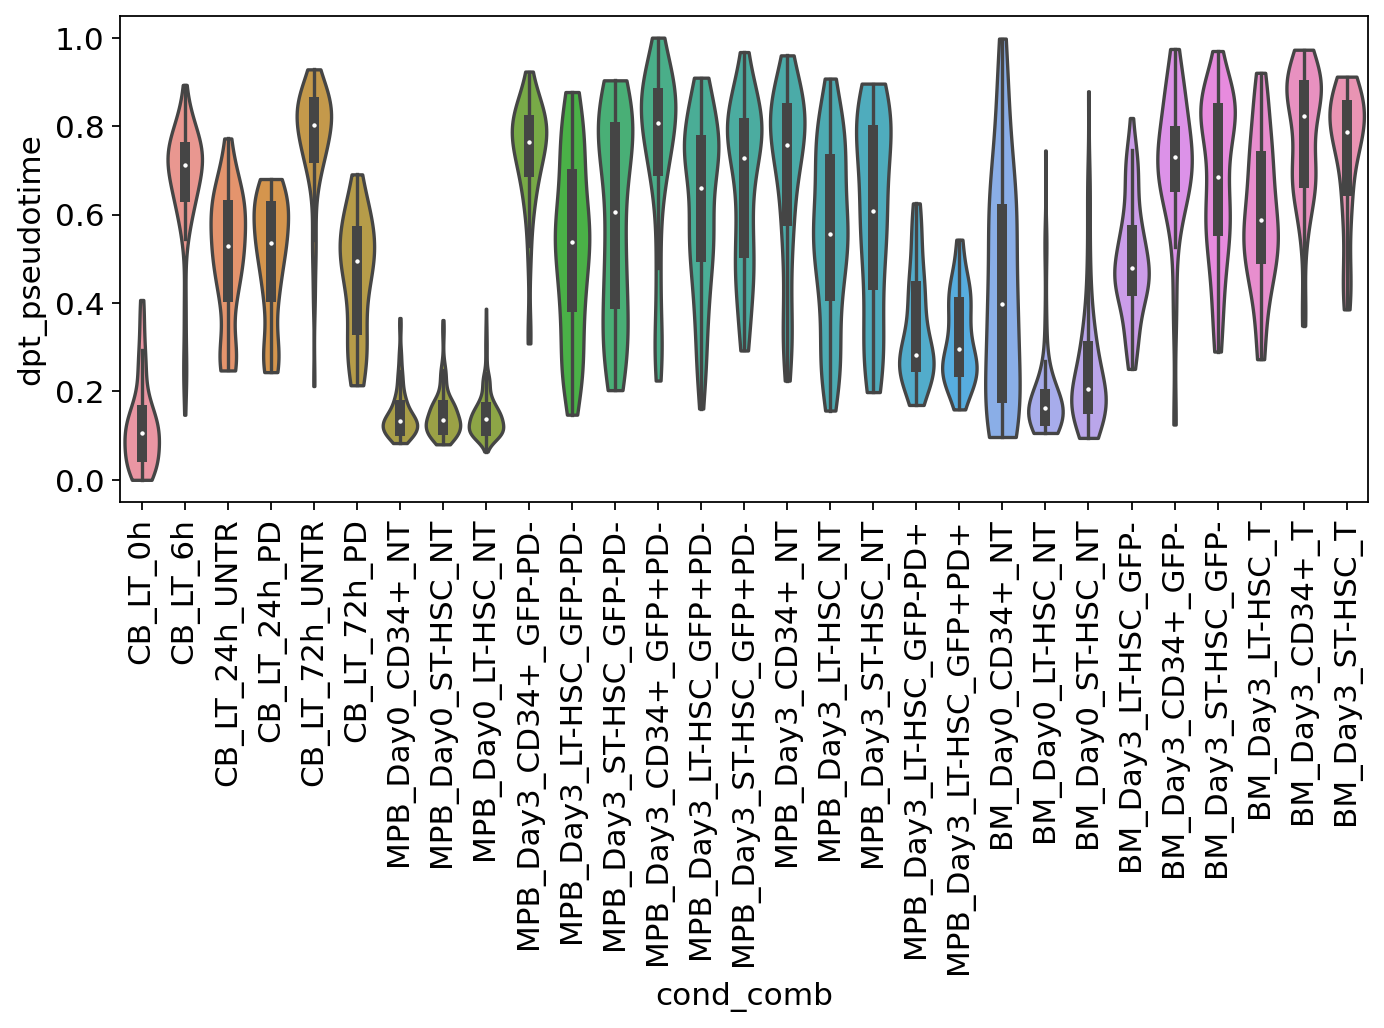

In [81]:
import seaborn as sns
ax, fig = plt.subplots(figsize=(10,4))
ax = sns.violinplot(x='cond_comb', y='dpt_pseudotime',data=adata.obs, scale='width', cut=0)
ax.grid(False)
ax.tick_params(axis='x',labelrotation=90)

In [82]:
CB_con = CB_raw.obs['Details']
MPB_con = MPB_raw.obs['Day'].astype(str)+'_'+MPB_raw.obs['Cell_Type'].astype(str)
MPBdata.obs['cond_comb1'] = MPB_con
BM_con = BM_raw.obs['Day'].astype(str)+'_'+BM_raw.obs['Cell_Type'].astype(str)
BMdata.obs['cond_comb1'] = BM_con
cond_comb = np.concatenate([['CB_'+x for x in CB_con],['MPB_'+x for x in MPB_con], ['BM_'+x for x in BM_con]])
adata.obs['cond_comb1'] = cond_comb

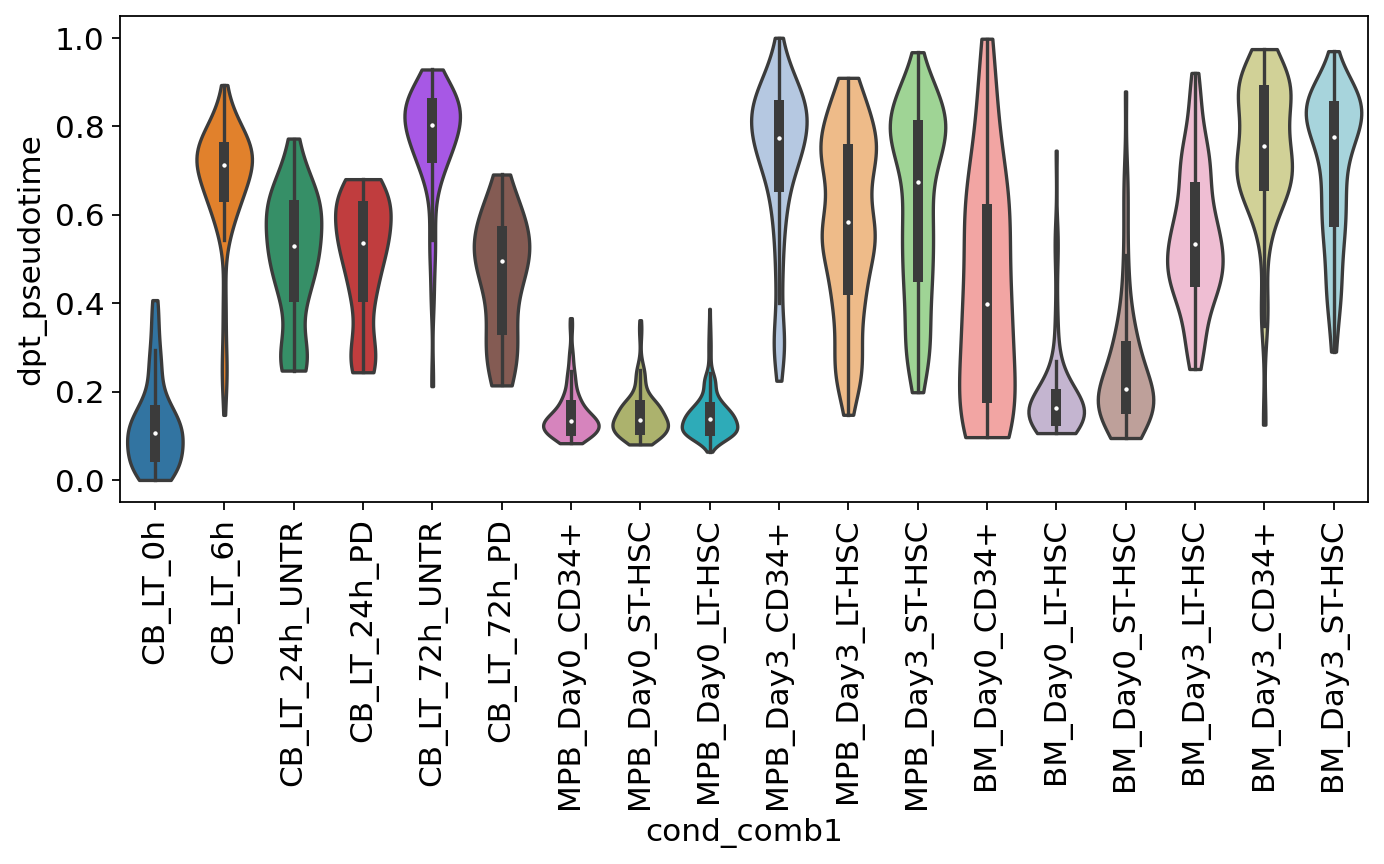

In [83]:
import seaborn as sns
ax, fig = plt.subplots(figsize=(10,4))
ax = sns.violinplot(x='cond_comb1', y='dpt_pseudotime',data=adata[['PD+' not in x for x in adata.obs['Condition']]].obs, scale='width', cut=0)
ax.grid(False)
ax.tick_params(axis='x',labelrotation=90)

MPB data

Day0_CD34+


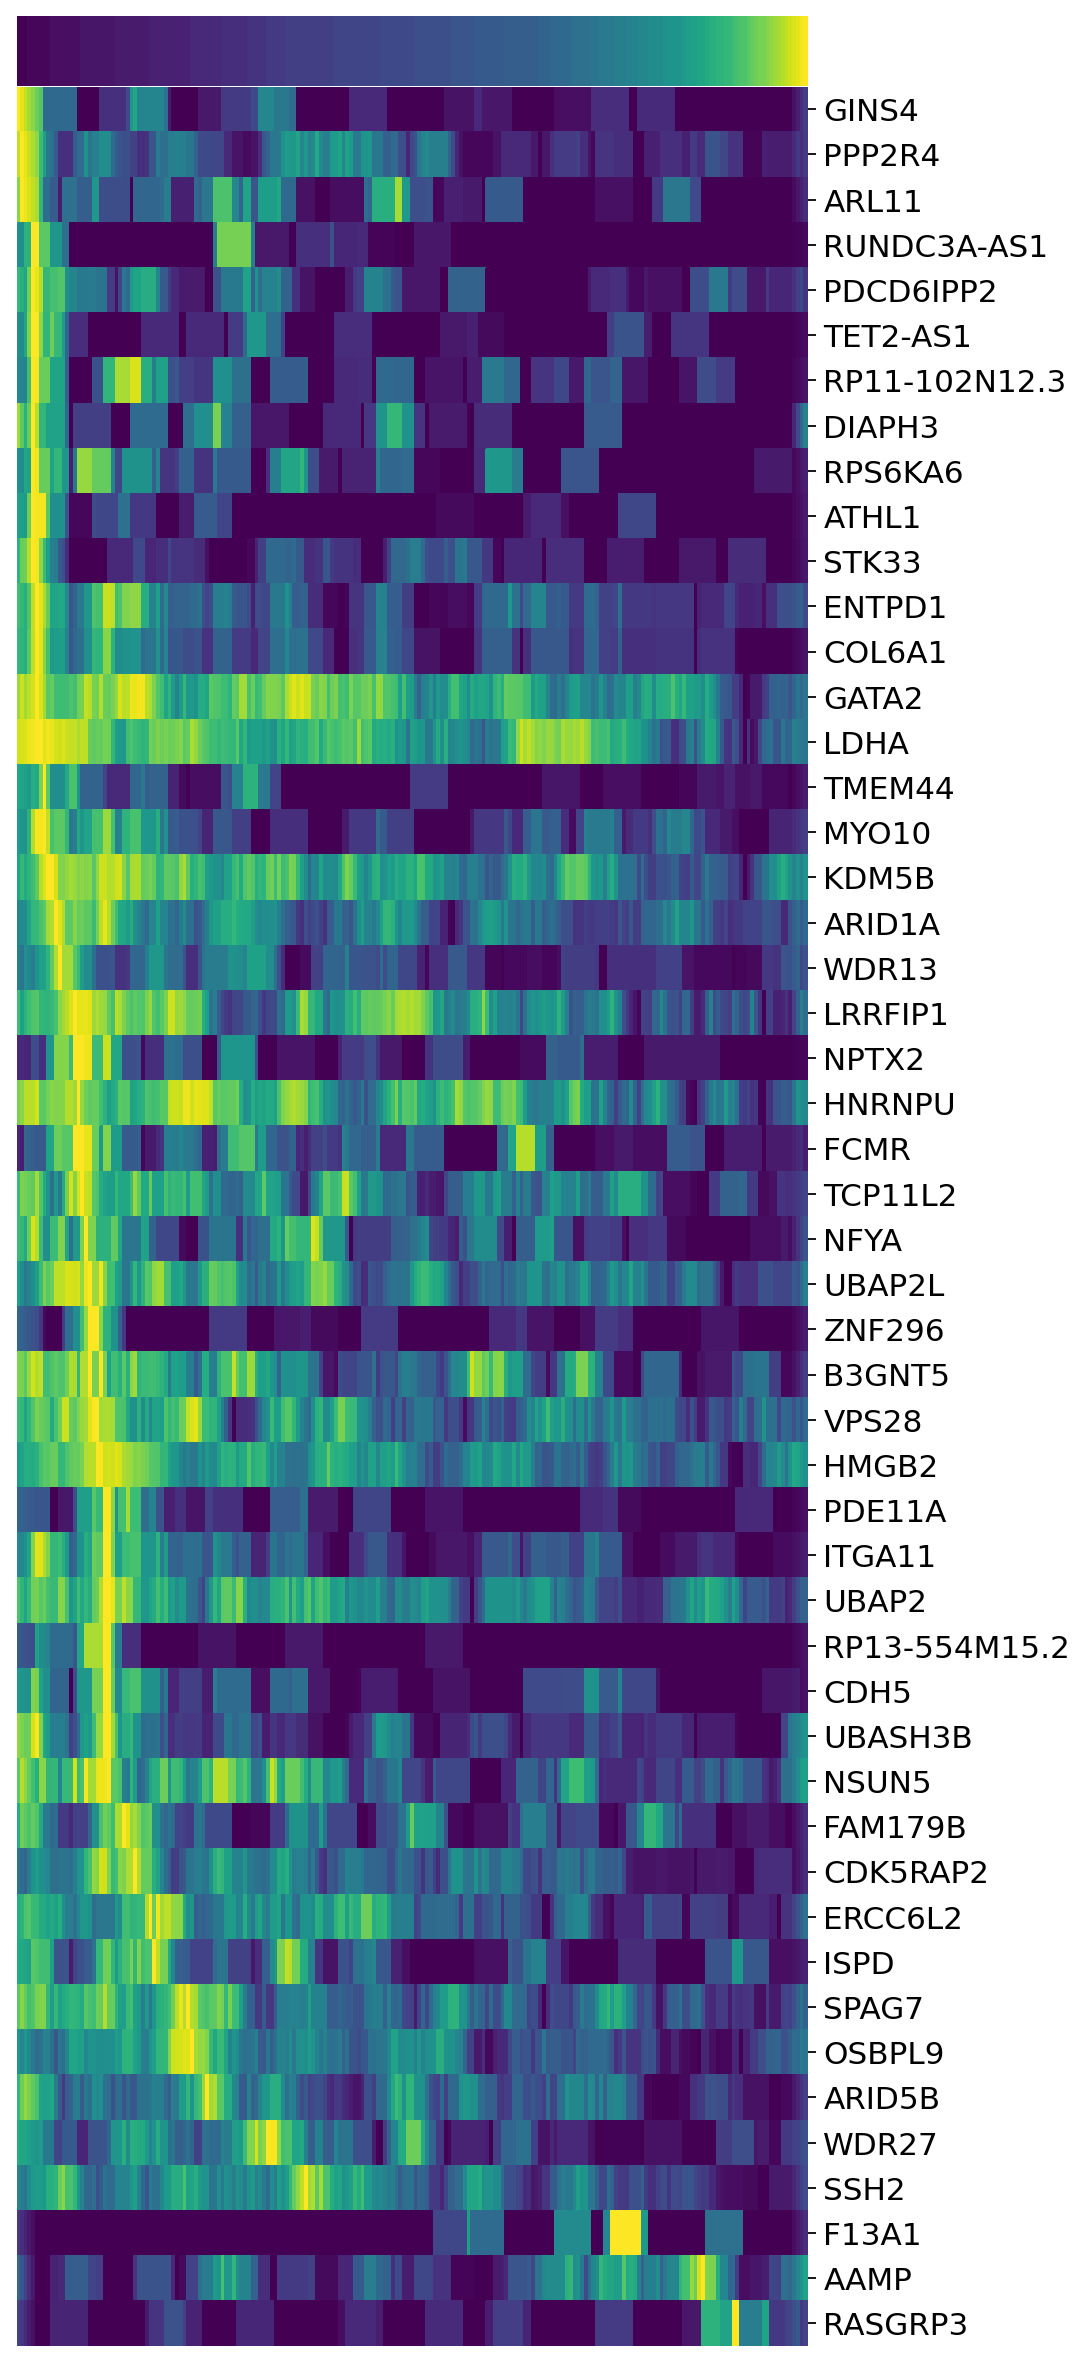

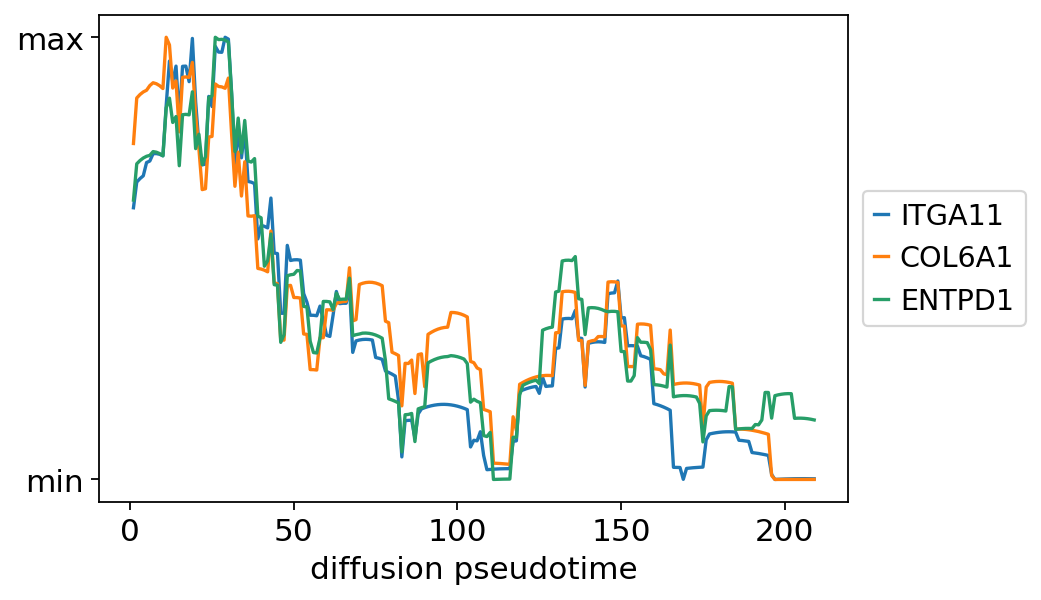

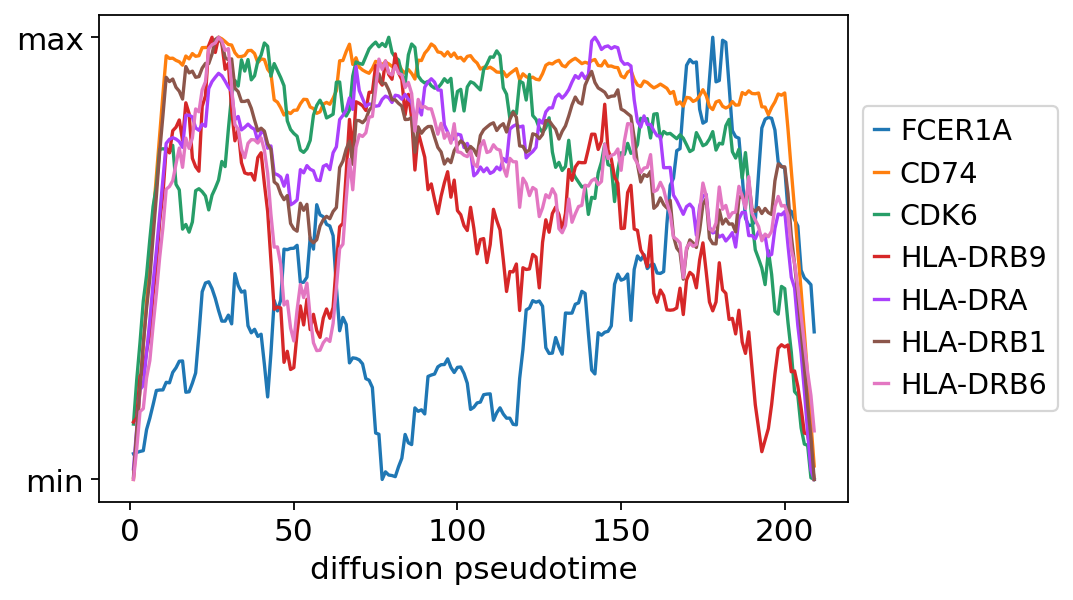

Day0_LT-HSC


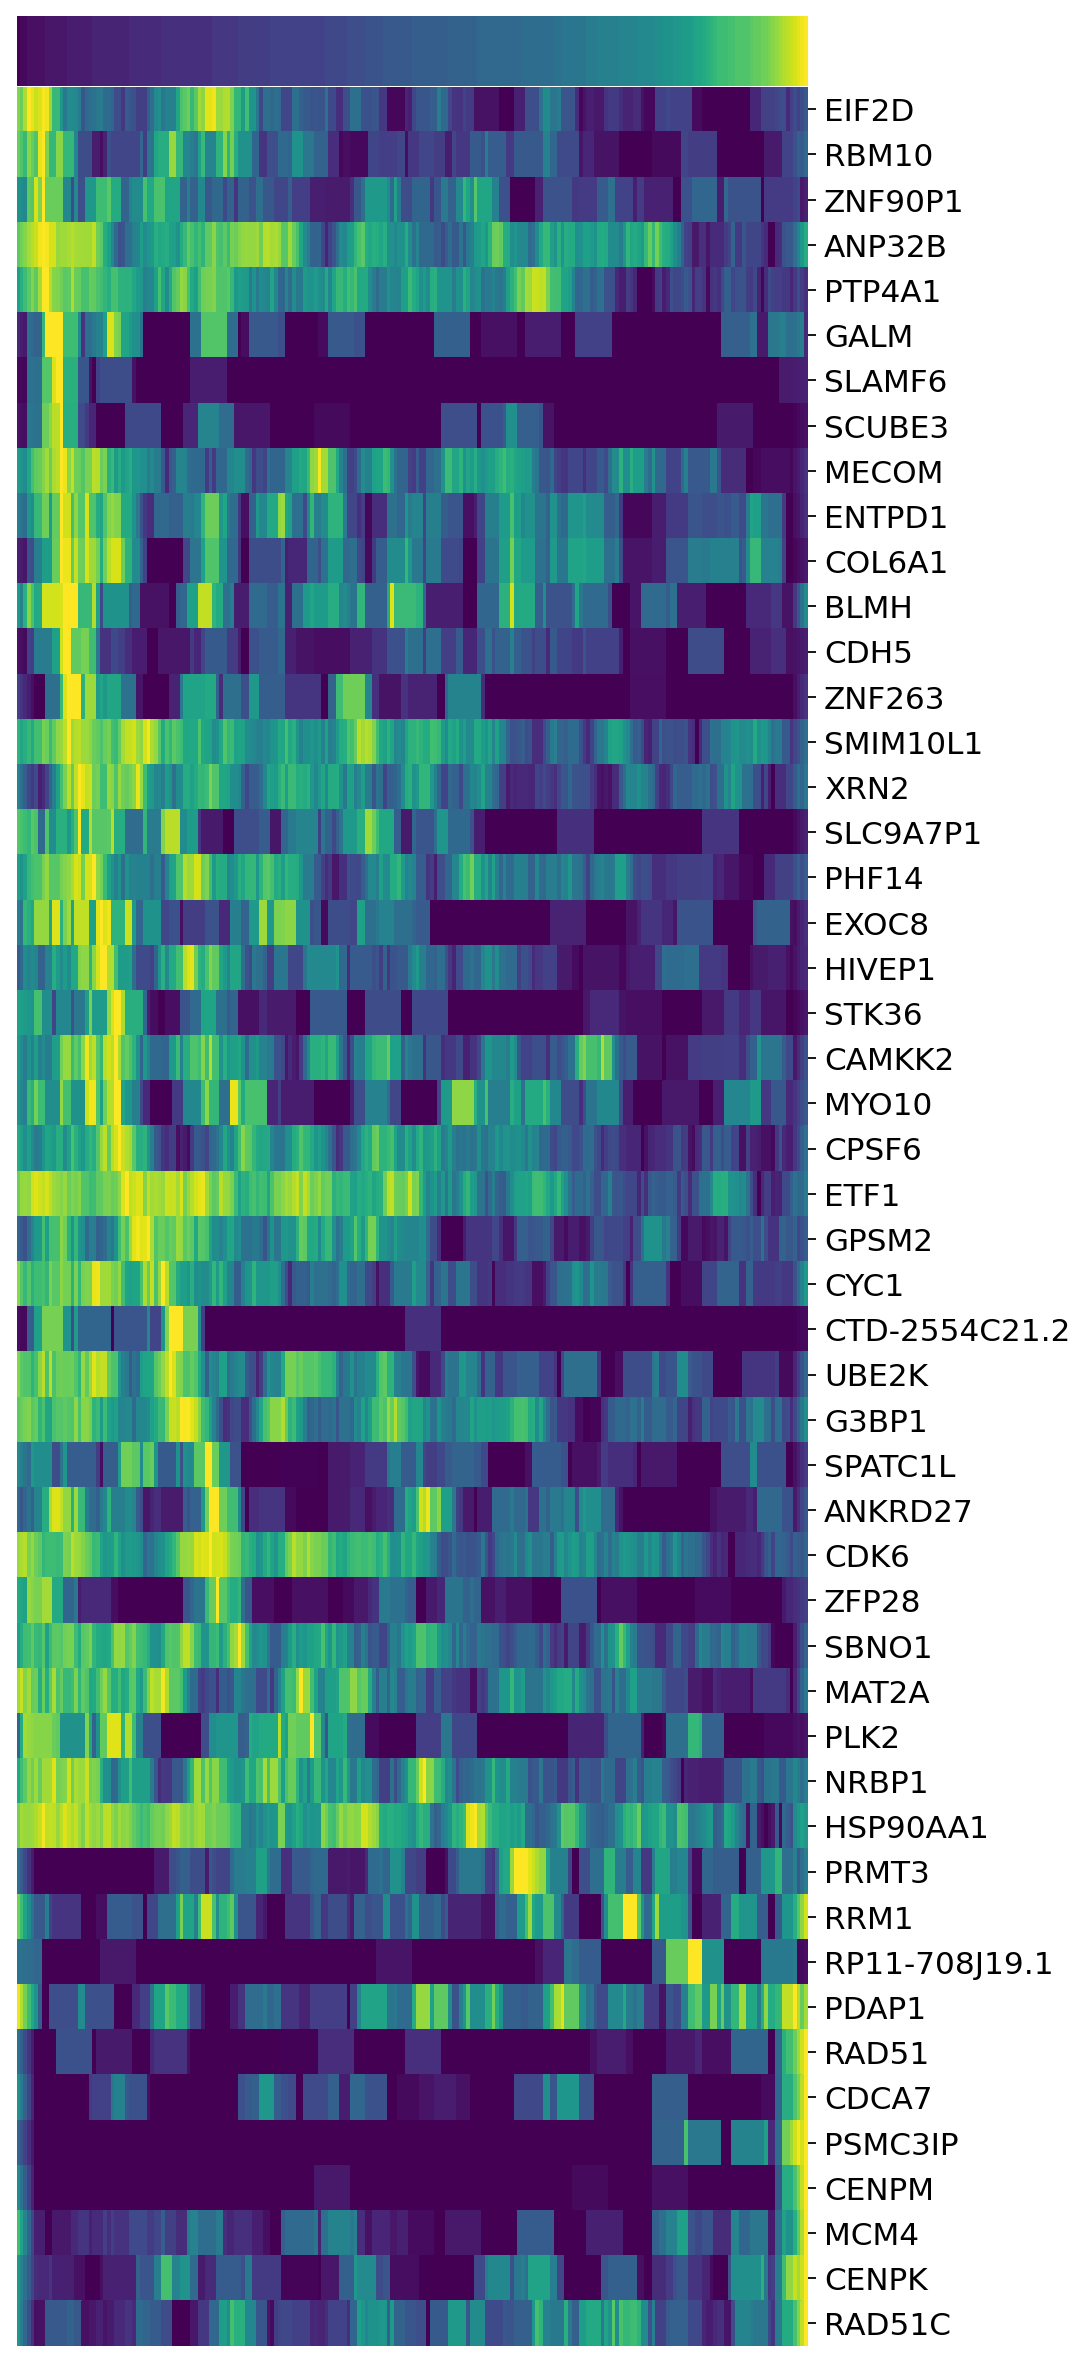

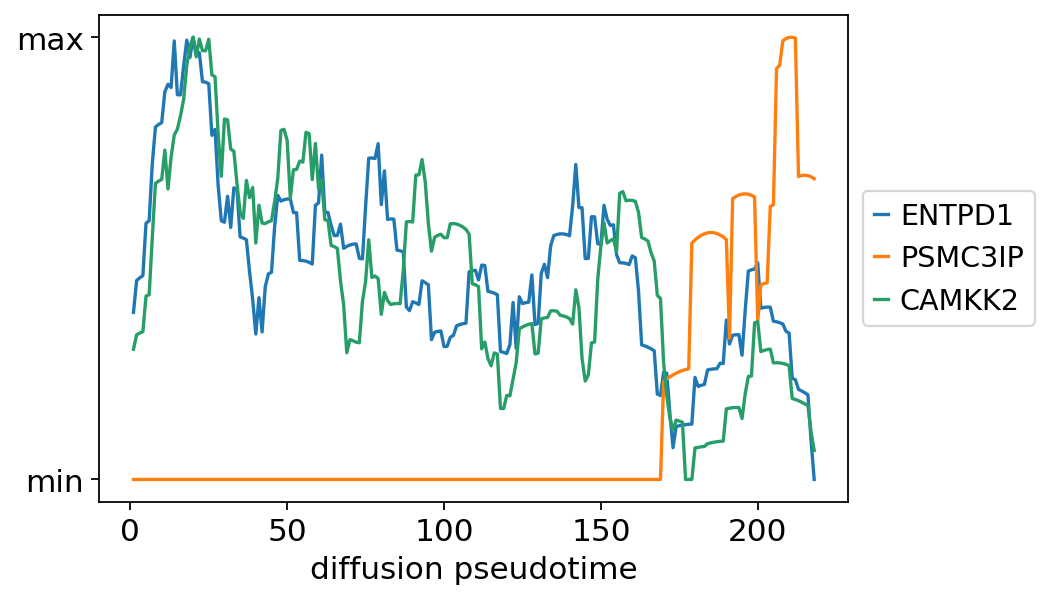

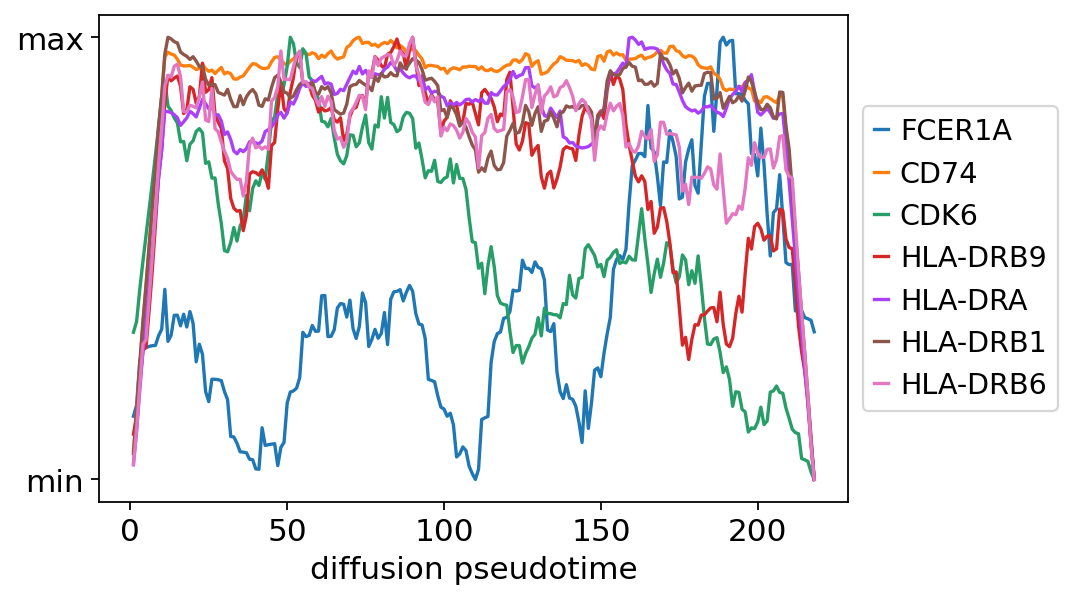

Day0_ST-HSC


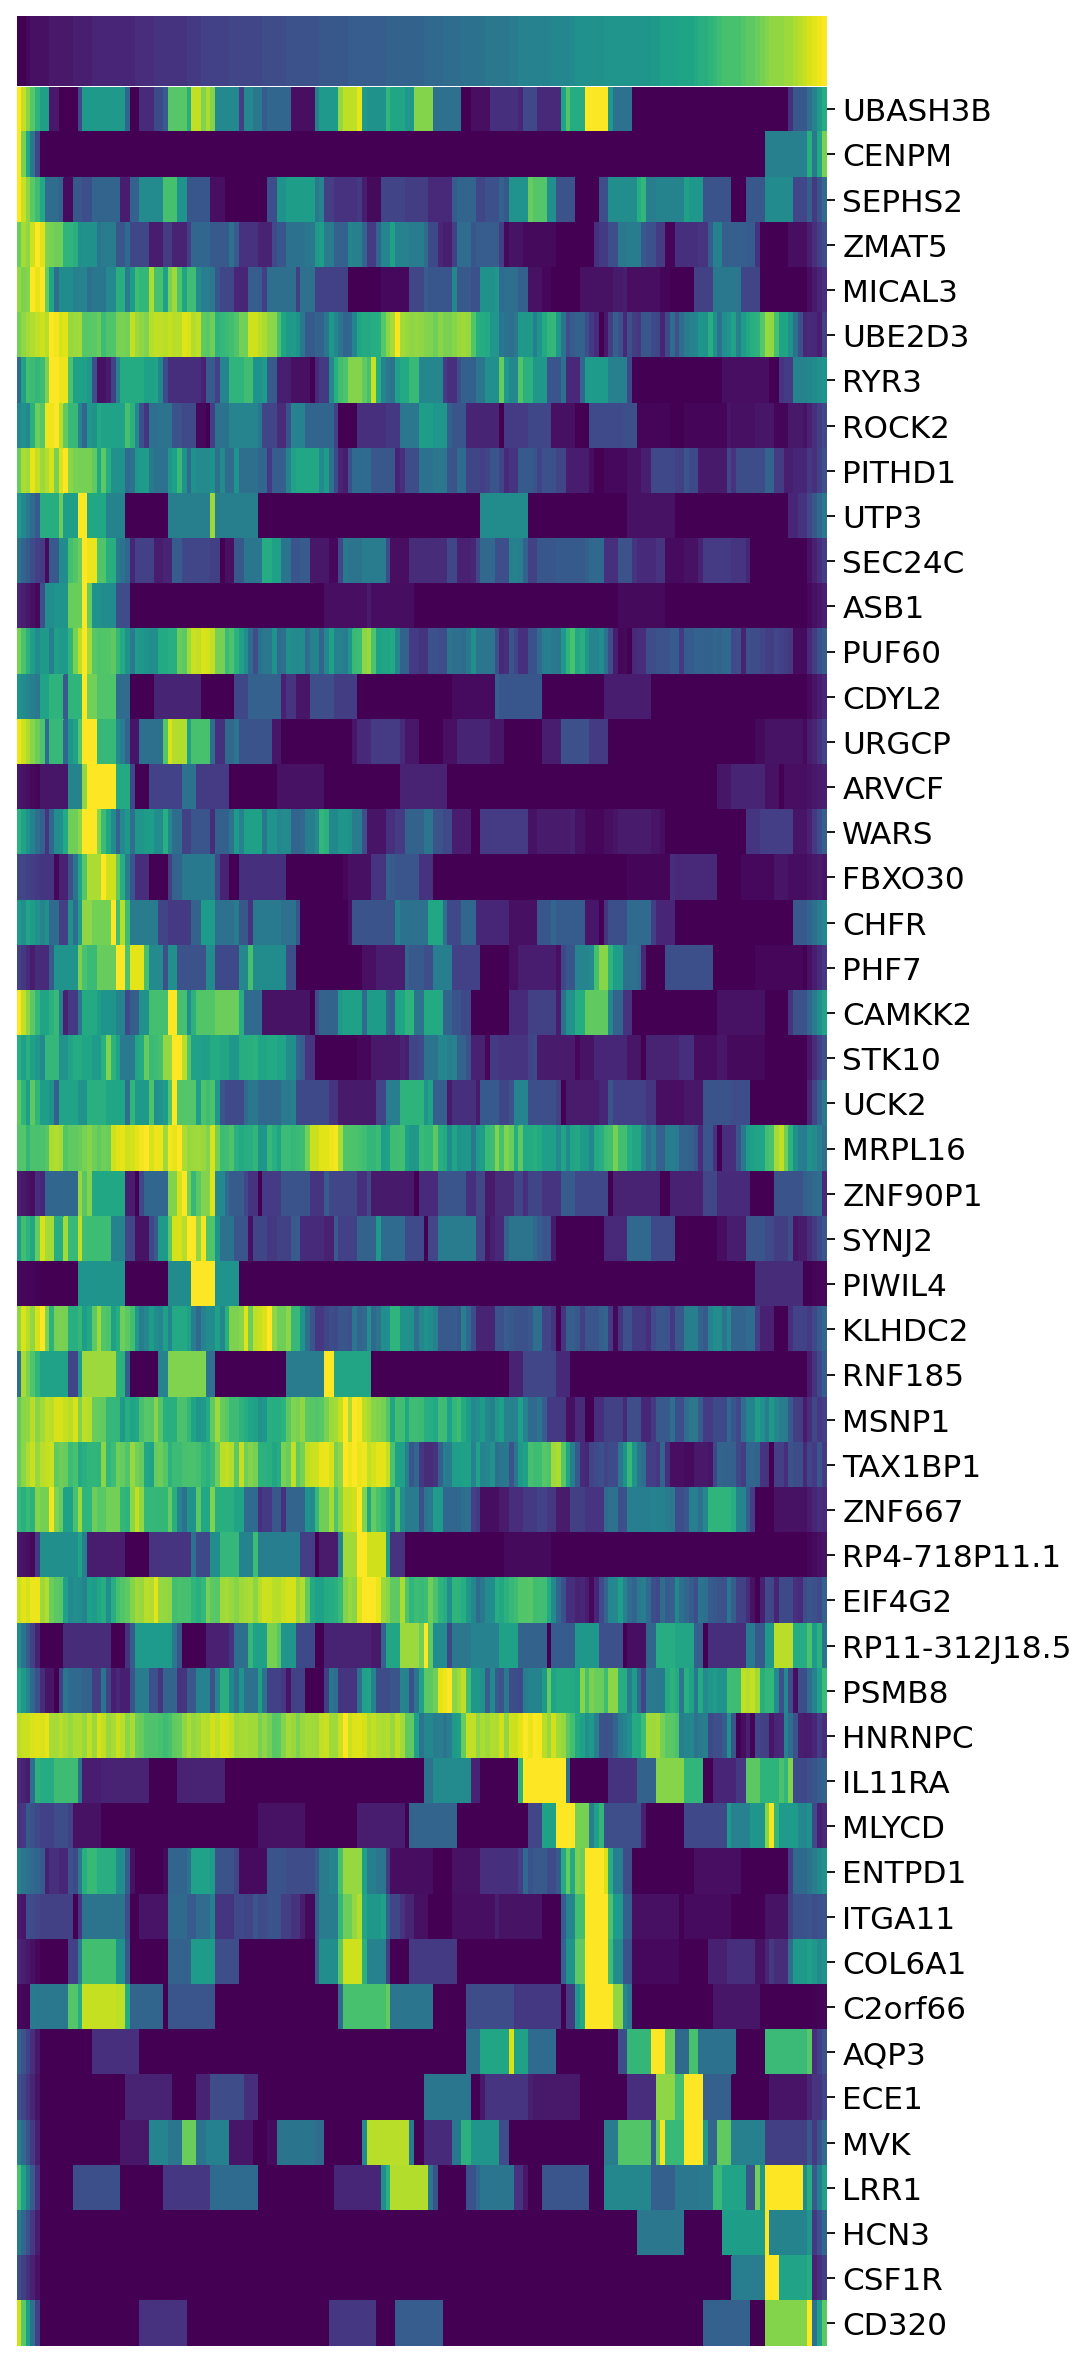

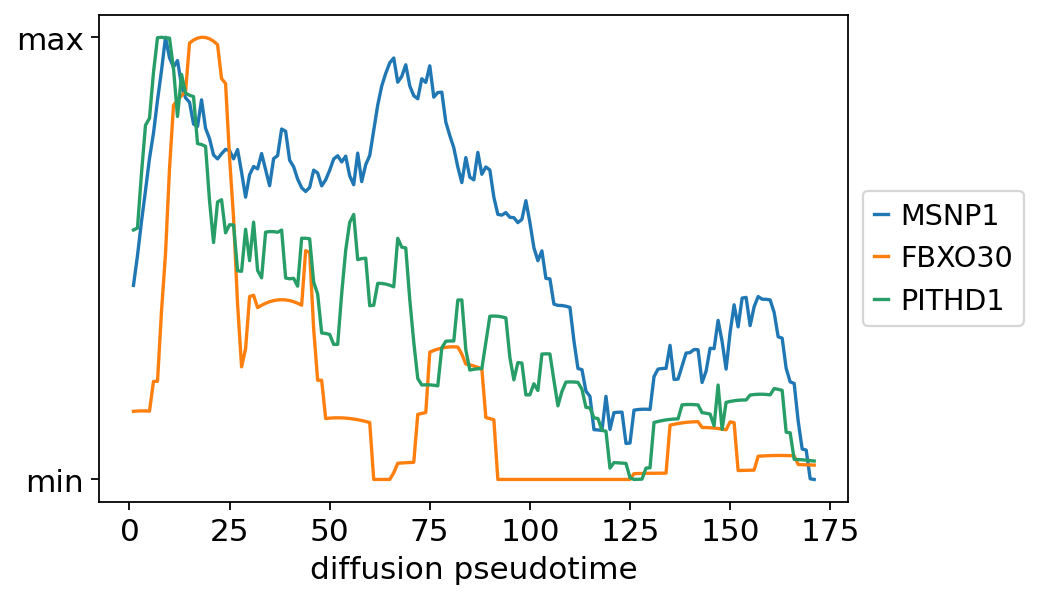

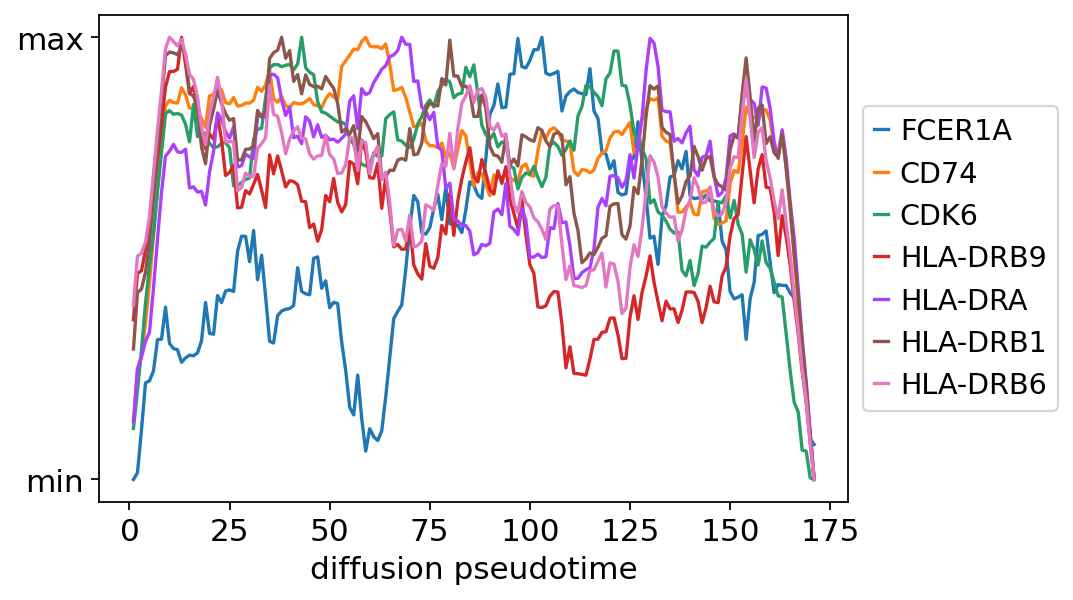

Day3_CD34+


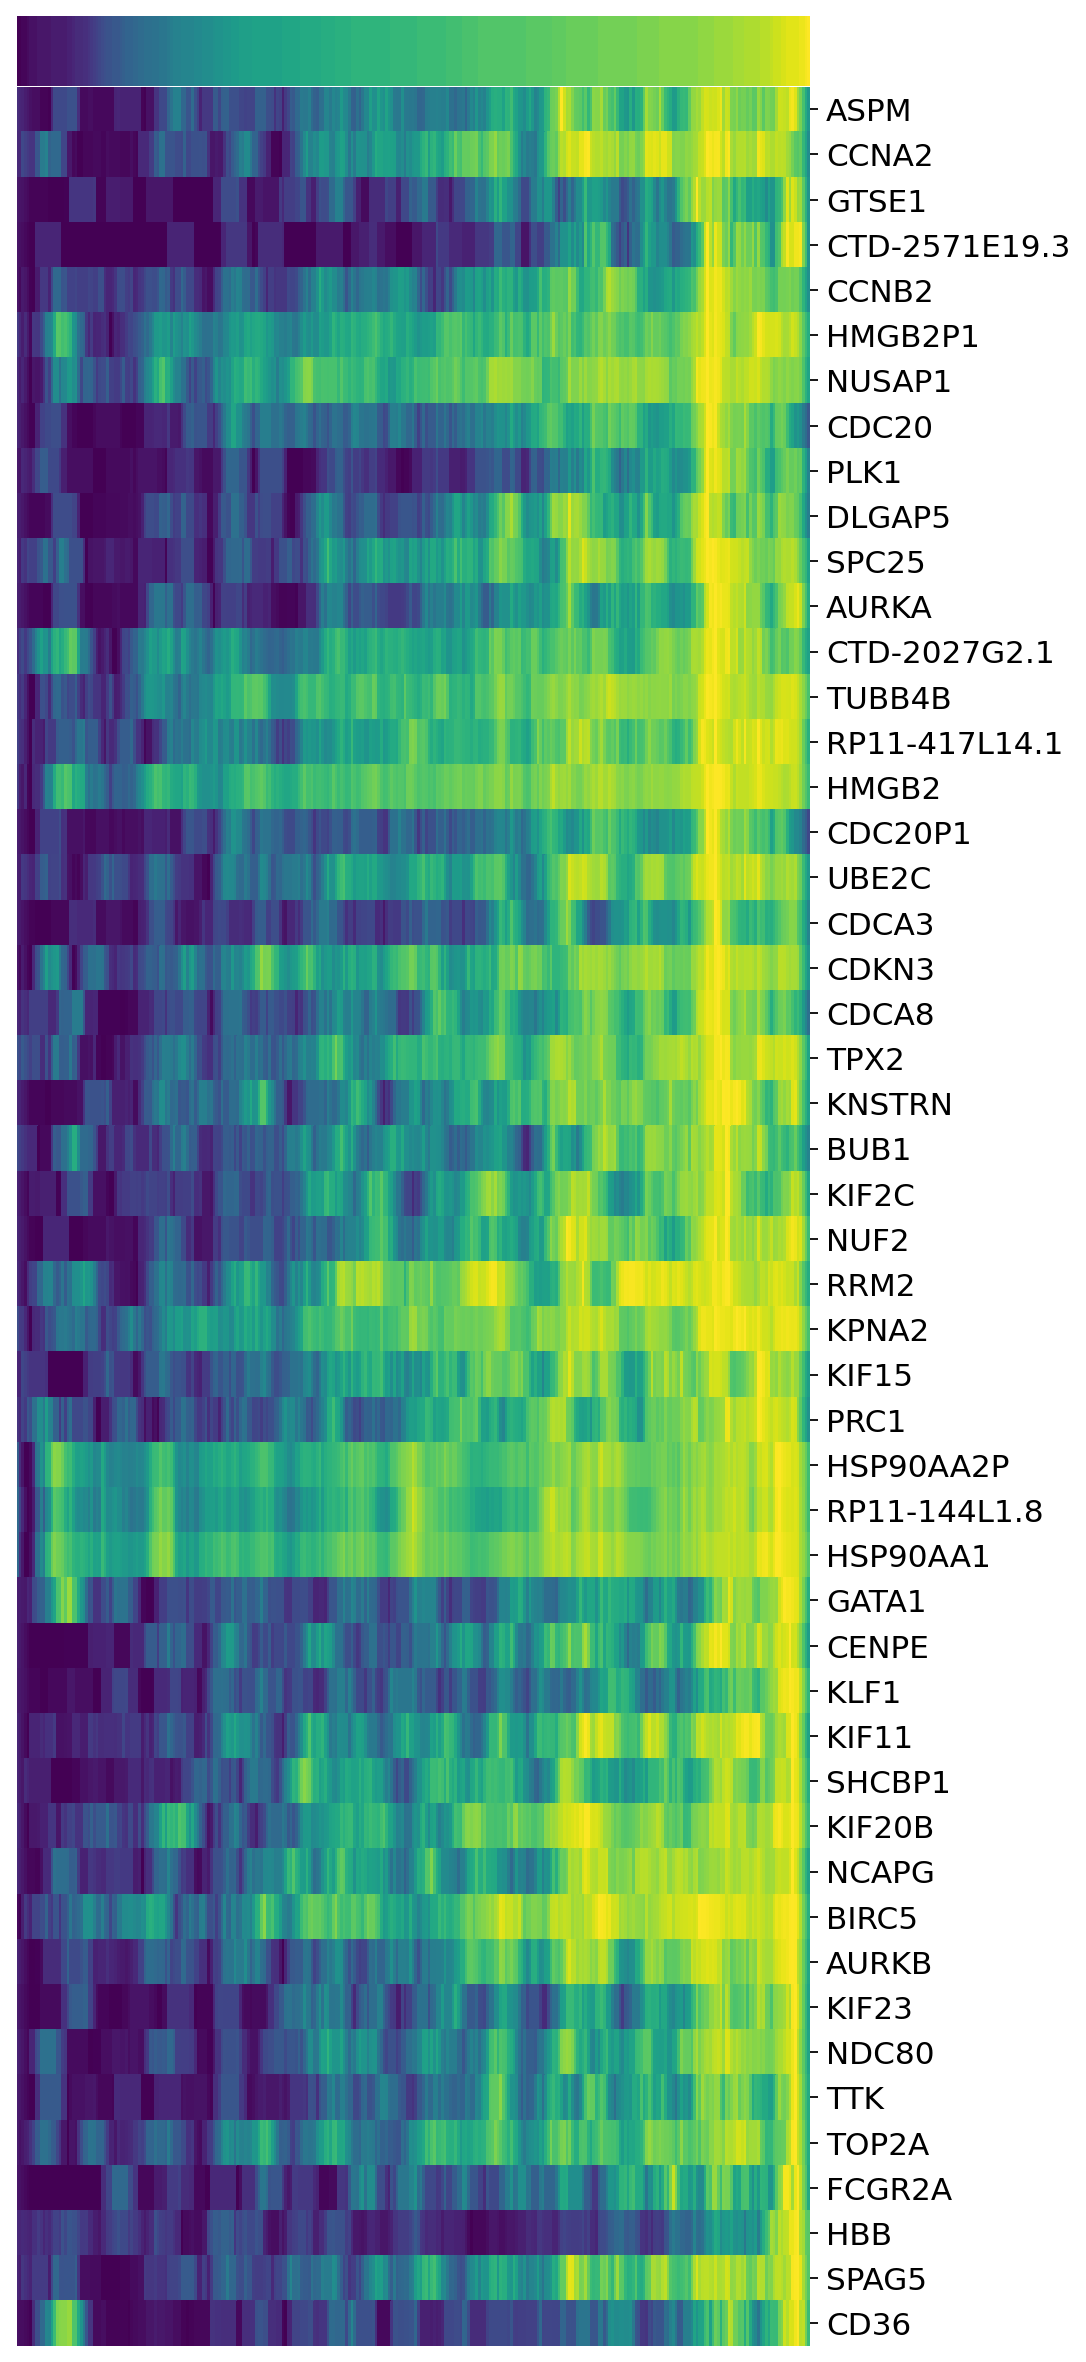

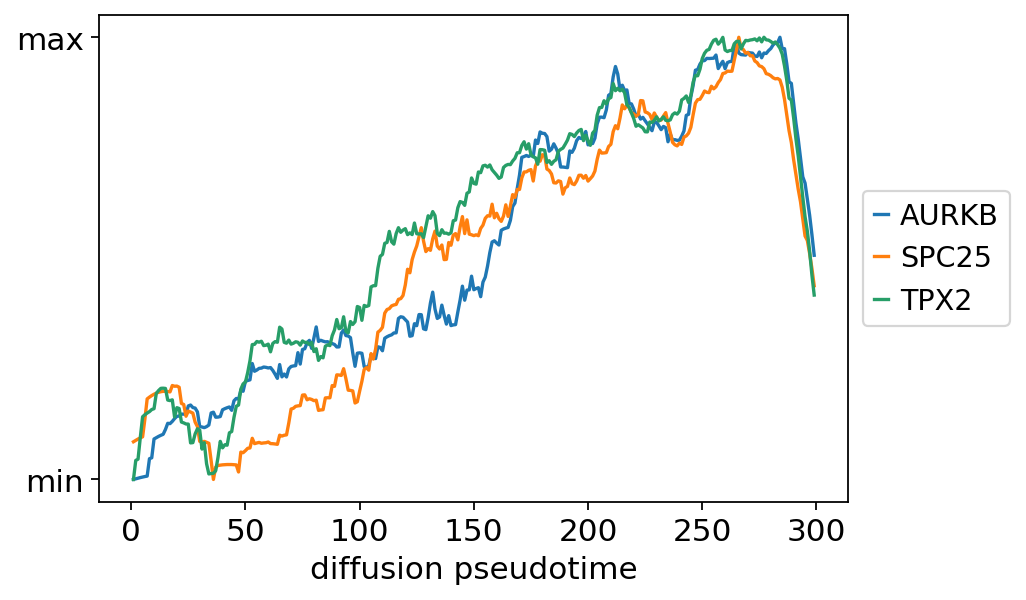

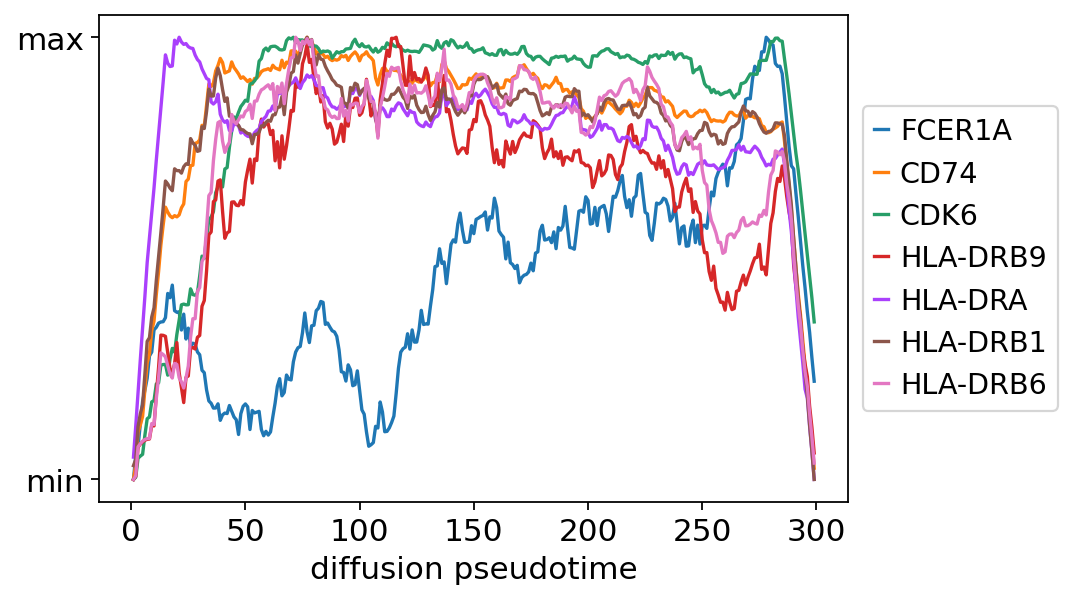

Day3_LT-HSC


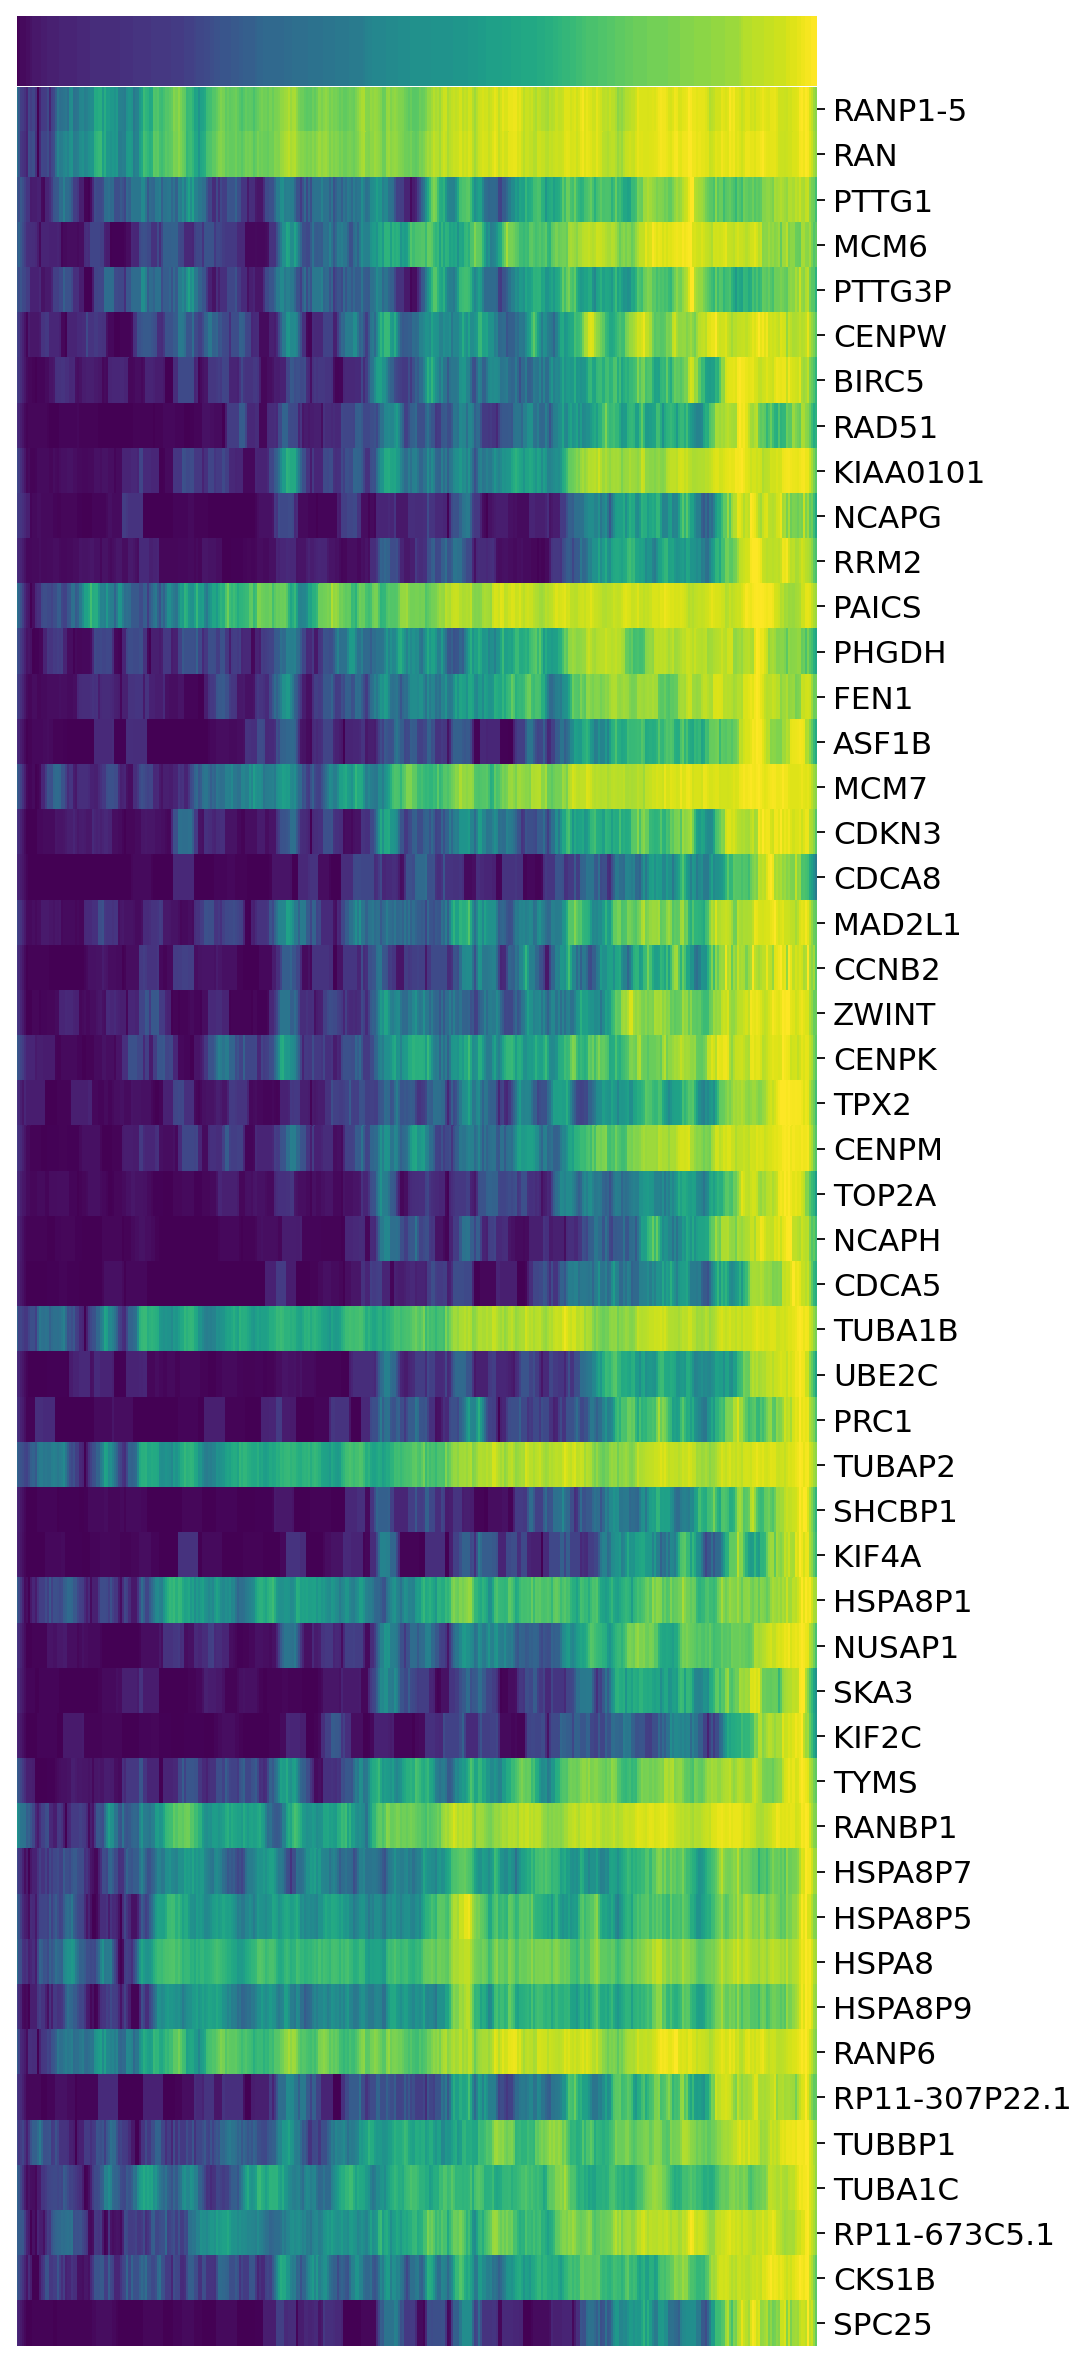

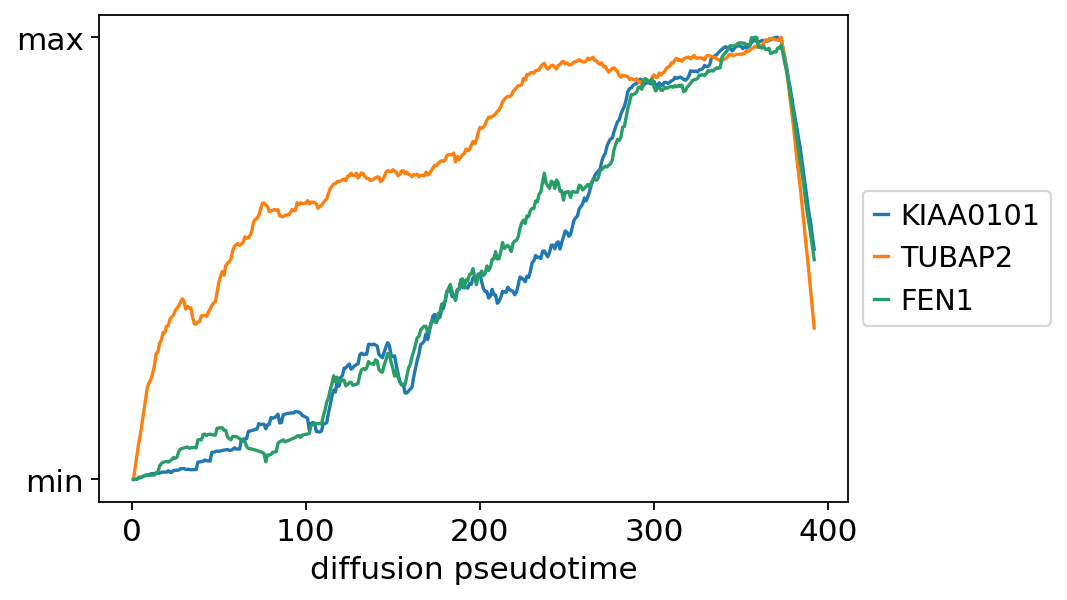

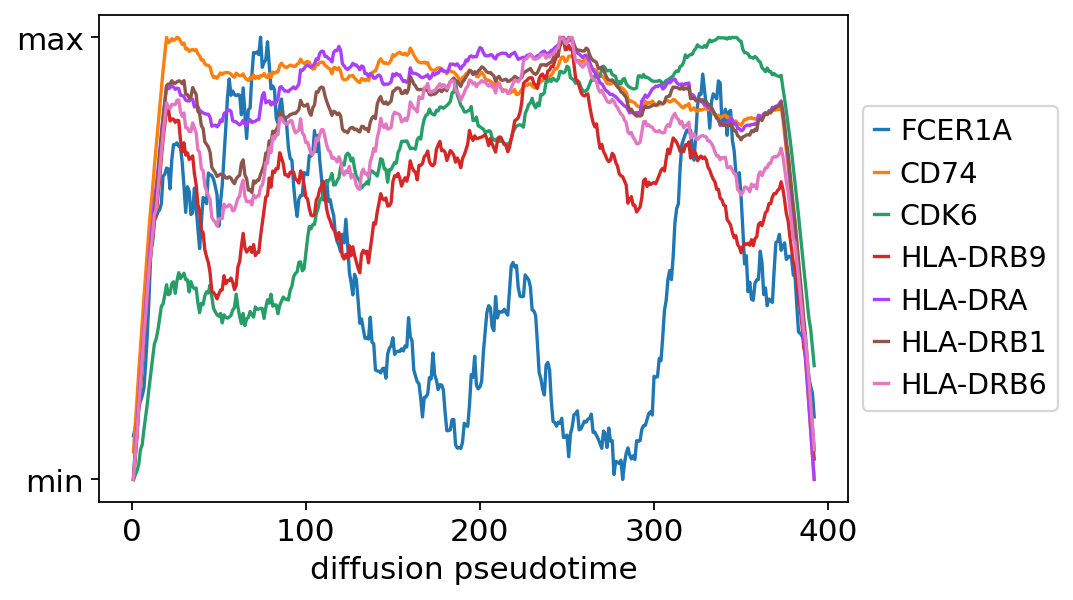

Day3_ST-HSC


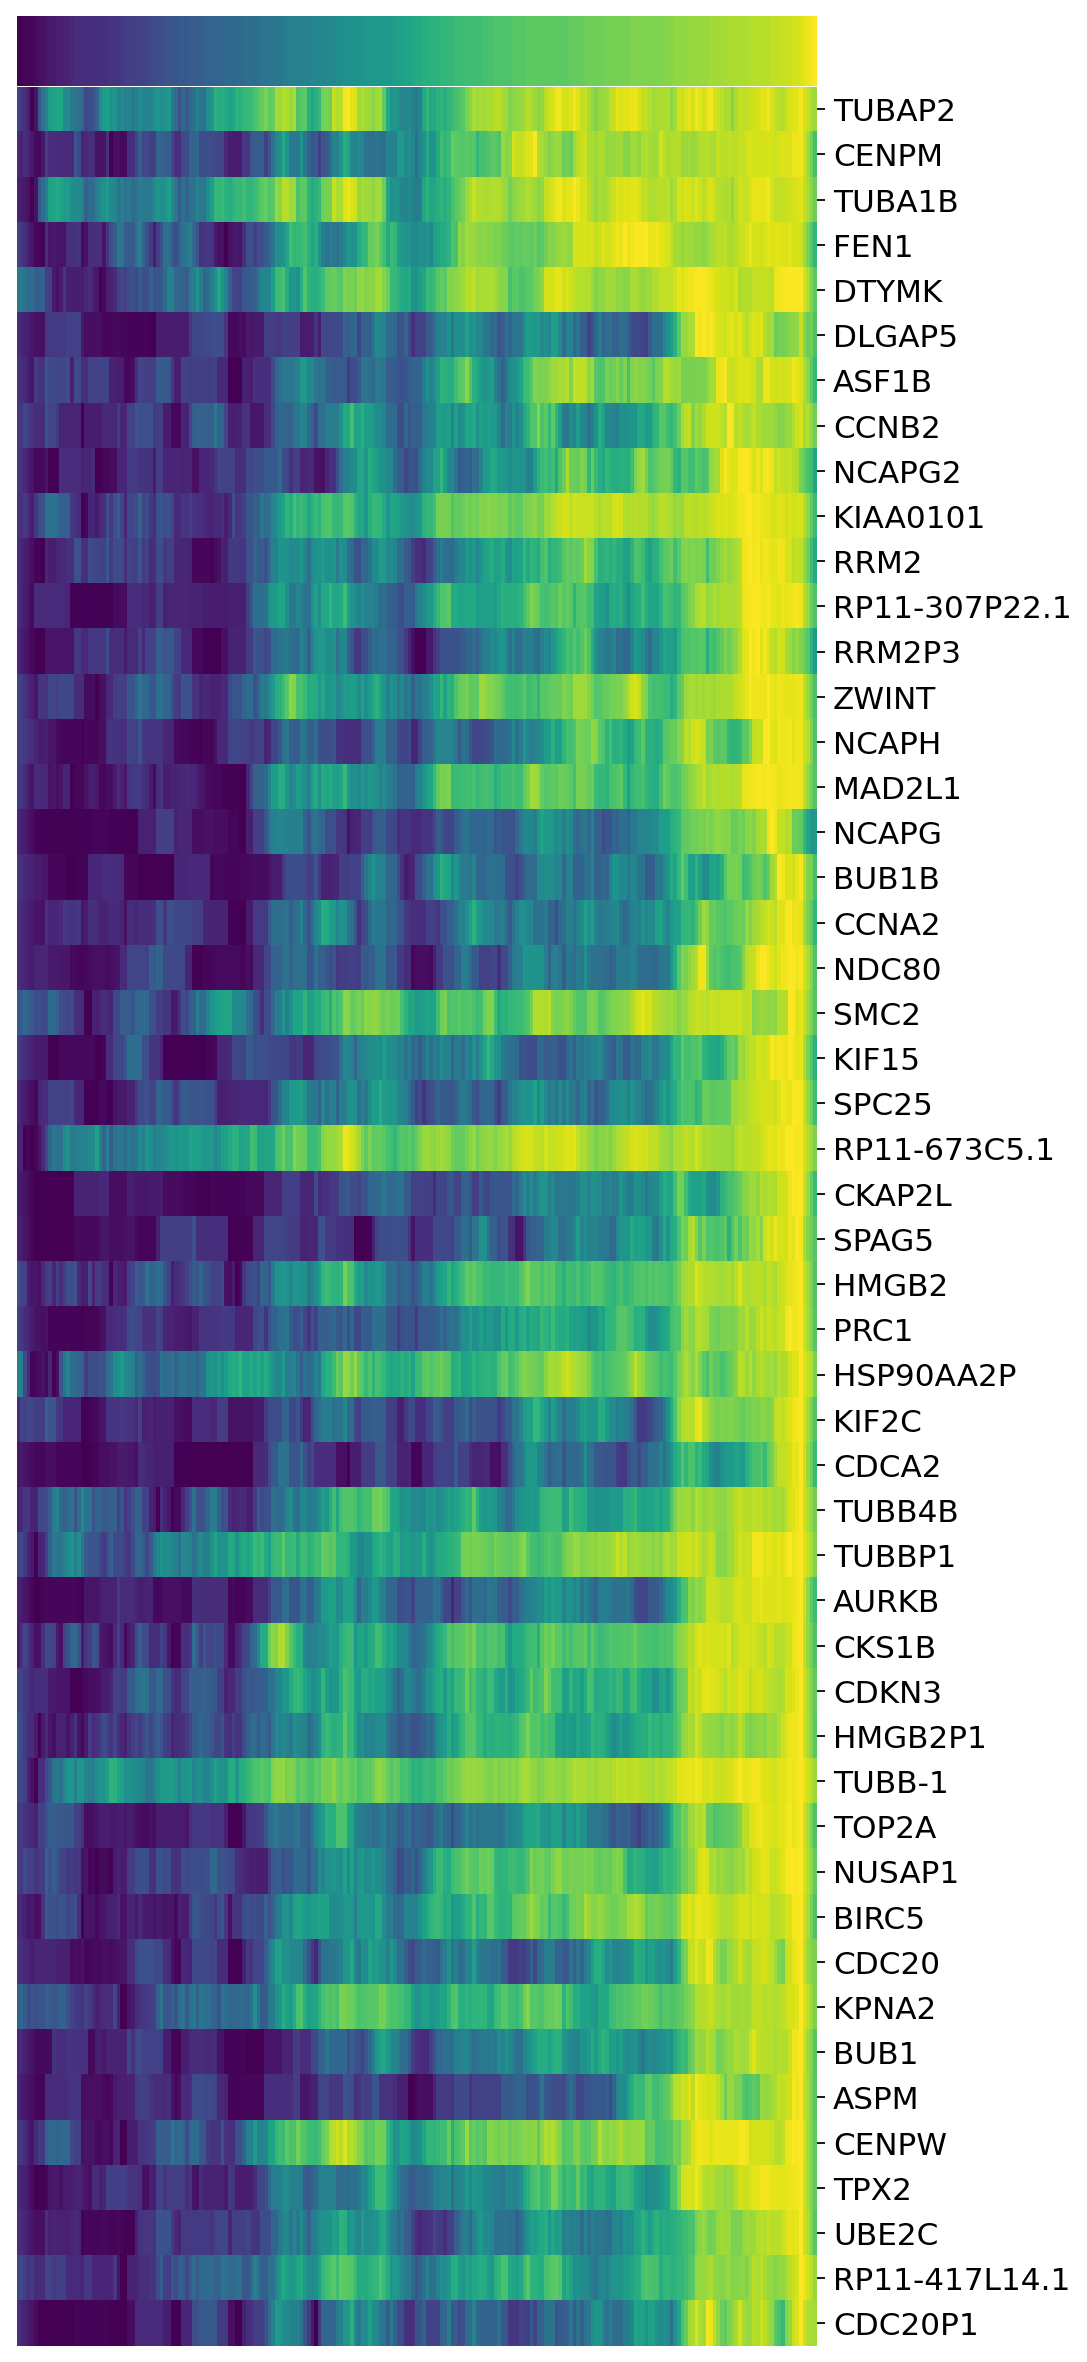

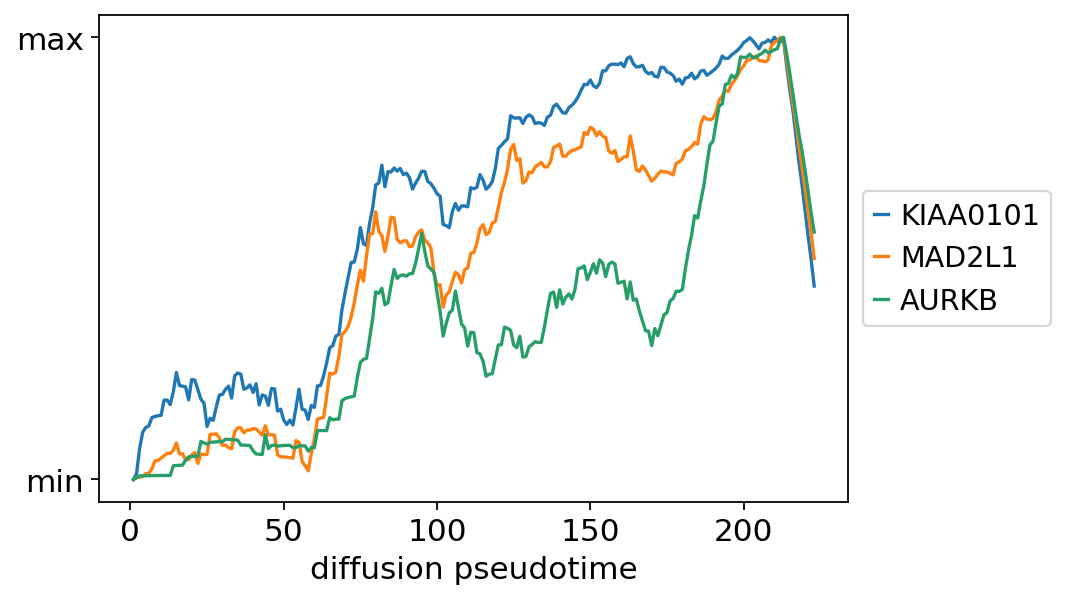

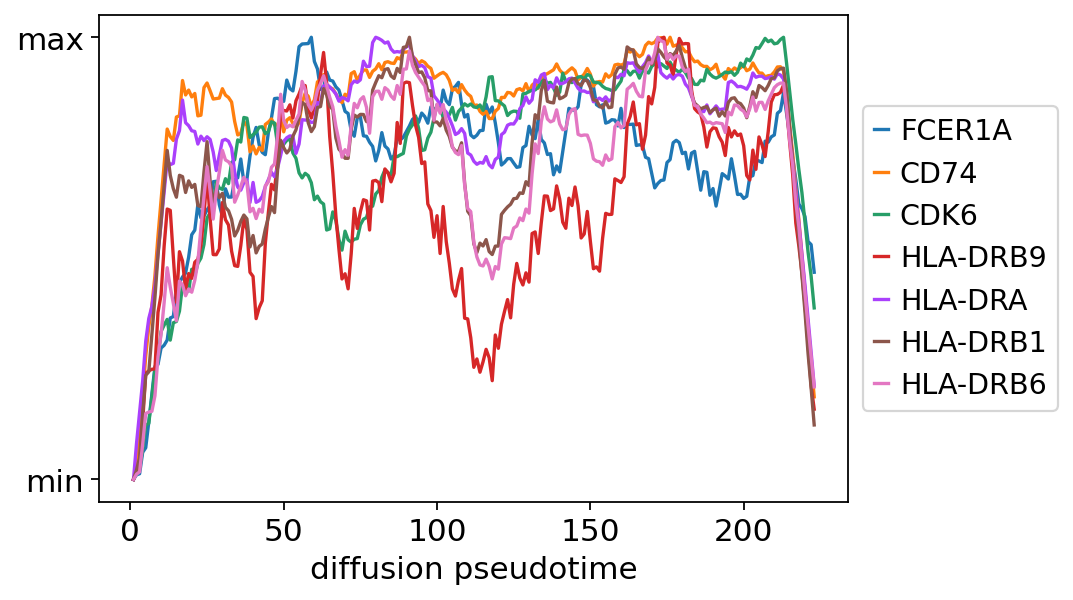

In [84]:
from scipy.stats import rankdata
import scvelo as scv
MPBdata.obs['cond_comb1'] = MPBdata.obs['cond_comb1'].astype('category')
for cond in MPBdata.obs['cond_comb1'].cat.categories:
    print(cond)
    adata_sub = MPBdata[MPBdata.obs['cond_comb1'] == cond].copy()
    adata_sub.obs['pt_rank'] = rankdata(adata_sub.obs['dpt_pseudotime'])
    DEgene_pt = smqpp.GeneExp_LLR_test(adata_sub, alt_obs=['pt_rank', 'n_genes', 'batch'], useHVG=True, null_obs=['n_genes', 'batch'])

    scv.pl.heatmap(adata_sub, var_names=DEgene_pt.index[0:50], tkey='pt_rank', n_convolve=10, col_color='dpt_pseudotime', figsize=(7,15), yticklabels=True)
    smqpp.plot_genes_along_pt(adata_sub, genes=DEgene_pt.index[0:3], sigma=20, pt_obs='pt_rank')
    GL1 = ['FCER1A', 'CD74', 'CDK6',  
           'HLA-DRB9', 'HLA-DRA', 'HLA-DRB1', 
          'HLA-DRB6']
    smqpp.plot_genes_along_pt(adata_sub, genes=GL1, sigma=20, pt_obs='pt_rank')

Day0_CD34+


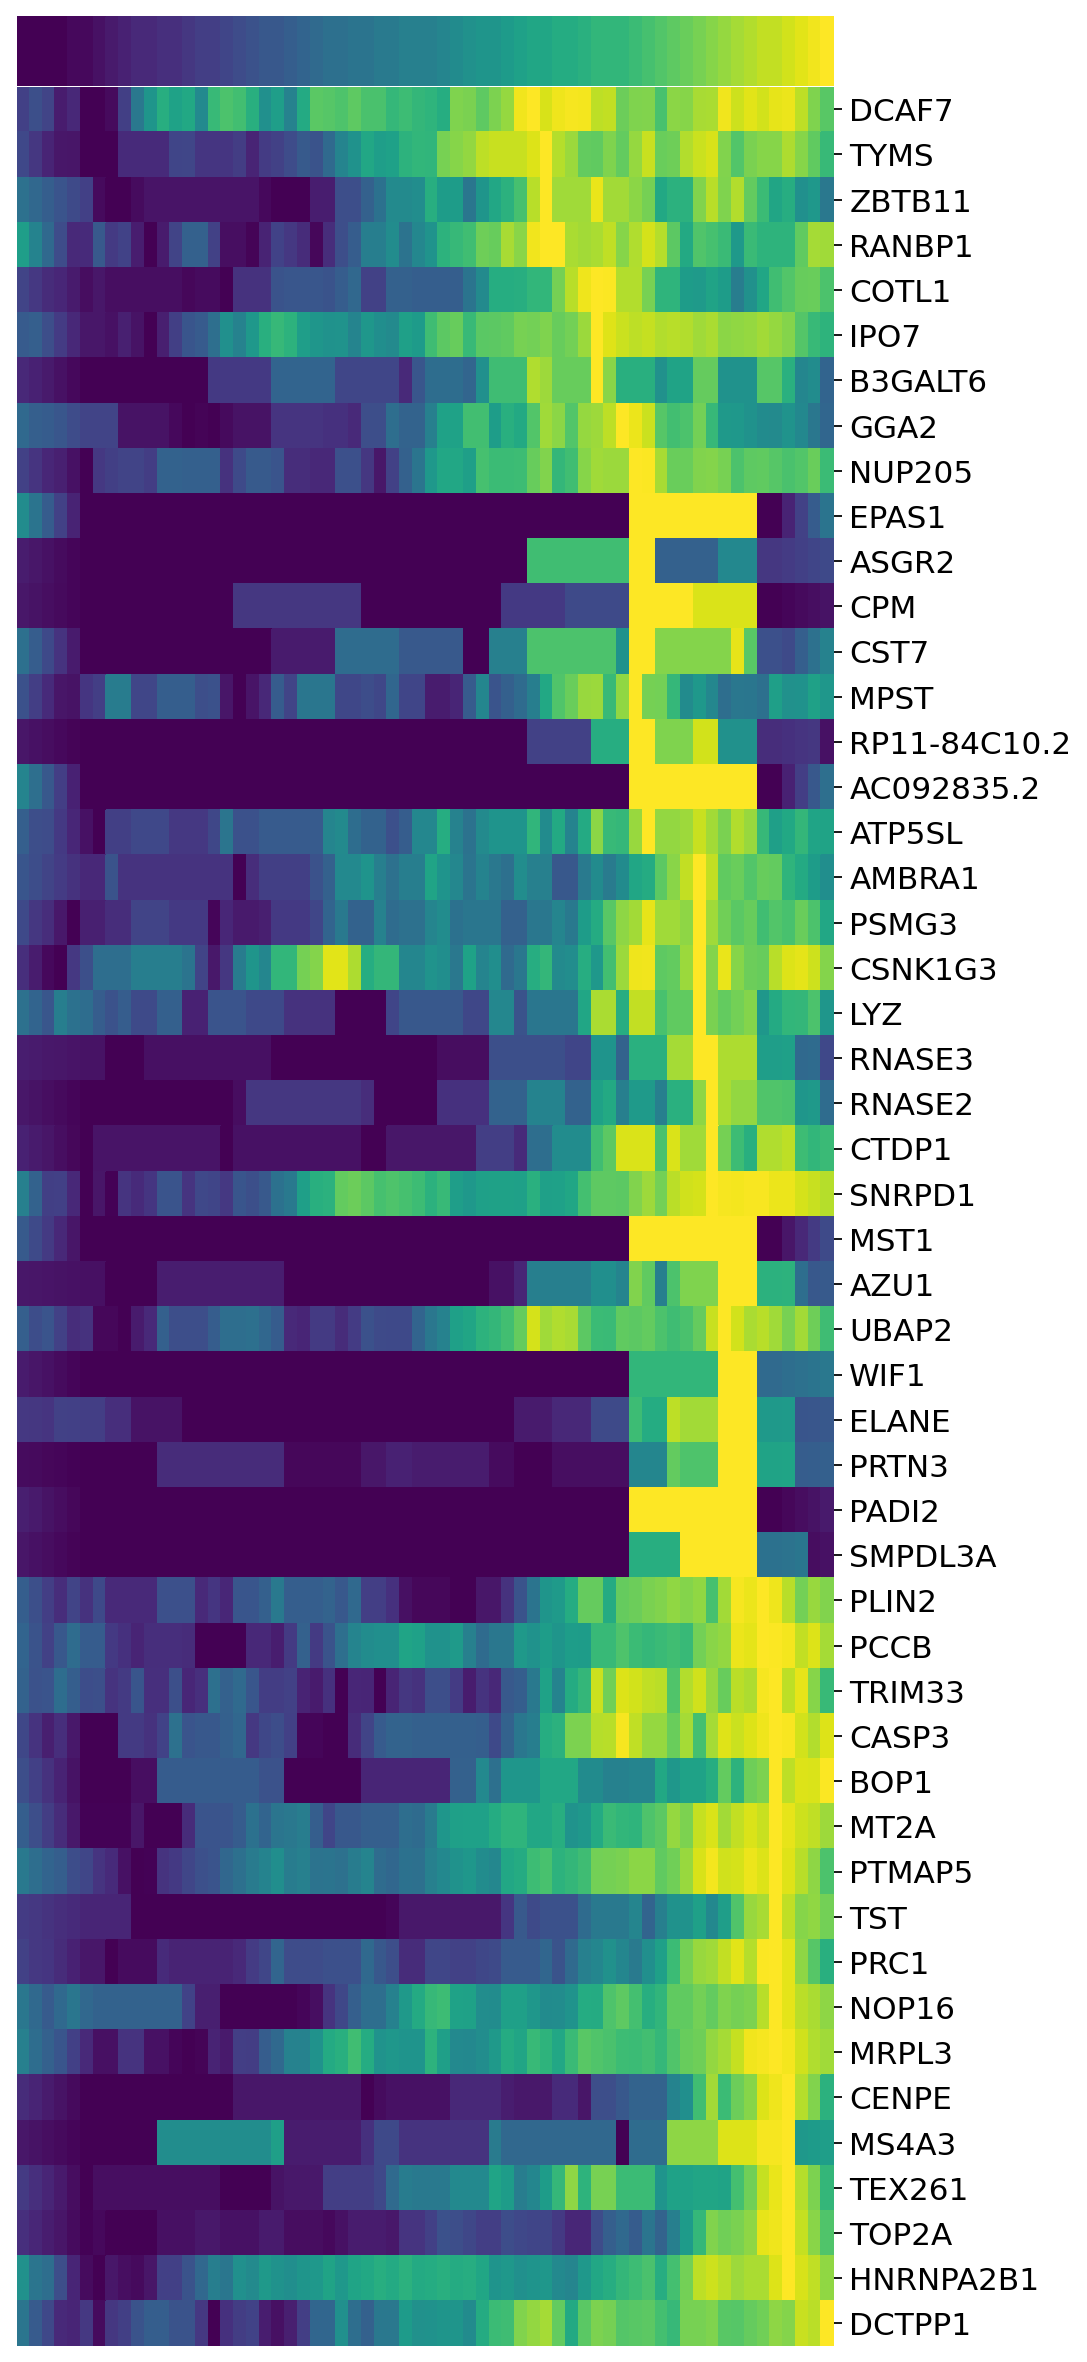

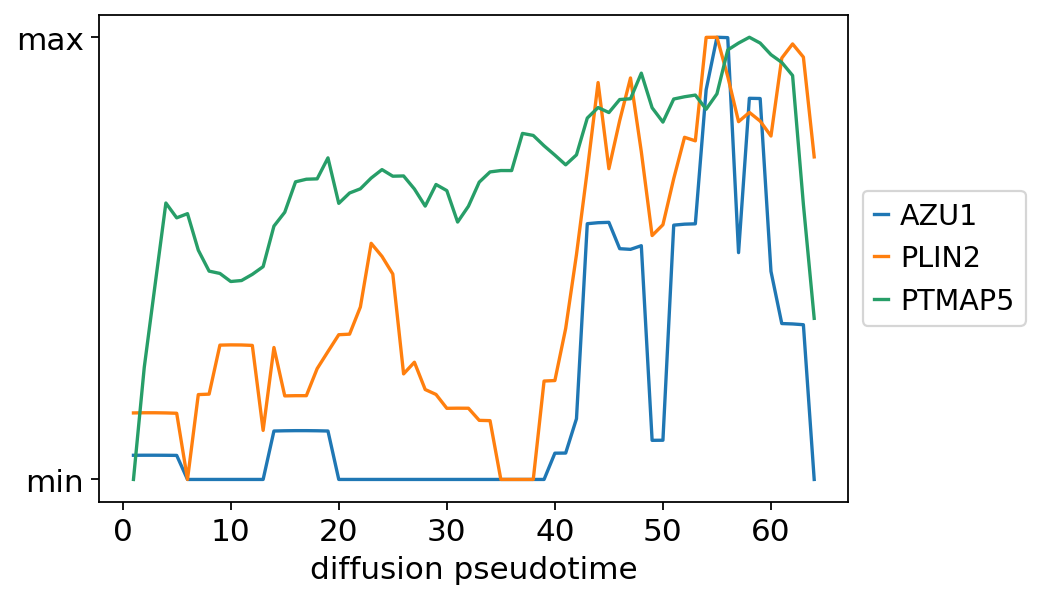

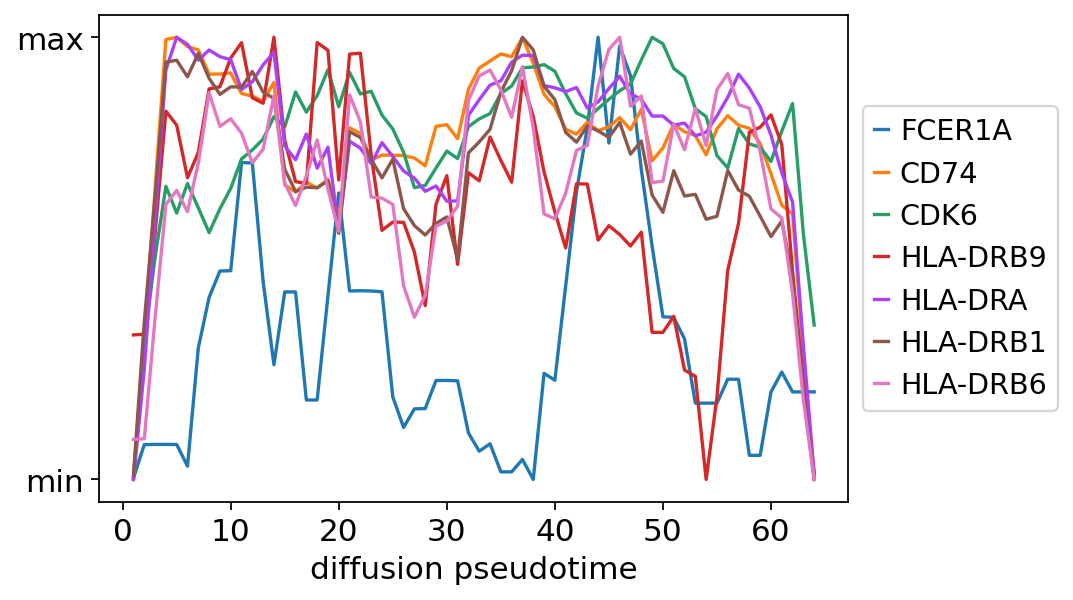

Day0_LT-HSC


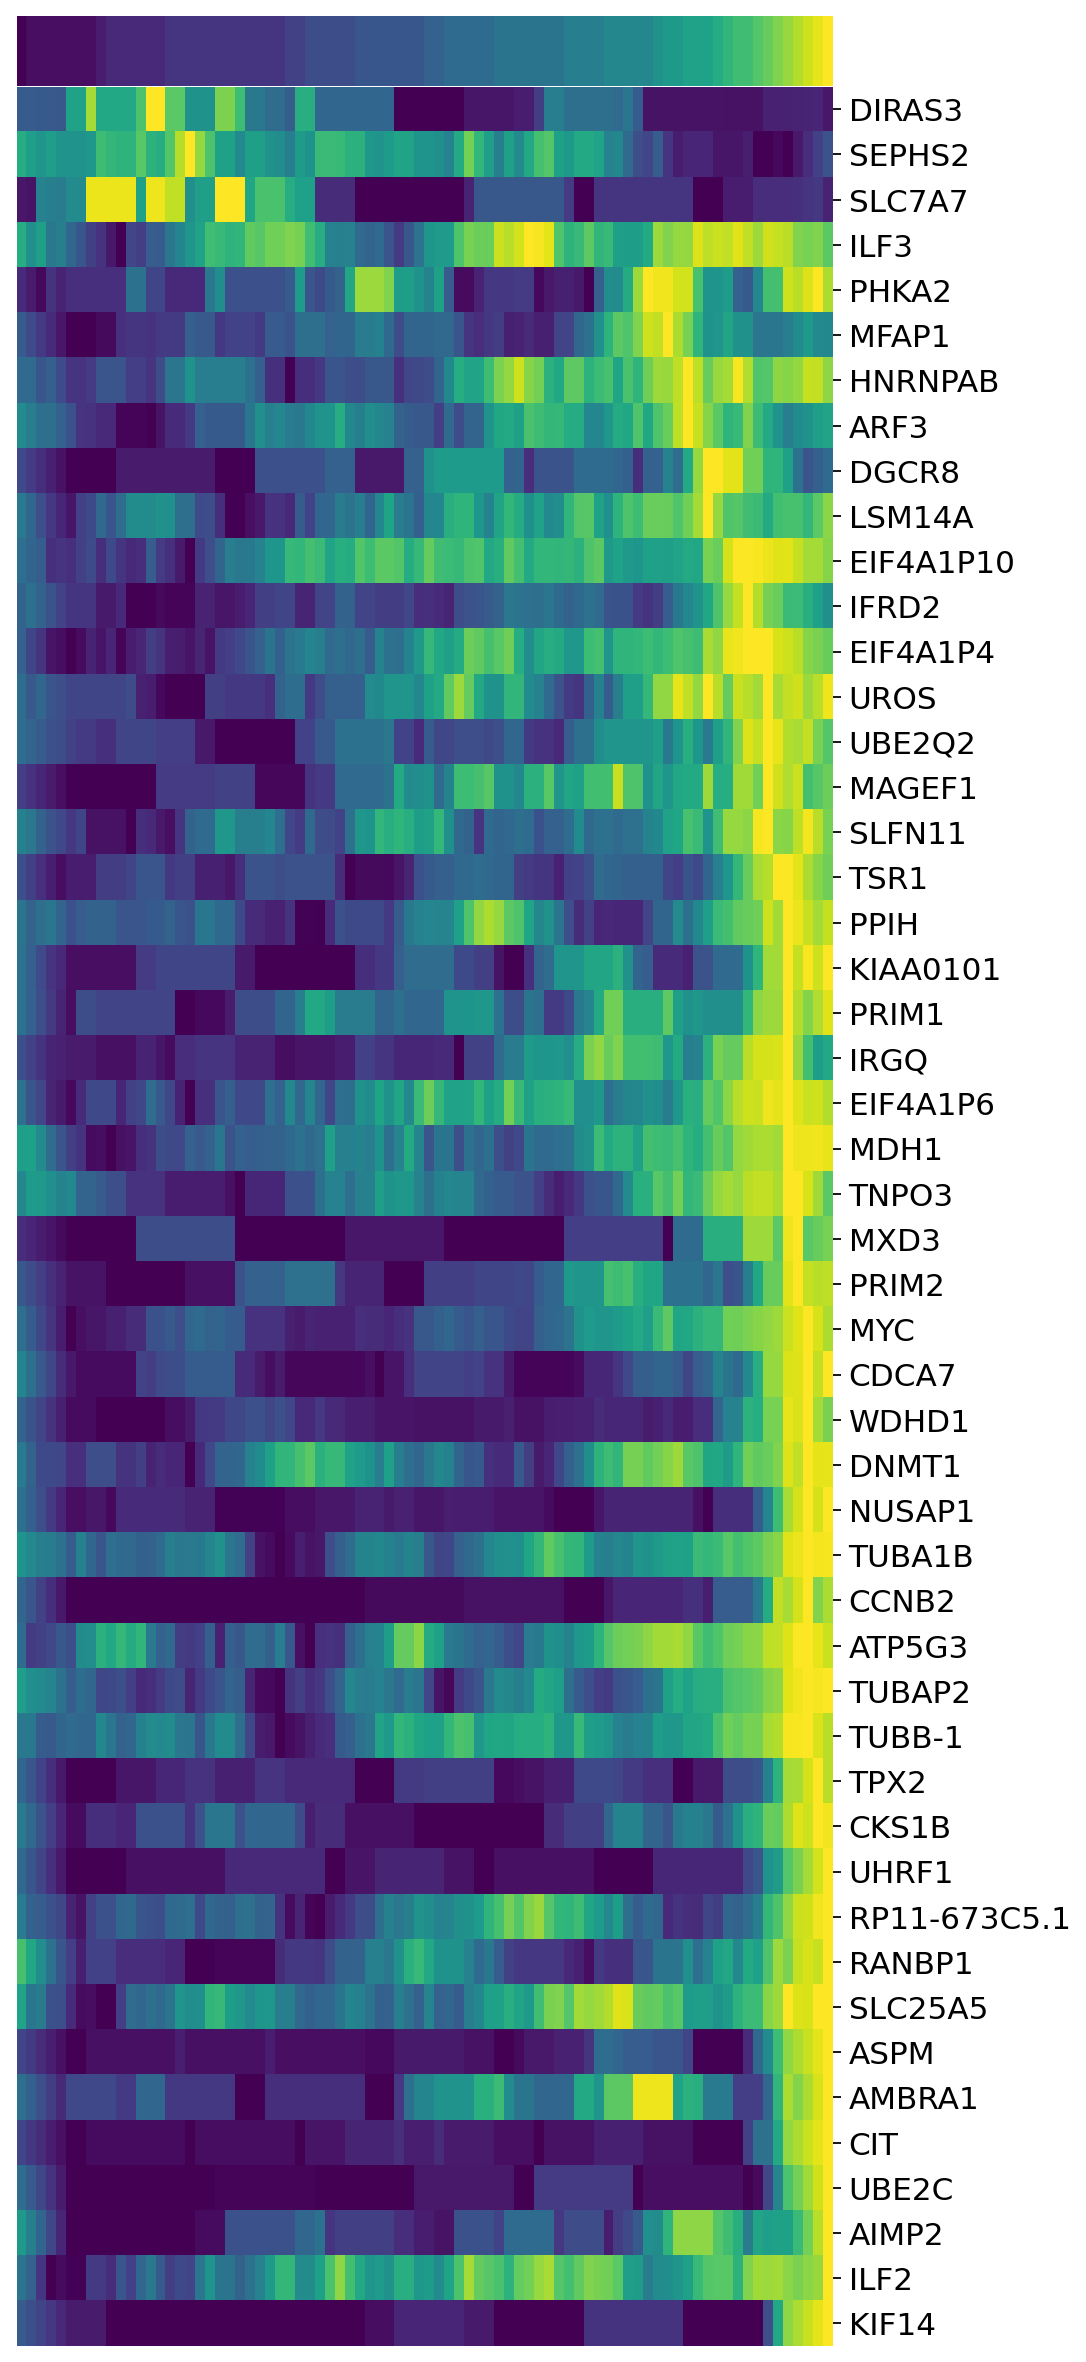

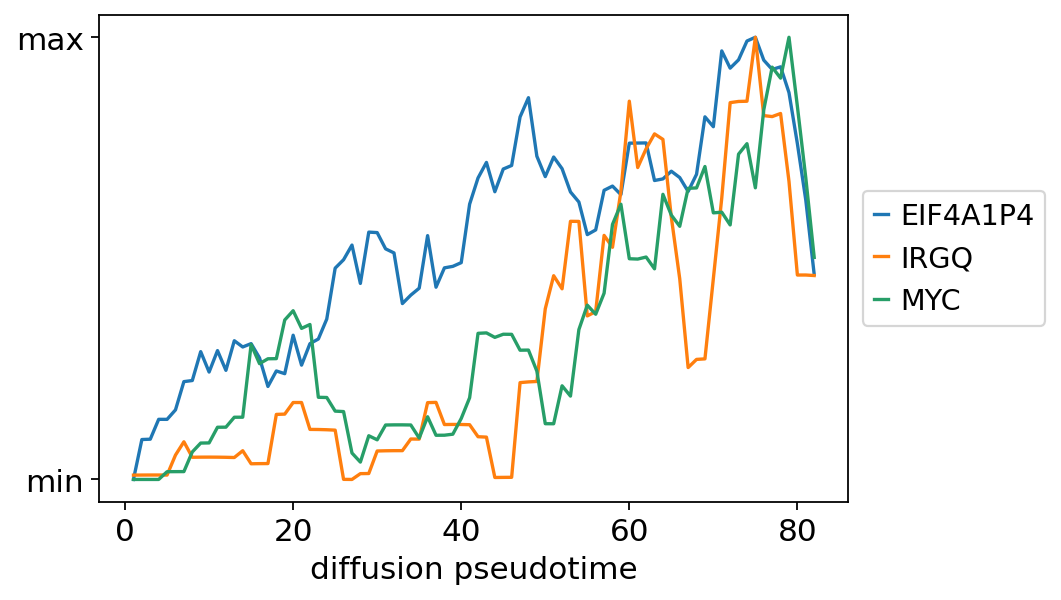

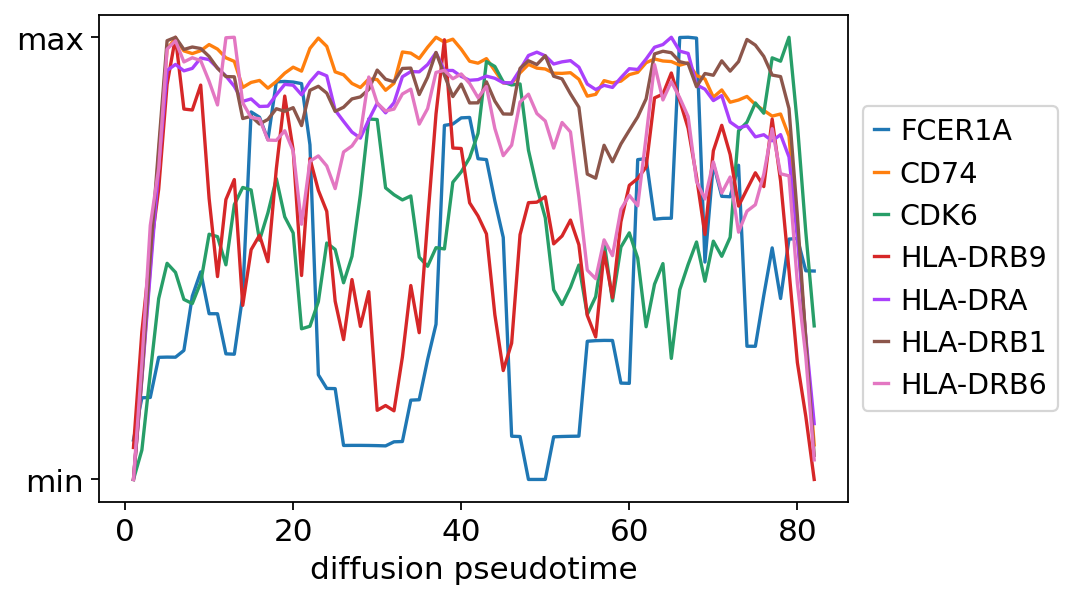

Day0_ST-HSC


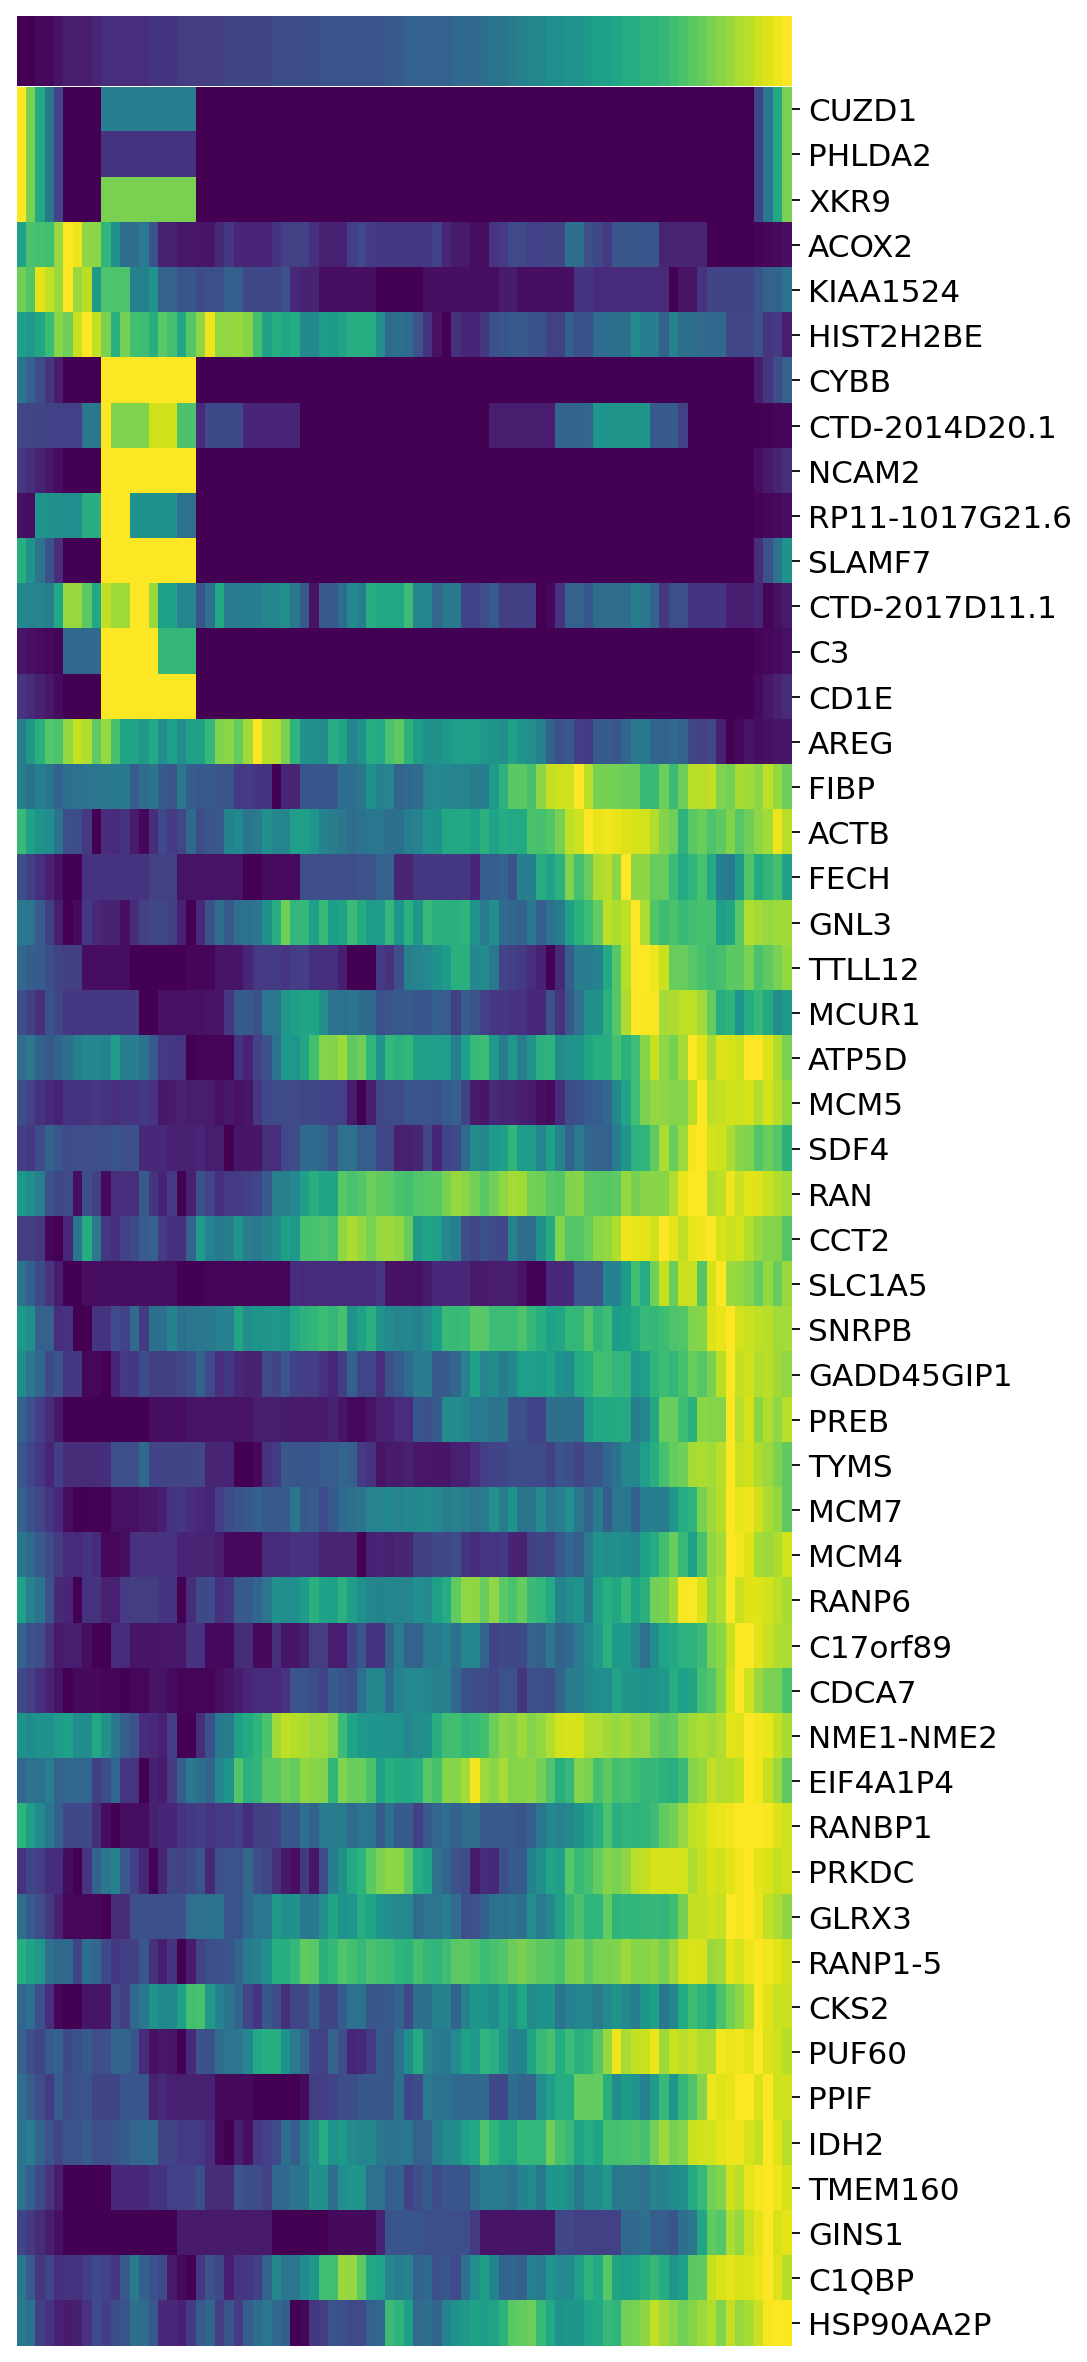

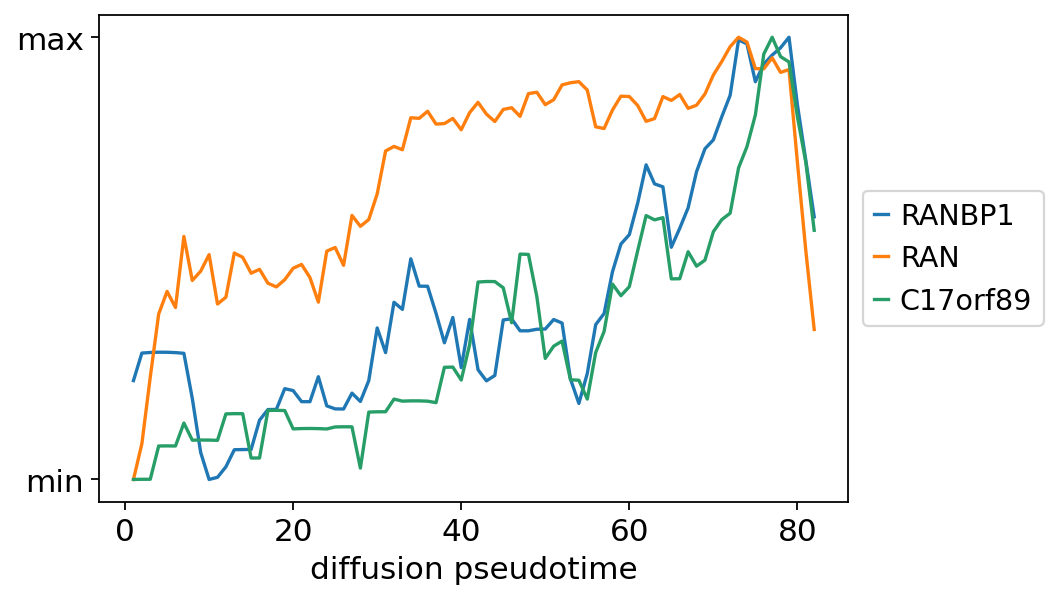

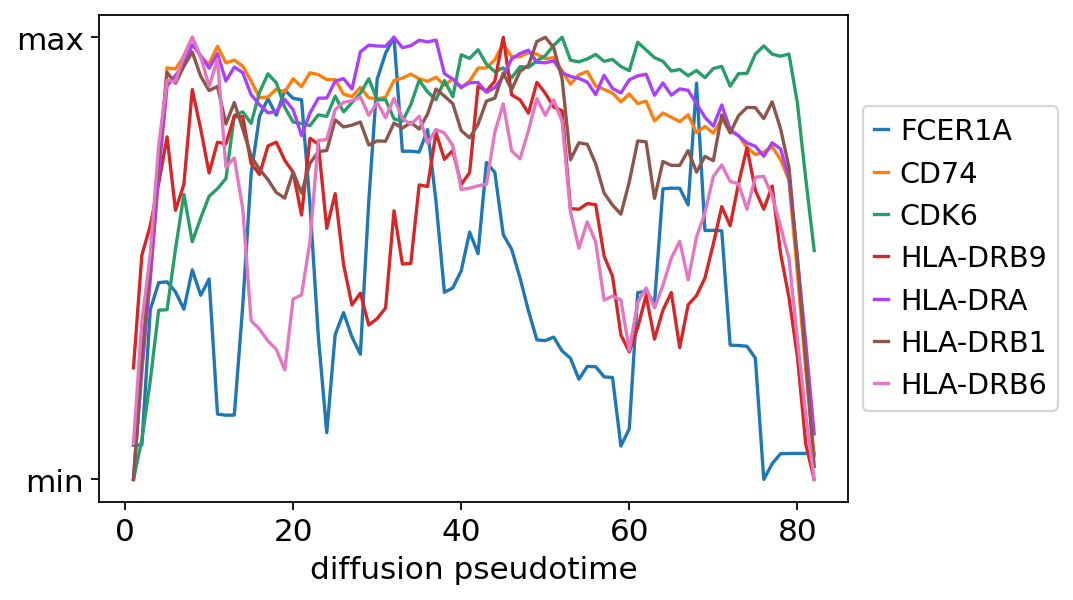

Day3_CD34+


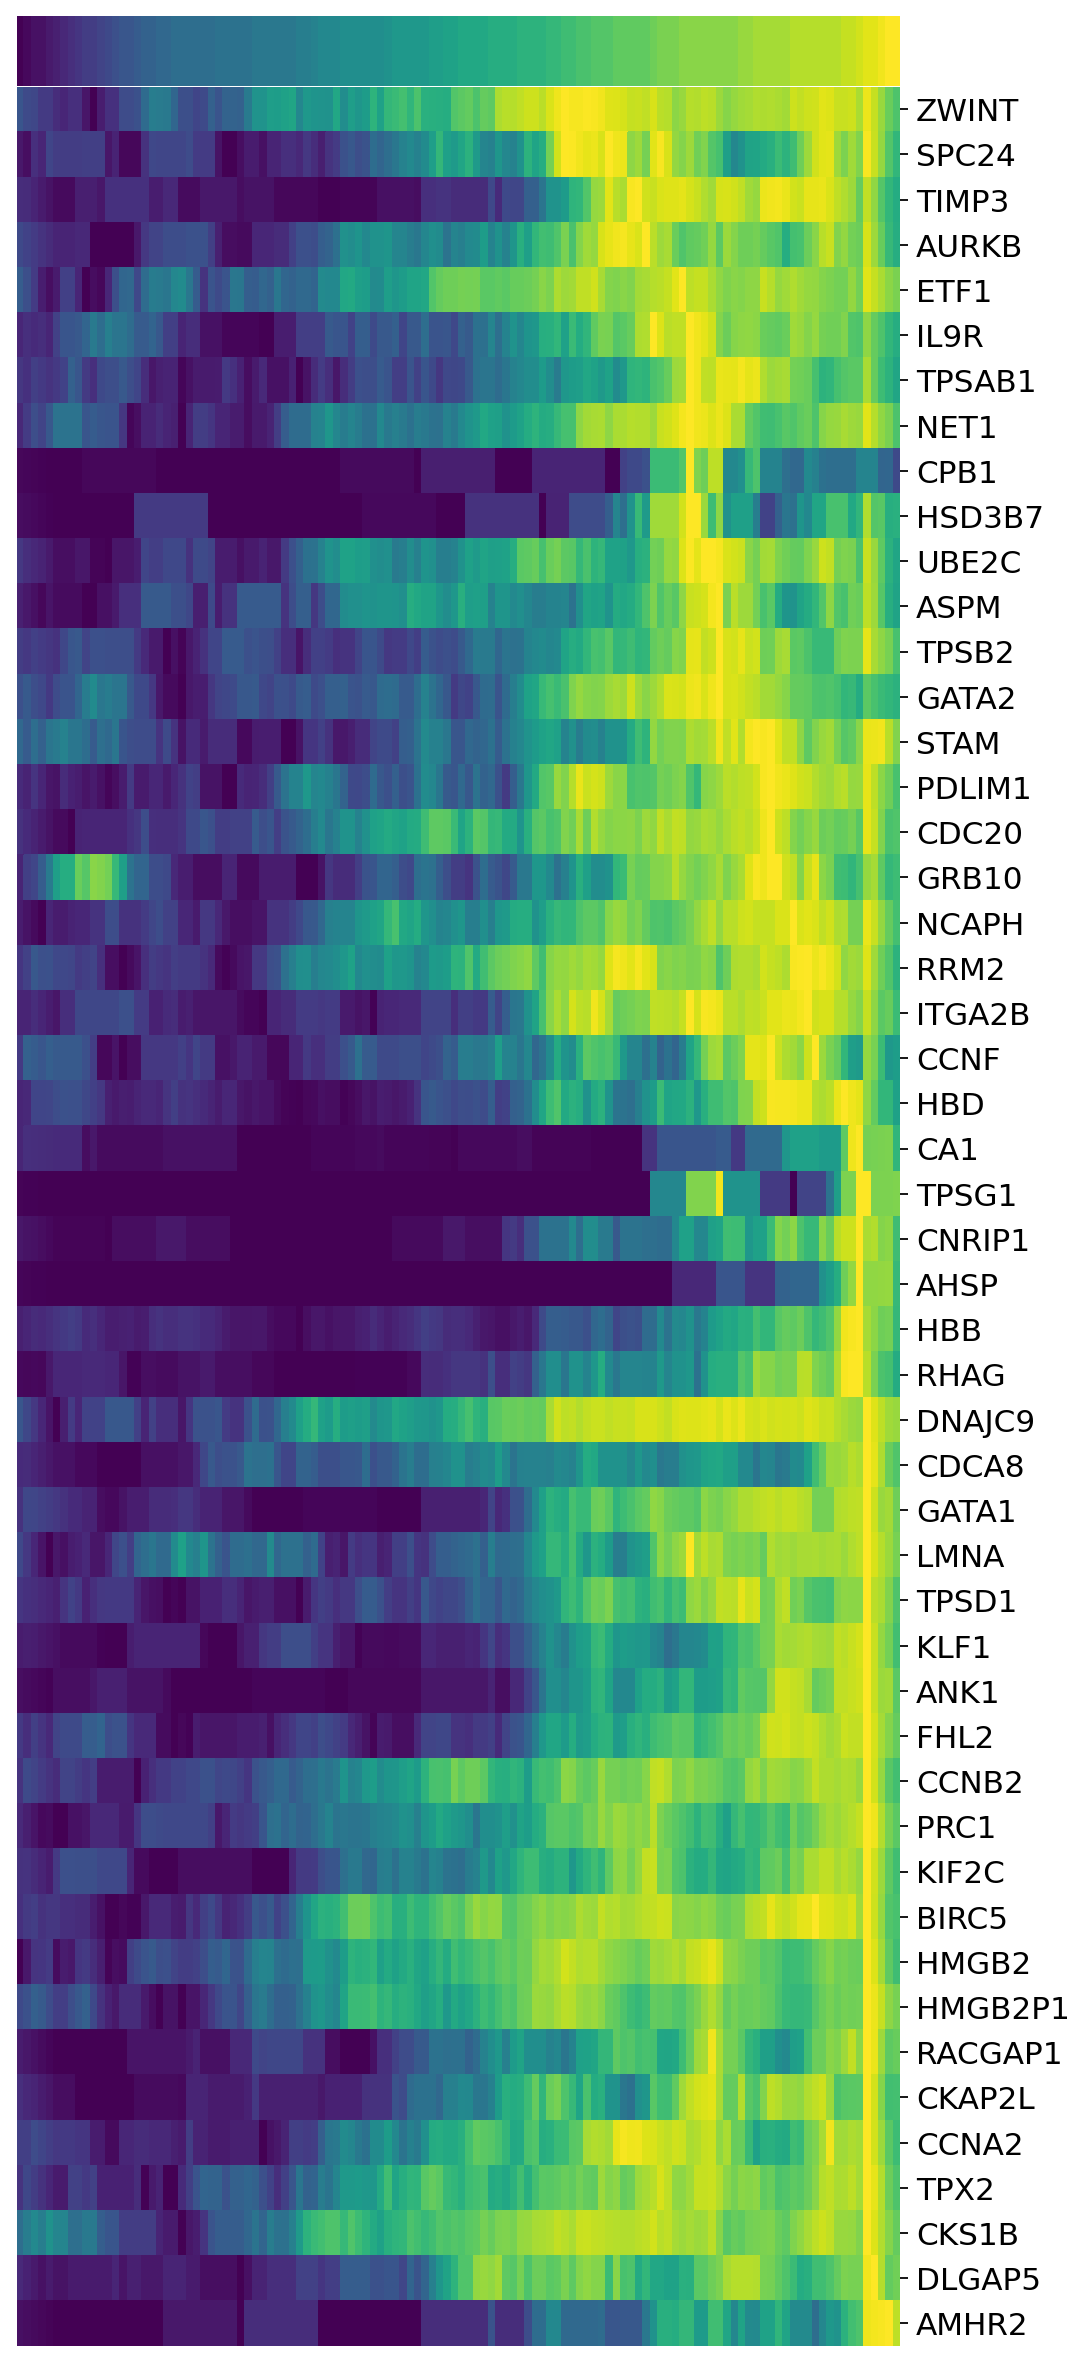

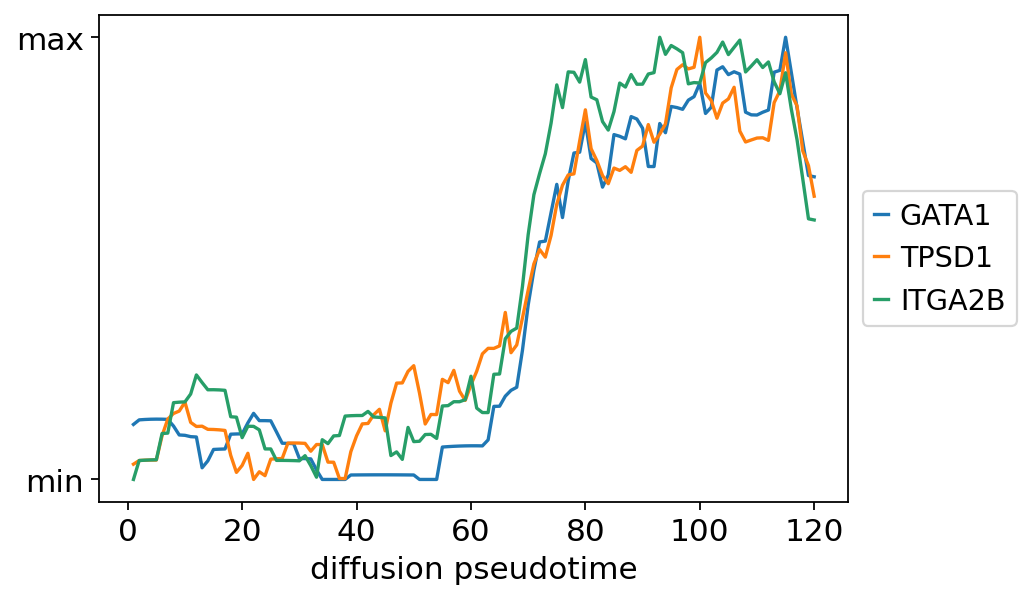

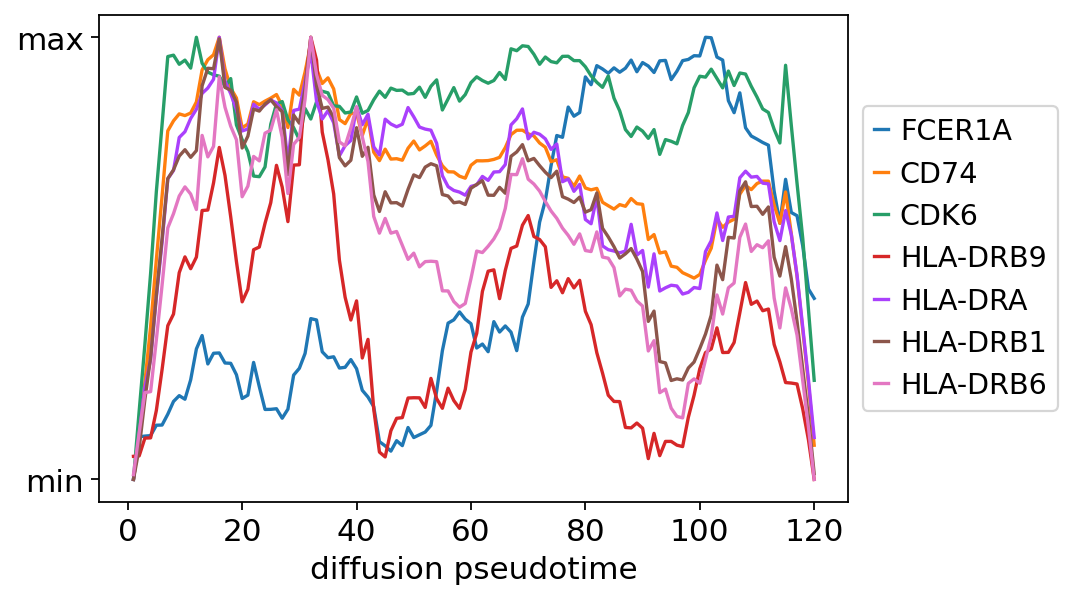

Day3_LT-HSC


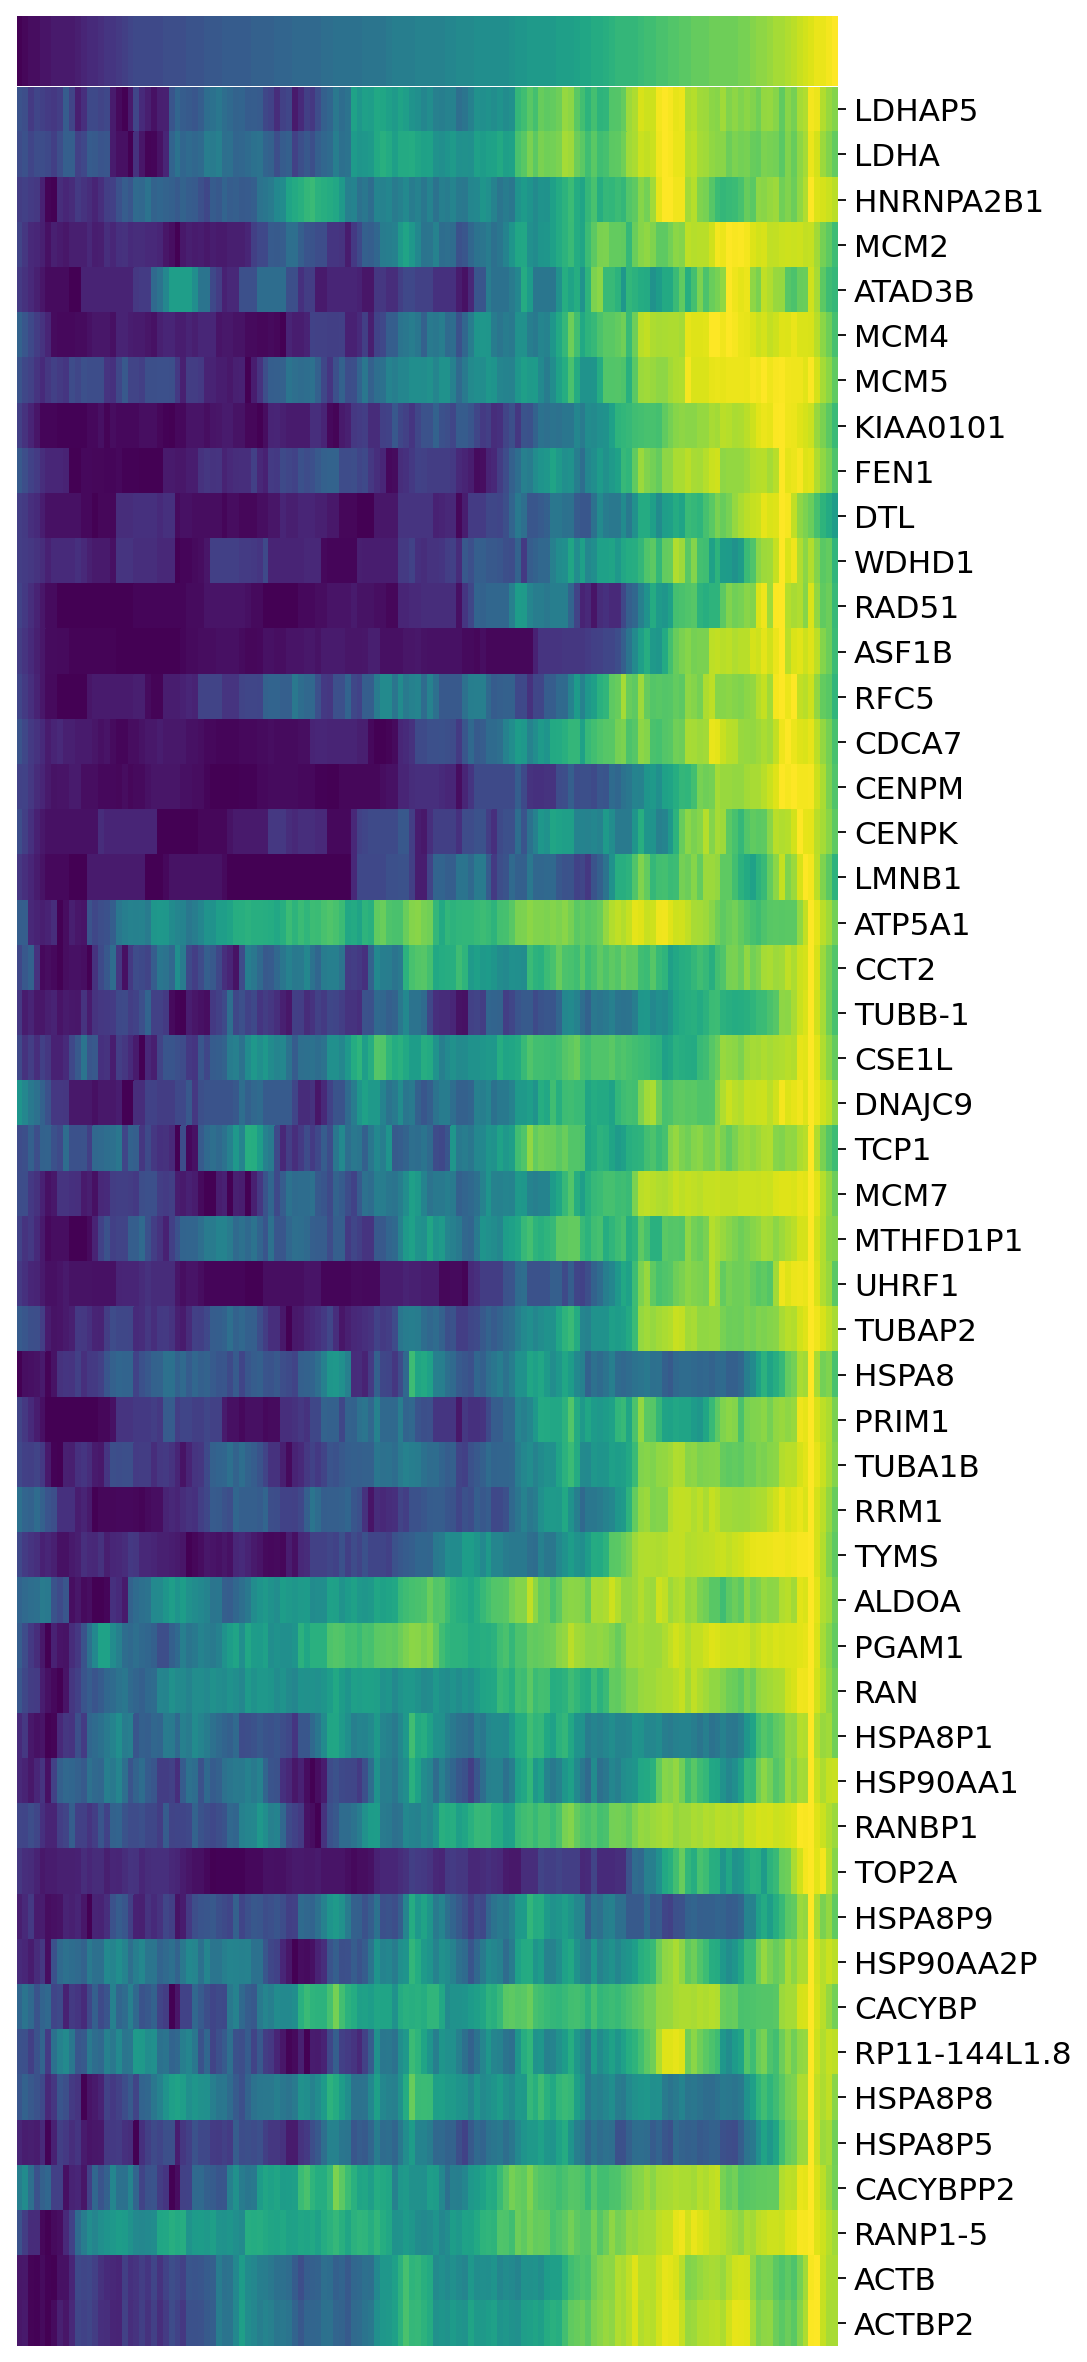

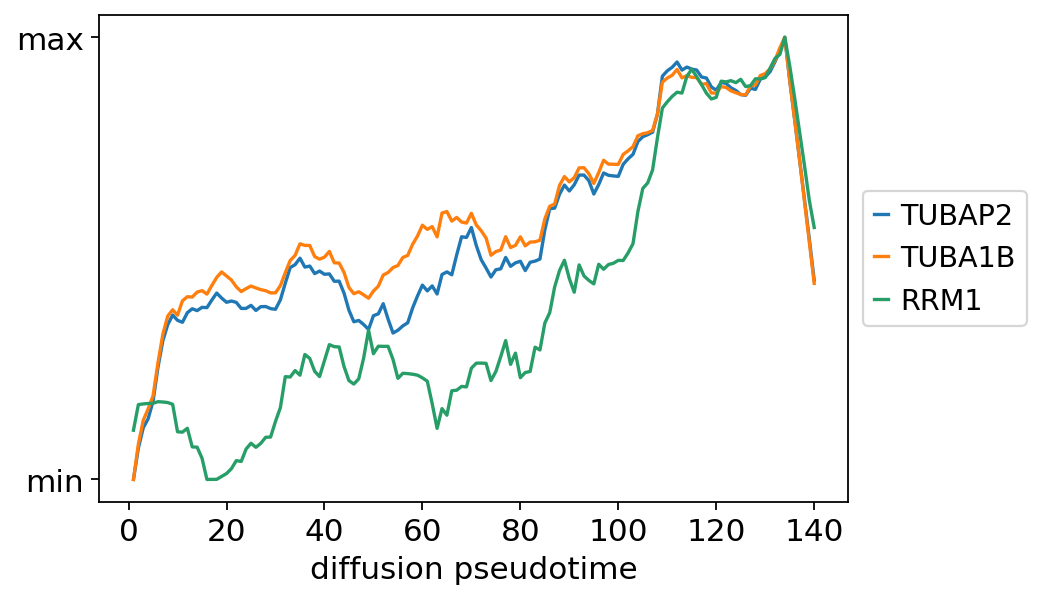

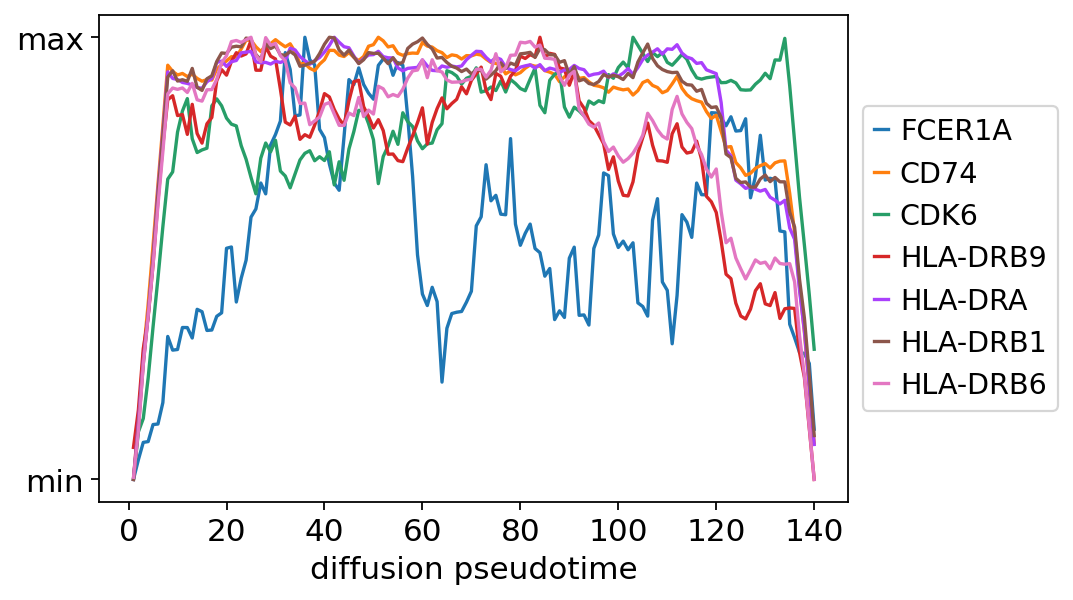

Day3_ST-HSC


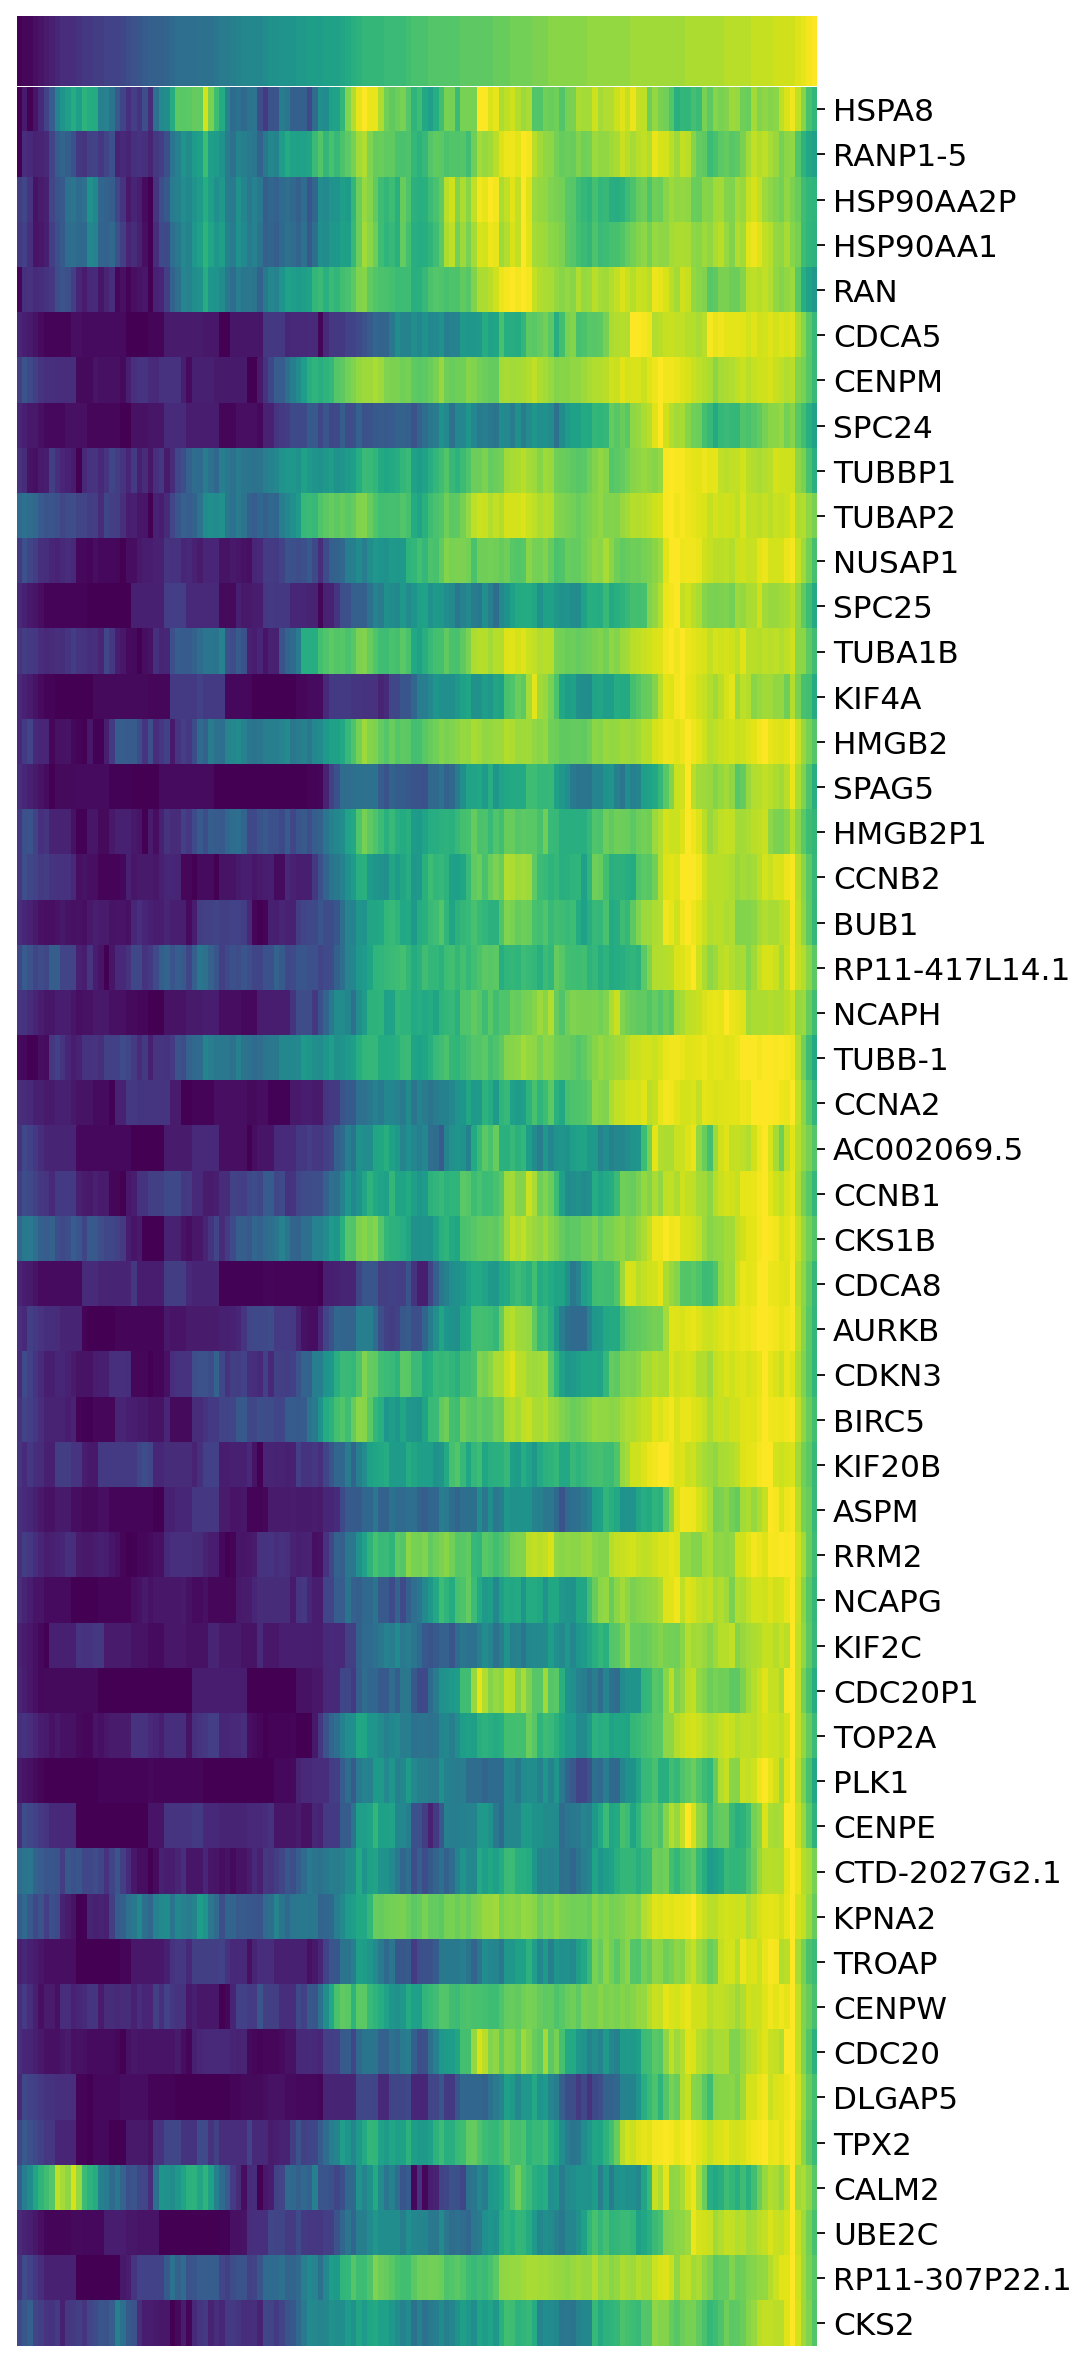

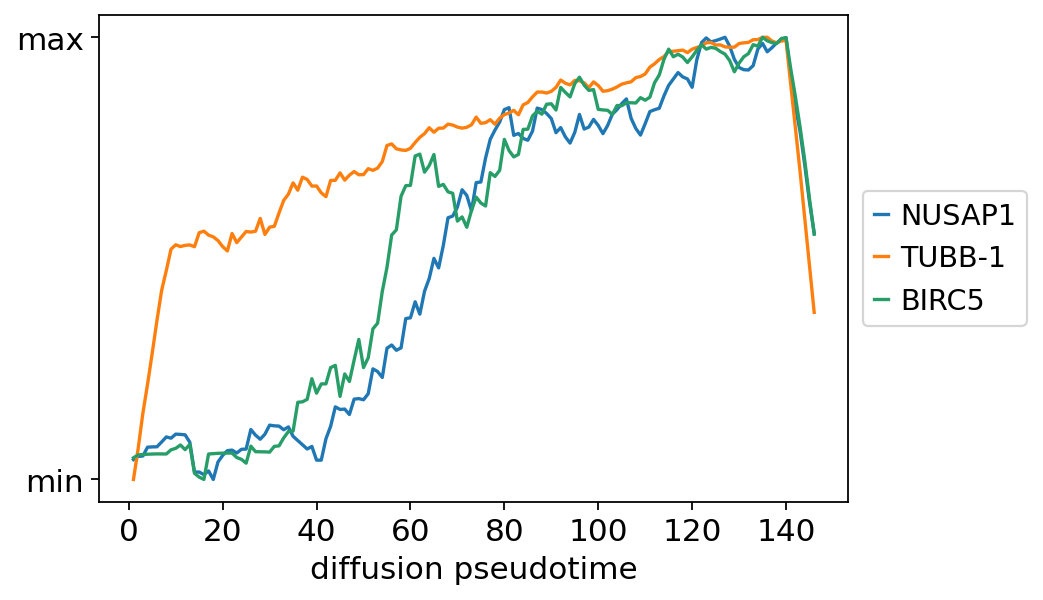

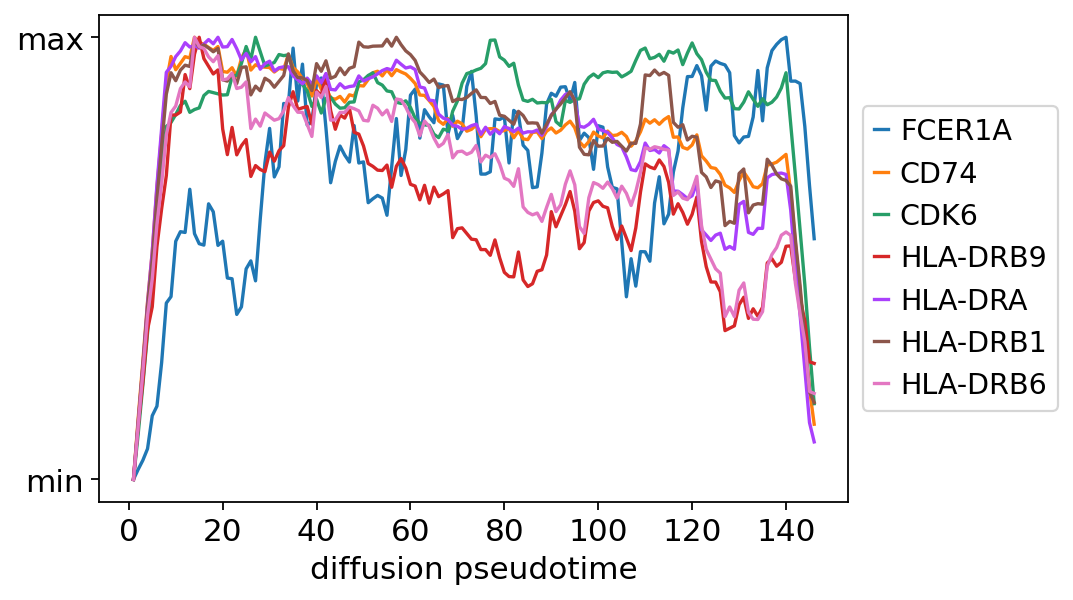

In [85]:
from scipy.stats import rankdata
import scvelo as scv
BMdata.obs['cond_comb1'] = BMdata.obs['cond_comb1'].astype('category')
for cond in BMdata.obs['cond_comb1'].cat.categories:
    print(cond)
    adata_sub = BMdata[BMdata.obs['cond_comb1'] == cond].copy()
    adata_sub.obs['pt_rank'] = rankdata(adata_sub.obs['dpt_pseudotime'])
    DEgene_pt = smqpp.GeneExp_LLR_test(adata_sub, alt_obs=['pt_rank', 'n_genes', 'batch'], useHVG=True, null_obs=['n_genes', 'batch'])

    scv.pl.heatmap(adata_sub, var_names=DEgene_pt.index[0:50], tkey='pt_rank', n_convolve=10, col_color='dpt_pseudotime', figsize=(7,15), yticklabels=True)
    smqpp.plot_genes_along_pt(adata_sub, genes=DEgene_pt.index[0:3], sigma=20, pt_obs='pt_rank')
    GL1 = ['FCER1A', 'CD74', 'CDK6',  
           'HLA-DRB9', 'HLA-DRA', 'HLA-DRB1', 
          'HLA-DRB6']
    smqpp.plot_genes_along_pt(adata_sub, genes=GL1, sigma=20, pt_obs='pt_rank')

In [86]:
CBdata.write('./write/fastMNN_scanpy/CBdata_combat.h5ad')
MPBdata.write('./write/fastMNN_scanpy/MPBdata_combat.h5ad')
BMdata.write('./write/fastMNN_scanpy/BMdata_combat.h5ad')
adata.write('./write/fastMNN_scanpy/CB_MPB_BM_lognorm_combatBC.h5ad') 

... storing 'cond_comb' as categorical
... storing 'cond_comb' as categorical
... storing 'cond_comb' as categorical
... storing 'cond_comb1' as categorical
